## Setup

Before getting started, import the necessary packages:

In [3]:
#!python -m pip install tensorflow

In [88]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [56]:
#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [57]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [97]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

C:\Users\fstri\AppData\Local\Temp\tmprpjc53iv\tensorboard_logs


# FMNS: Try modeling our candles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
#import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing
from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    #path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
    path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    data = pd.read_csv(path + '/' + datafiles[int(file)],
                       header = None,
                       names=['open','high','low','close','spread_open',
                              'spread_high','spread_low','spread_close',
                              'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                              'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                              'Ticker'])
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

Which one do you want to load? 

0: aggregateTAQ_10sec.csv
1: aggregateTAQ_30sec.csv
2: aggregateTAQ_60sec.csv


2


In [3]:
# add ticker as a multiindex or just groupby directly on date & ticker
data #.index

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [4]:
#data = data.assign(ticker=data.Ticker).set_index('ticker', append=True)

In [5]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [6]:
for i, ticker in enumerate(data.Ticker.unique()):
    print(i, ticker)

0 AAPL
1 ABBV
2 ABT
3 AEP
4 AMT
5 APD
6 BA
7 BABA
8 BAC
9 BHP
10 BP
11 CCI
12 CHL
13 COST
14 CSGP
15 D
16 DIS
17 ECL
18 ENB
19 EXC
20 FB
21 FMX
22 GOOG
23 IDU
24 INTC
25 IYC
26 IYE
27 IYG
28 IYH
29 IYJ
30 IYK
31 IYM
32 IYR
33 IYW
34 IYZ
35 JNJ
36 KO
37 LFC
38 LIN
39 LMT
40 MA
41 MCD
42 MSFT
43 NKE
44 NVDA
45 NVS
46 PBR
47 PEP
48 PFE
49 PLD
50 PSA
51 PTR
52 PYPL
53 RTX
54 SHW
55 SNP
56 SO
57 SRE
58 T
59 TM
60 TSLA
61 TSM
62 UNP
63 UPS
64 V
65 WMT


In [7]:
data[data.Ticker=='TSLA']

open     high      low    close  spread_open  spread_high  \
20200501 0    755.140  762.530  753.500  762.215         1.72         4.42   
         1    762.265  763.480  755.065  757.875         1.47         5.91   
         2    757.875  760.225  756.795  758.915         1.33         3.58   
         3    758.920  764.795  755.985  764.475         0.82         3.20   
         4    764.475  772.745  764.130  770.750         1.05         2.98   
...               ...      ...      ...      ...          ...          ...   
20200529 385  833.135  834.920  833.060  834.560         0.47         0.70   
         386  834.635  834.970  834.060  834.160         0.31         0.54   
         387  834.170  834.175  832.420  832.610         0.26         0.64   
         388  832.615  833.965  832.615  833.900         0.19         0.76   
         389  833.895  834.395  833.780  834.145         0.19         0.47   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.02          1.37           1.0           7.0   
         1          0.13          1.33           1.0           7.0   
         2          0.01          0.81           2.0          10.0   
         3          0.01          1.05           1.0          10.0   
         4          0.01          0.84           1.0          20.0   
...                  ...           ...           ...           ...   
20200529 385        0.04          0.46           1.0           6.0   
         386        0.02          0.24           1.0           6.0   
         387        0.03          0.20           3.0          16.0   
         388        0.04          0.20           1.0          10.0   
         389        0.01          0.17           1.0         120.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0            1.0           5.0          26.0   
         1            1.0            2.0          15.0          15.0   
         2            1.0            1.0           2.0           7.0   
         3            1.0            1.0           4.0          30.0   
         4            1.0            1.0          31.0          31.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            3.0           1.0         113.0   
         386          1.0            3.0           1.0          87.0   
         387          1.0            1.0           1.0          26.0   
         388          1.0            1.0           2.0          31.0   
         389          1.0           90.0           2.0          53.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            2.0   TSLA  
         1            1.0            1.0   TSLA  
         2            1.0            1.0   TSLA  
         3            1.0           30.0   TSLA  
         4            1.0            1.0   TSLA  
...                   ...            ...    ...  
20200529 385          1.0            1.0   TSLA  
         386          1.0            1.0   TSLA  
         387          1.0            2.0   TSLA  
         388          1.0           29.0   TSLA  
         389          1.0           28.0   TSLA  

[7800 rows x 17 columns]

In [8]:
from utils.generate_features import generateFeatures_multi_v1

In [9]:
from utils.preprocessing_features_and_labels import extract_labels_multi,\
                                                    align_features_and_labels_multi,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing

In [237]:
########### Generate Features ################

ticker_to_model = 'TSLA'
candles = data[data.Ticker==ticker_to_model]

n_feature_lags = 1
# features = generateFeatures_final(data = candles, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                    ], 
#                                    feature_lags = n_feature_lags)

features = generateFeatures_multi_v1(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
#                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                     'dis5',
#                                                     'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]
#labels = extract_labels_multi(data = price_candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels_multi(price_candles = price_candles, 
                                       all_features = features,
                                       prediction_horizon = 1, 
                                       n_feature_lags = n_feature_lags, 
                                       n_classes = n_classes, # 5,
                                       safe_burn_in = False, 
                                       data_sample = 'full')

['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AAPL done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABBV done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AEP done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AMT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
APD done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BABA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BAC done
['open_lag0' 'open_lag1' '

..\utils\preprocessing_features_and_labels.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burned_in_features['ticker'] = ticker_name


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
IDU done
INTC done
IYC done
IYE done
IYG done
IYH done
IYJ done
IYK done
IYM done
IYR done
IYW done
IYZ done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


In [15]:
# # Test pop versus delete versus slicing all but the removed

# def f1():
#     ticker_features = features[features.ticker=='TSLA'].copy(deep=True)
#     _ = ticker_features.pop('ticker')
#     return ticker_features

# def f2():
#     ticker_features = features[features.ticker=='TSLA'].copy(deep=True)
#     ticker_features.drop('ticker', axis=1, inplace=True)
#     return ticker_features

# def f3():
#     ticker_features = features[features.ticker=='TSLA'].copy(deep=True)
#     ticker_features = ticker_features.iloc[:, ticker_features.columns != 'ticker']
#     return ticker_features

# %timeit -n 100 f1()
# %timeit -n 100 f2()
# %timeit -n 100 f3()

24.4 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.5 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.7 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
features

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        0.240      0.330    -0.655     289.020              0.24   
         1        0.455      1.125    -0.300     288.580              0.07   
         2       -0.610      0.220    -0.815     289.095              0.49   
         3       -1.220      0.115    -1.380     290.320              0.16   
         4        0.235      0.355    -0.565     290.085              0.10   
...                 ...        ...       ...         ...               ...   
20200529 385      0.090      0.090    -0.075     123.995              0.01   
         386     -0.340      0.020    -0.350     124.335              0.01   
         387      0.260      0.280    -0.015     124.075              0.05   
         388      0.220      0.370    -1.045     123.855              0.01   
         389        NaN        NaN       NaN         NaN               NaN   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                0.45             0.01               0.10   
         1                0.49             0.01               0.30   
         2                0.49             0.01               0.17   
         3                0.33             0.01               0.10   
         4                0.42             0.01               0.05   
...                        ...              ...                ...   
20200529 385              0.06             0.01               0.01   
         386              0.07             0.01               0.05   
         387              0.12             0.01               0.01   
         388              2.43             0.01               0.21   
         389               NaN              NaN                NaN   

              bidsize_open_lag0  bidsize_high_lag0  ...  spread_close_lag1  \
20200501 0                  9.0               20.0  ...               0.24   
         1                  1.0               50.0  ...               0.10   
         2                  1.0               25.0  ...               0.30   
         3                 13.0               71.0  ...               0.17   
         4                  2.0               86.0  ...               0.10   
...                         ...                ...  ...                ...   
20200529 385                1.0                8.0  ...               0.04   
         386                4.0               16.0  ...               0.01   
         387                3.0                6.0  ...               0.05   
         388                1.0               20.0  ...               0.01   
         389                NaN                NaN  ...               0.21   

              bidsize_open_lag1  bidsize_high_lag1  bidsize_low_lag1  \
20200501 0                  6.0               95.0               1.0   
         1                  9.0               20.0               1.0   
         2                  1.0               50.0               1.0   
         3                  1.0               25.0               1.0   
         4                 13.0               71.0               1.0   
...                         ...                ...               ...   
20200529 385                1.0               11.0               1.0   
         386                1.0                8.0               1.0   
         387                4.0               16.0               1.0   
         388                3.0                6.0               1.0   
         389                1.0               20.0               1.0   

              bidsize_close_lag1  ofrsize_open_lag1  ofrsize_high_lag1  \
20200501 0                  10.0                1.0               85.0   
         1                   1.0                4.0               56.0   
         2                   1.0                1.0               13.0   
         3                  16.0                1.0                8.0   
         4                   1.0                1.0             

In [124]:
features[features.ticker=='TSLA']

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        4.390      5.605    -2.810     757.875              1.47   
         1       -1.040      1.310    -2.120     758.915              1.33   
         2       -5.555      0.320    -8.490     764.475              0.82   
         3       -6.275      1.995    -6.620     770.750              1.05   
         4        1.115      1.590    -2.805     769.650              0.81   
...                 ...        ...       ...         ...               ...   
20200529 385      0.475      0.810    -0.100     834.160              0.31   
         386      1.560      1.565    -0.190     832.610              0.26   
         387     -1.285      0.065    -1.285     833.900              0.19   
         388     -0.250      0.250    -0.365     834.145              0.19   
         389        NaN        NaN       NaN         NaN               NaN   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                5.91             0.13               1.33   
         1                3.58             0.01               0.81   
         2                3.20             0.01               1.05   
         3                2.98             0.01               0.84   
         4                2.53             0.21               0.70   
...                        ...              ...                ...   
20200529 385              0.54             0.02               0.24   
         386              0.64             0.03               0.20   
         387              0.76             0.04               0.20   
         388              0.47             0.01               0.17   
         389               NaN              NaN                NaN   

              bidsize_open_lag0  bidsize_high_lag0  ...  spread_close_lag1  \
20200501 0                  1.0                7.0  ...               1.37   
         1                  2.0               10.0  ...               1.33   
         2                  1.0               10.0  ...               0.81   
         3                  1.0               20.0  ...               1.05   
         4                  1.0               19.0  ...               0.84   
...                         ...                ...  ...                ...   
20200529 385                1.0                6.0  ...               0.46   
         386                3.0               16.0  ...               0.24   
         387                1.0               10.0  ...               0.20   
         388                1.0              120.0  ...               0.20   
         389                NaN                NaN  ...               0.17   

              bidsize_open_lag1  bidsize_high_lag1  bidsize_low_lag1  \
20200501 0                  1.0                7.0               1.0   
         1                  1.0                7.0               1.0   
         2                  2.0               10.0               1.0   
         3                  1.0               10.0               1.0   
         4                  1.0               20.0               1.0   
...                         ...                ...               ...   
20200529 385                1.0                6.0               1.0   
         386                1.0                6.0               1.0   
         387                3.0               16.0               1.0   
         388                1.0               10.0               1.0   
         389                1.0              120.0               1.0   

              bidsize_close_lag1  ofrsize_open_lag1  ofrsize_high_lag1  \
20200501 0                   1.0                5.0               26.0   
         1                   2.0               15.0               15.0   
         2                   1.0                2.0                7.0   
         3                   1.0                4.0               30.0   
         4                   1.0               31.0             

In [15]:
price_candles = data[['open','high','low','close','Ticker']]
price_candles

open     high      low    close Ticker
20200501 0    286.250  289.260  285.870  289.260   AAPL
         1    289.260  289.350  288.365  289.020   AAPL
         2    289.035  289.705  288.280  288.580   AAPL
         3    288.485  289.315  288.280  289.095   AAPL
         4    289.100  290.435  288.940  290.320   AAPL
...               ...      ...      ...      ...    ...
20200529 385  123.950  124.110  123.910  124.100    WMT
         386  124.085  124.085  123.920  123.995    WMT
         387  123.995  124.355  123.985  124.335    WMT
         388  124.335  124.355  124.060  124.075    WMT
         389  124.075  124.225  122.810  123.855    WMT

[514800 rows x 5 columns]

In [125]:
len(price_candles[price_candles.Ticker=='TSLA']['close'].values), price_candles[price_candles.Ticker=='TSLA']['close'].values

(7800, array([762.215, 757.875, 758.915, ..., 832.61 , 833.9  , 834.145]))

In [126]:
returns = ((price_candles[price_candles.Ticker=='TSLA']['close'].values[1:] / price_candles[price_candles.Ticker=='TSLA']['close'].values[:-1])-1)*100

In [29]:

#%timeit ((price_candles[price_candles.Ticker=='TSLA']['close'][1:] / price_candles[price_candles.Ticker=='TSLA']['close'][:-1])-1)*100
#%timeit ((price_candles[price_candles.Ticker=='TSLA']['close'].values[1:] / price_candles[price_candles.Ticker=='TSLA']['close'].values[:-1])-1)*100

53.5 ms ± 831 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.3 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
len(returns), returns

(7799, array([-0.56939315,  0.1372258 ,  0.73262487, ..., -0.18581567,
         0.15493448,  0.02938002]))

In [128]:
candles.iloc[:, :4] #.values

open     high      low    close
20200501 0    755.140  762.530  753.500  762.215
         1    762.265  763.480  755.065  757.875
         2    757.875  760.225  756.795  758.915
         3    758.920  764.795  755.985  764.475
         4    764.475  772.745  764.130  770.750
...               ...      ...      ...      ...
20200529 385  833.135  834.920  833.060  834.560
         386  834.635  834.970  834.060  834.160
         387  834.170  834.175  832.420  832.610
         388  832.615  833.965  832.615  833.900
         389  833.895  834.395  833.780  834.145

[7800 rows x 4 columns]

In [129]:
features

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        0.240      0.330    -0.655     289.020              0.24   
         1        0.455      1.125    -0.300     288.580              0.07   
         2       -0.610      0.220    -0.815     289.095              0.49   
         3       -1.220      0.115    -1.380     290.320              0.16   
         4        0.235      0.355    -0.565     290.085              0.10   
...                 ...        ...       ...         ...               ...   
20200529 385      0.090      0.090    -0.075     123.995              0.01   
         386     -0.340      0.020    -0.350     124.335              0.01   
         387      0.260      0.280    -0.015     124.075              0.05   
         388      0.220      0.370    -1.045     123.855              0.01   
         389        NaN        NaN       NaN         NaN               NaN   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                0.45             0.01               0.10   
         1                0.49             0.01               0.30   
         2                0.49             0.01               0.17   
         3                0.33             0.01               0.10   
         4                0.42             0.01               0.05   
...                        ...              ...                ...   
20200529 385              0.06             0.01               0.01   
         386              0.07             0.01               0.05   
         387              0.12             0.01               0.01   
         388              2.43             0.01               0.21   
         389               NaN              NaN                NaN   

              bidsize_open_lag0  bidsize_high_lag0  ...  spread_close_lag1  \
20200501 0                  9.0               20.0  ...               0.24   
         1                  1.0               50.0  ...               0.10   
         2                  1.0               25.0  ...               0.30   
         3                 13.0               71.0  ...               0.17   
         4                  2.0               86.0  ...               0.10   
...                         ...                ...  ...                ...   
20200529 385                1.0                8.0  ...               0.04   
         386                4.0               16.0  ...               0.01   
         387                3.0                6.0  ...               0.05   
         388                1.0               20.0  ...               0.01   
         389                NaN                NaN  ...               0.21   

              bidsize_open_lag1  bidsize_high_lag1  bidsize_low_lag1  \
20200501 0                  6.0               95.0               1.0   
         1                  9.0               20.0               1.0   
         2                  1.0               50.0               1.0   
         3                  1.0               25.0               1.0   
         4                 13.0               71.0               1.0   
...                         ...                ...               ...   
20200529 385                1.0               11.0               1.0   
         386                1.0                8.0               1.0   
         387                4.0               16.0               1.0   
         388                3.0                6.0               1.0   
         389                1.0               20.0               1.0   

              bidsize_close_lag1  ofrsize_open_lag1  ofrsize_high_lag1  \
20200501 0                  10.0                1.0               85.0   
         1                   1.0                4.0               56.0   
         2                   1.0                1.0               13.0   
         3                  16.0                1.0                8.0   
         4                   1.0                1.0             

In [238]:
X

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        0.240      0.330    -0.655     289.020              0.24   
         1        0.455      1.125    -0.300     288.580              0.07   
         2       -0.610      0.220    -0.815     289.095              0.49   
         3       -1.220      0.115    -1.380     290.320              0.16   
         4        0.235      0.355    -0.565     290.085              0.10   
...                 ...        ...       ...         ...               ...   
20200529 383     -0.110      0.010    -0.175     123.950              0.02   
         384     -0.150      0.010    -0.190     124.100              0.02   
         385      0.090      0.090    -0.075     123.995              0.01   
         386     -0.340      0.020    -0.350     124.335              0.01   
         387      0.260      0.280    -0.015     124.075              0.05   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                0.45             0.01               0.10   
         1                0.49             0.01               0.30   
         2                0.49             0.01               0.17   
         3                0.33             0.01               0.10   
         4                0.42             0.01               0.05   
...                        ...              ...                ...   
20200529 383              0.07             0.01               0.02   
         384              0.07             0.01               0.04   
         385              0.06             0.01               0.01   
         386              0.07             0.01               0.05   
         387              0.12             0.01               0.01   

              bidsize_open_lag0  bidsize_high_lag0  ...  spread_close_lag1  \
20200501 0                  9.0               20.0  ...               0.24   
         1                  1.0               50.0  ...               0.10   
         2                  1.0               25.0  ...               0.30   
         3                 13.0               71.0  ...               0.17   
         4                  2.0               86.0  ...               0.10   
...                         ...                ...  ...                ...   
20200529 383                3.0                6.0  ...               0.01   
         384                1.0               11.0  ...               0.02   
         385                1.0                8.0  ...               0.04   
         386                4.0               16.0  ...               0.01   
         387                3.0                6.0  ...               0.05   

              bidsize_open_lag1  bidsize_high_lag1  bidsize_low_lag1  \
20200501 0                  6.0               95.0               1.0   
         1                  9.0               20.0               1.0   
         2                  1.0               50.0               1.0   
         3                  1.0               25.0               1.0   
         4                 13.0               71.0               1.0   
...                         ...                ...               ...   
20200529 383                1.0                9.0               1.0   
         384                3.0                6.0               1.0   
         385                1.0               11.0               1.0   
         386                1.0                8.0               1.0   
         387                4.0               16.0               1.0   

              bidsize_close_lag1  ofrsize_open_lag1  ofrsize_high_lag1  \
20200501 0                  10.0                1.0               85.0   
         1                   1.0                4.0               56.0   
         2                   1.0                1.0               13.0   
         3                  16.0                1.0                8.0   
         4                   1.0                1.0             

In [239]:
# Dummify tickers
tickers = X.pop('ticker')
pd.get_dummies(tickers, prefix='ticker', drop_first=False)

ticker_AAPL  ticker_ABBV  ticker_ABT  ticker_AEP  ticker_AMT  \
20200501 0              1            0           0           0           0   
         1              1            0           0           0           0   
         2              1            0           0           0           0   
         3              1            0           0           0           0   
         4              1            0           0           0           0   
...                   ...          ...         ...         ...         ...   
20200529 383            0            0           0           0           0   
         384            0            0           0           0           0   
         385            0            0           0           0           0   
         386            0            0           0           0           0   
         387            0            0           0           0           0   

              ticker_APD  ticker_BA  ticker_BABA  ticker_BAC  ticker_BHP  ...  \
20200501 0             0          0            0           0           0  ...   
         1             0          0            0           0           0  ...   
         2             0          0            0           0           0  ...   
         3             0          0            0           0           0  ...   
         4             0          0            0           0           0  ...   
...                  ...        ...          ...         ...         ...  ...   
20200529 383           0          0            0           0           0  ...   
         384           0          0            0           0           0  ...   
         385           0          0            0           0           0  ...   
         386           0          0            0           0           0  ...   
         387           0          0            0           0           0  ...   

              ticker_SO  ticker_SRE  ticker_T  ticker_TM  ticker_TSLA  \
20200501 0            0           0         0          0            0   
         1            0           0         0          0            0   
         2            0           0         0          0            0   
         3            0           0         0          0            0   
         4            0           0         0          0            0   
...                 ...         ...       ...        ...          ...   
20200529 383          0           0         0          0            0   
         384          0           0         0          0            0   
         385          0           0         0          0            0   
         386          0           0         0          0            0   
         387          0           0         0          0            0   

              ticker_TSM  ticker_UNP  ticker_UPS  ticker_V  ticker_WMT  
20200501 0             0           0           0         0           0  
         1             0           0           0         0           0  
         2             0           0           0         0           0  
         3             0           0           0         0           0  
         4             0           0           0         0           0  
...                  ...         ...         ...       ...         ...  
20200529 383           0           0           0         0           1  
         384           0           0           0         0           1  
         385           0           0           0         0           1  
         386           0           0           0         0           1  
         387           0           0           0         0           1  

[514668 rows x 66 columns]

In [240]:
X

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        0.240      0.330    -0.655     289.020              0.24   
         1        0.455      1.125    -0.300     288.580              0.07   
         2       -0.610      0.220    -0.815     289.095              0.49   
         3       -1.220      0.115    -1.380     290.320              0.16   
         4        0.235      0.355    -0.565     290.085              0.10   
...                 ...        ...       ...         ...               ...   
20200529 383     -0.110      0.010    -0.175     123.950              0.02   
         384     -0.150      0.010    -0.190     124.100              0.02   
         385      0.090      0.090    -0.075     123.995              0.01   
         386     -0.340      0.020    -0.350     124.335              0.01   
         387      0.260      0.280    -0.015     124.075              0.05   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                0.45             0.01               0.10   
         1                0.49             0.01               0.30   
         2                0.49             0.01               0.17   
         3                0.33             0.01               0.10   
         4                0.42             0.01               0.05   
...                        ...              ...                ...   
20200529 383              0.07             0.01               0.02   
         384              0.07             0.01               0.04   
         385              0.06             0.01               0.01   
         386              0.07             0.01               0.05   
         387              0.12             0.01               0.01   

              bidsize_open_lag0  bidsize_high_lag0  ...  spread_low_lag1  \
20200501 0                  9.0               20.0  ...             0.01   
         1                  1.0               50.0  ...             0.01   
         2                  1.0               25.0  ...             0.01   
         3                 13.0               71.0  ...             0.01   
         4                  2.0               86.0  ...             0.01   
...                         ...                ...  ...              ...   
20200529 383                3.0                6.0  ...             0.01   
         384                1.0               11.0  ...             0.01   
         385                1.0                8.0  ...             0.01   
         386                4.0               16.0  ...             0.01   
         387                3.0                6.0  ...             0.01   

              spread_close_lag1  bidsize_open_lag1  bidsize_high_lag1  \
20200501 0                 0.24                6.0               95.0   
         1                 0.10                9.0               20.0   
         2                 0.30                1.0               50.0   
         3                 0.17                1.0               25.0   
         4                 0.10               13.0               71.0   
...                         ...                ...                ...   
20200529 383               0.01                1.0                9.0   
         384               0.02                3.0                6.0   
         385               0.04                1.0               11.0   
         386               0.01                1.0                8.0   
         387               0.05                4.0               16.0   

              bidsize_low_lag1  bidsize_close_lag1  ofrsize_open_lag1  \
20200501 0                 1.0                10.0                1.0   
         1                 1.0                 1.0                4.0   
         2                 1.0                 1.0                1.0   
         3                 1.0                16.0                1.0   
         4                 1.0                 1.0                1.0   
...     

In [241]:
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [242]:
# Later also add relevant sector for the given ticker and dummify

In [243]:
X

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        0.240      0.330    -0.655     289.020              0.24   
         1        0.455      1.125    -0.300     288.580              0.07   
         2       -0.610      0.220    -0.815     289.095              0.49   
         3       -1.220      0.115    -1.380     290.320              0.16   
         4        0.235      0.355    -0.565     290.085              0.10   
...                 ...        ...       ...         ...               ...   
20200529 383     -0.110      0.010    -0.175     123.950              0.02   
         384     -0.150      0.010    -0.190     124.100              0.02   
         385      0.090      0.090    -0.075     123.995              0.01   
         386     -0.340      0.020    -0.350     124.335              0.01   
         387      0.260      0.280    -0.015     124.075              0.05   

              spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                0.45             0.01               0.10   
         1                0.49             0.01               0.30   
         2                0.49             0.01               0.17   
         3                0.33             0.01               0.10   
         4                0.42             0.01               0.05   
...                        ...              ...                ...   
20200529 383              0.07             0.01               0.02   
         384              0.07             0.01               0.04   
         385              0.06             0.01               0.01   
         386              0.07             0.01               0.05   
         387              0.12             0.01               0.01   

              bidsize_open_lag0  bidsize_high_lag0  ...  ticker_SO  \
20200501 0                  9.0               20.0  ...          0   
         1                  1.0               50.0  ...          0   
         2                  1.0               25.0  ...          0   
         3                 13.0               71.0  ...          0   
         4                  2.0               86.0  ...          0   
...                         ...                ...  ...        ...   
20200529 383                3.0                6.0  ...          0   
         384                1.0               11.0  ...          0   
         385                1.0                8.0  ...          0   
         386                4.0               16.0  ...          0   
         387                3.0                6.0  ...          0   

              ticker_SRE  ticker_T  ticker_TM  ticker_TSLA  ticker_TSM  \
20200501 0             0         0          0            0           0   
         1             0         0          0            0           0   
         2             0         0          0            0           0   
         3             0         0          0            0           0   
         4             0         0          0            0           0   
...                  ...       ...        ...          ...         ...   
20200529 383           0         0          0            0           0   
         384           0         0          0            0           0   
         385           0         0          0            0           0   
         386           0         0          0            0           0   
         387           0         0          0            0           0   

              ticker_UNP  ticker_UPS  ticker_V  ticker_WMT  
20200501 0             0           0         0           0  
         1             0           0         0           0  
         2             0           0         0           0  
         3             0           0         0           0  
         4             0           0         0           0  
...                  ...         ...       ...         ...  
20200529 383           0           0         0           1  
         384      

In [244]:
y

,0
0,0.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
7793,1.0
7794,0.0
7795,1.0
7796,0.0


# Train a few models

In [85]:
'''
We need:

validate_ds = val_data.cache()
train_ds = train_data.cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)


'''

'\nWe need:\n\nvalidate_ds = val_data.cache()\ntrain_ds = train_data.cache()\n\nvalidate_ds = validate_ds.batch(BATCH_SIZE)\ntrain_ds = train_ds.batch(BATCH_SIZE)\n\n\n'

In [247]:
val_cutoff = int(X.shape[0]*0.8)
train_ds, train_y = X.iloc[:val_cutoff, :], y[:val_cutoff]
validate_ds, val_y = X.iloc[val_cutoff:, :], y[val_cutoff:]


In [248]:
N_VALIDATION = y[val_cutoff:].shape[0] #int(1e3)
N_TRAIN = y[:val_cutoff].shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(411734, 102934, 1608, 131, 804000)

In [249]:
train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape

((411734, 98), (411734, 1), (102934, 98), (102934, 1))

In [74]:
train_ds_tf = tf.data.Dataset.from_tensor_slices((X.iloc[:val_cutoff, :].values, y[:val_cutoff])).cache().repeat(N_REPEAT).batch(BATCH_SIZE)
train_ds_tf

<BatchDataset shapes: ((None, 98), (None, 1)), types: (tf.float64, tf.float64)>

In [75]:
X.iloc[:val_cutoff, :].values[0]

array([ 2.4000e-01,  3.3000e-01, -6.5500e-01,  2.8902e+02,  2.4000e-01,
        4.5000e-01,  1.0000e-02,  1.0000e-01,  9.0000e+00,  2.0000e+01,
        1.0000e+00,  1.0000e+00,  4.0000e+00,  5.6000e+01,  1.0000e+00,
        1.0000e+00, -2.7700e+00,  2.4000e-01, -3.1500e+00,  2.4000e-01,
        5.0000e-01,  5.0000e-01,  1.0000e-02,  2.4000e-01,  6.0000e+00,
        9.5000e+01,  1.0000e+00,  1.0000e+01,  1.0000e+00,  8.5000e+01,
        1.0000e+00,  4.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.00

In [299]:
# for feat, targ in train_ds_tf.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [77]:
validate_ds_tf = tf.data.Dataset.from_tensor_slices((X.iloc[val_cutoff:, :].values, 
                                                  y[val_cutoff:]))\
                                                    .cache().repeat(N_REPEAT).batch(BATCH_SIZE)

In [78]:
validate_ds_tf

<BatchDataset shapes: ((None, 98), (None, 1)), types: (tf.float64, tf.float64)>

In [300]:
# for feat, targ in validate_ds_tf.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

# Begin with some sklearn logistic regression in a gridsearch

In [86]:
# Adding a few things
from sklearn.linear_model import LogisticRegression

## Setting up the model and corresponding parameters

logreg = LogisticRegression(random_state=123, max_iter=100, multi_class='auto')
#rf = ensemble.RandomForestClassifier()

param_grid = {'logreg': {'penalty': ['l2','none'], # some solvers do not accept l1
                         'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
                         'fit_intercept': [False, True],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                         #'multi_class': ['ovr', 'multinomial']
                        },
              'knn': {'n_neighbors': [1,3,5,7,9,11,13,15,17,19]},
              'rf': {'n_estimators': [50,100,200], 'max_features': ['auto', None], 'min_samples_leaf': [1, 5, 10]}}

## Setting parameters for grid search
cv_folds = 5
n_jobs = 10
typesOfCV = {'Standard':cv_folds,
             #'Time Series Splitting':TimeSeriesSplit(cv_folds),
             #'Blocked Time Series Splitting':BlockingTimeSeriesSplit(cv_folds)
            }

# Perform different types of grid search.
for cvType,container in typesOfCV.items():
    print('---------------- Evaluating %s ----------------' % cvType)
    start = time.time()
    
    ## Performing grid search
    #grid_search = GridSearchCV(rf, param_grid['rf'], cv = container, n_jobs = n_jobs)# cv = cv_folds
    grid_search = GridSearchCV(logreg, param_grid['logreg'], cv = container, n_jobs = n_jobs, verbose=1)# cv = cv_folds
    grid_search.fit(train_ds, train_y.values.ravel())

    # store the best hyperparameters and best CV performance
    logreg_params = grid_search.best_params_
    logreg_cv_res = grid_search.cv_results_

---------------- Evaluating Standard ----------------
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

In [84]:
grid_search.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [82]:
logreg_params

NameError: name 'logreg_params' is not defined

# Setup logistic in TF/keras and add a params tuner

In [118]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid',
                      kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1)                 99        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
797/805 [============================>.] - ETA: 0s - loss: 1.7237 - accuracy: 0.5313 - auc: 0.5247
Epoch: 0, accuracy:0.5314,  auc:0.5247,  loss:1.7145,  val_accuracy:0.5361,  val_auc:0.5219,  val_loss:0.6895,  
805/805 [==============================] - 4s 5ms/step - loss: 1.7145 - accuracy: 0.5314 - auc: 0.5247 - val_loss: 0.6895 - val_accuracy: 0.5361 - val_auc: 0.5219
Epoch 2/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5437 - auc: 0.5398 - val_loss: 0.6887 - val_accuracy: 0.5370 - val_auc: 0.5350
Epoch 3/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6890 - ac

805/805 [==============================] - 3s 4ms/step - loss: 0.6896 - accuracy: 0.5442 - auc: 0.5412 - val_loss: 0.6890 - val_accuracy: 0.5328 - val_auc: 0.5298
Epoch 44/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5439 - auc: 0.5404 - val_loss: 0.6919 - val_accuracy: 0.5368 - val_auc: 0.5274
Epoch 45/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6894 - accuracy: 0.5442 - auc: 0.5414 - val_loss: 0.6931 - val_accuracy: 0.5239 - val_auc: 0.5178
Epoch 46/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5437 - auc: 0.5420 - val_loss: 0.6894 - val_accuracy: 0.5348 - val_auc: 0.5341
Epoch 47/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6915 - accuracy: 0.5436 - auc: 0.5385 - val_loss: 0.6896 - val_accuracy: 0.5352 - val_auc: 0.5274
Epoch 48/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6893 - accuracy: 0.5439 - auc: 0.5434 - val_loss: 

805/805 [==============================] - 3s 4ms/step - loss: 0.6899 - accuracy: 0.5440 - auc: 0.5412 - val_loss: 0.6907 - val_accuracy: 0.5326 - val_auc: 0.5295
Epoch 90/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6899 - accuracy: 0.5441 - auc: 0.5429 - val_loss: 0.6898 - val_accuracy: 0.5353 - val_auc: 0.5299
Epoch 91/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6907 - accuracy: 0.5436 - auc: 0.5416 - val_loss: 0.6888 - val_accuracy: 0.5364 - val_auc: 0.5343
Epoch 92/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6893 - accuracy: 0.5442 - auc: 0.5418 - val_loss: 0.6890 - val_accuracy: 0.5327 - val_auc: 0.5305
Epoch 93/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6901 - accuracy: 0.5443 - auc: 0.5415 - val_loss: 0.6907 - val_accuracy: 0.5349 - val_auc: 0.5246
Epoch 94/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6910 - accuracy: 0.5440 - auc: 0.5398 - val_loss: 

Epoch 134/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6906 - accuracy: 0.5440 - auc: 0.5408 - val_loss: 0.6888 - val_accuracy: 0.5359 - val_auc: 0.5331
Epoch 135/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6894 - accuracy: 0.5440 - auc: 0.5415 - val_loss: 0.6890 - val_accuracy: 0.5362 - val_auc: 0.5326
Epoch 136/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6901 - accuracy: 0.5441 - auc: 0.5406 - val_loss: 0.6894 - val_accuracy: 0.5359 - val_auc: 0.5317
Epoch 137/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5437 - auc: 0.5401 - val_loss: 0.6899 - val_accuracy: 0.5361 - val_auc: 0.5297
Epoch 138/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6907 - accuracy: 0.5437 - auc: 0.5402 - val_loss: 0.6897 - val_accuracy: 0.5361 - val_auc: 0.5314
Epoch 139/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6894 - accuracy: 0.5444 - auc:

805/805 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5441 - auc: 0.5408 - val_loss: 0.6891 - val_accuracy: 0.5340 - val_auc: 0.5340
Epoch 181/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6903 - accuracy: 0.5437 - auc: 0.5420 - val_loss: 0.6908 - val_accuracy: 0.5335 - val_auc: 0.5192
Epoch 182/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5438 - auc: 0.5418 - val_loss: 0.6889 - val_accuracy: 0.5370 - val_auc: 0.5330
Epoch 183/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6899 - accuracy: 0.5437 - auc: 0.5411 - val_loss: 0.6916 - val_accuracy: 0.5338 - val_auc: 0.5060
Epoch 184/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6896 - accuracy: 0.5440 - auc: 0.5408 - val_loss: 0.6891 - val_accuracy: 0.5369 - val_auc: 0.5312
Epoch 185/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6898 - accuracy: 0.5440 - auc: 0.5408 - val_l

Epoch 225/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6891 - accuracy: 0.5443 - auc: 0.5419 - val_loss: 0.6901 - val_accuracy: 0.5361 - val_auc: 0.5307
Epoch 226/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6912 - accuracy: 0.5435 - auc: 0.5409 - val_loss: 0.6899 - val_accuracy: 0.5321 - val_auc: 0.5327
Epoch 227/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6903 - accuracy: 0.5441 - auc: 0.5411 - val_loss: 0.6919 - val_accuracy: 0.5277 - val_auc: 0.5260
Epoch 228/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6905 - accuracy: 0.5441 - auc: 0.5408 - val_loss: 0.6897 - val_accuracy: 0.5324 - val_auc: 0.5320
Epoch 229/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6898 - accuracy: 0.5435 - auc: 0.5413 - val_loss: 0.6958 - val_accuracy: 0.5311 - val_auc: 0.4838
Epoch 230/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6911 - accuracy: 0.5435 - auc:

In [114]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [115]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 26264), started 0:41:50 ago. (Use '!kill 26264' to kill it.)

In [ ]:
Without any regularization:
----------------
Epoch 647/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6824 - accuracy: 0.5459 - auc: 0.5564 - val_loss: 0.6919 - val_accuracy: 0.5261 - val_auc: 0.5276
Epoch 648/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6827 - accuracy: 0.5448 - auc: 0.5561 - val_loss: 0.7021 - val_accuracy: 0.5144 - val_auc: 0.5269
Epoch 649/1000
792/805 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5457 - auc: 0.5563.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6818 - accuracy: 0.5458 - auc: 0.5564 - val_loss: 0.6947 - val_accuracy: 0.5242 - val_auc: 0.5284
Epoch 00649: early stopping
    
With L2 = 0.001:
----------------
Epoch 527/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6840 - accuracy: 0.5458 - auc: 0.5562 - val_loss: 0.6941 - val_accuracy: 0.5365 - val_auc: 0.5357
Epoch 528/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6851 - accuracy: 0.5448 - auc: 0.5544 - val_loss: 0.6908 - val_accuracy: 0.5363 - val_auc: 0.5478
Epoch 529/1000
796/805 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5455 - auc: 0.5550.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6863 - accuracy: 0.5456 - auc: 0.5551 - val_loss: 0.6900 - val_accuracy: 0.5389 - val_auc: 0.5446
Epoch 00529: early stopping        
    
With L2 = 1:
----------------
Epoch 237/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5436 - auc: 0.5399 - val_loss: 0.6889 - val_accuracy: 0.5361 - val_auc: 0.5320
Epoch 238/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6898 - accuracy: 0.5439 - auc: 0.5403 - val_loss: 0.6955 - val_accuracy: 0.5328 - val_auc: 0.5274
Epoch 239/1000
792/805 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5444 - auc: 0.5434.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6905 - accuracy: 0.5442 - auc: 0.5430 - val_loss: 0.6890 - val_accuracy: 0.5363 - val_auc: 0.5315
Epoch 00239: early stopping

# What can we do to evaluate multiclass? TF/Keras does not have AUC for multi

In [143]:
# keep sigmoid activation at the output layer & have the loss function expect probabilities

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(4, input_shape=(FEATURES,), activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 396       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
800/805 [============================>.] - ETA: 0s - loss: 1.4218 - accuracy: 0.2488
Epoch: 0, accuracy:0.2488,  loss:1.4216,  val_accuracy:0.2499,  val_loss:1.3892,  
805/805 [==============================] - 2s 3ms/step - loss: 1.4216 - accuracy: 0.2488 - val_loss: 1.3892 - val_accuracy: 0.2499
Epoch 2/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3883 - accuracy: 0.2473 - val_loss: 1.3882 - val_accuracy: 0.2502
Epoch 3/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3877 - accuracy: 0.2468 - val_loss: 1.3878 - val_accuracy: 0.2502
Epoch 4/1000
805/805 [===========================

805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2930 - val_loss: 1.3803 - val_accuracy: 0.2828
Epoch 54/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3575 - accuracy: 0.2929 - val_loss: 1.3809 - val_accuracy: 0.2774
Epoch 55/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3578 - accuracy: 0.2929 - val_loss: 1.3836 - val_accuracy: 0.2823
Epoch 56/1000
805/805 [==============================] - 2s 3ms/step - loss: 1.3575 - accuracy: 0.2942 - val_loss: 1.3827 - val_accuracy: 0.2819
Epoch 57/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3570 - accuracy: 0.2947 - val_loss: 1.3806 - val_accuracy: 0.2834
Epoch 58/1000
805/805 [==============================] - 2s 3ms/step - loss: 1.3574 - accuracy: 0.2950 - val_loss: 1.3814 - val_accuracy: 0.2828
Epoch 59/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3578 - accuracy: 0.2932 - val_loss: 1.3801 - val_accuracy: 0.2827

805/805 [==============================] - 2s 2ms/step - loss: 1.3572 - accuracy: 0.2935 - val_loss: 1.3829 - val_accuracy: 0.2838
Epoch 109/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3569 - accuracy: 0.2932 - val_loss: 1.3804 - val_accuracy: 0.2837
Epoch 110/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2941 - val_loss: 1.3802 - val_accuracy: 0.2840
Epoch 111/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2932 - val_loss: 1.3817 - val_accuracy: 0.2827
Epoch 112/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3571 - accuracy: 0.2924 - val_loss: 1.3824 - val_accuracy: 0.2828
Epoch 113/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3572 - accuracy: 0.2929 - val_loss: 1.3801 - val_accuracy: 0.2832
Epoch 114/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3567 - accuracy: 0.2931 - val_loss: 1.3807 - val_accuracy: 

805/805 [==============================] - 2s 2ms/step - loss: 1.3576 - accuracy: 0.2926 - val_loss: 1.3832 - val_accuracy: 0.2811
Epoch 165/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3574 - accuracy: 0.2926 - val_loss: 1.3812 - val_accuracy: 0.2823
Epoch 166/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3570 - accuracy: 0.2931 - val_loss: 1.3801 - val_accuracy: 0.2833
Epoch 167/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3569 - accuracy: 0.2933 - val_loss: 1.3800 - val_accuracy: 0.2830
Epoch 168/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3569 - accuracy: 0.2934 - val_loss: 1.3832 - val_accuracy: 0.2817
Epoch 169/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3574 - accuracy: 0.2909 - val_loss: 1.3807 - val_accuracy: 0.2790
Epoch 170/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2914 - val_loss: 1.3804 - val_accuracy: 

In [144]:
# have no sigmoid activation at the output layer & have the loss function expect logits

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(4, input_shape=(FEATURES,), #activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 4)                 396       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
794/805 [============================>.] - ETA: 0s - loss: 4.4759 - accuracy: 0.2796
Epoch: 0, accuracy:0.2799,  loss:4.4373,  val_accuracy:0.2775,  val_loss:1.3953,  
805/805 [==============================] - 2s 3ms/step - loss: 4.4373 - accuracy: 0.2799 - val_loss: 1.3953 - val_accuracy: 0.2775
Epoch 2/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.4057 - accuracy: 0.3087 - val_loss: 1.3799 - val_accuracy: 0.3072
Epoch 3/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3805 - accuracy: 0.3174 - val_loss: 1.3794 - val_accuracy: 0.3047
Epoch 4/1000
805/805 [===========================

805/805 [==============================] - 2s 2ms/step - loss: 1.3682 - accuracy: 0.3229 - val_loss: 1.3800 - val_accuracy: 0.3128
Epoch 54/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3708 - accuracy: 0.3228 - val_loss: 1.3841 - val_accuracy: 0.3144
Epoch 55/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3697 - accuracy: 0.3219 - val_loss: 1.3743 - val_accuracy: 0.3160
Epoch 56/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3689 - accuracy: 0.3220 - val_loss: 1.3862 - val_accuracy: 0.3207
Epoch 57/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3691 - accuracy: 0.3224 - val_loss: 1.3779 - val_accuracy: 0.3188
Epoch 58/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3712 - accuracy: 0.3227 - val_loss: 1.3876 - val_accuracy: 0.2989
Epoch 59/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3683 - accuracy: 0.3219 - val_loss: 1.3759 - val_accuracy: 0.3200

805/805 [==============================] - 2s 2ms/step - loss: 1.3684 - accuracy: 0.3210 - val_loss: 1.3776 - val_accuracy: 0.3077
Epoch 109/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3687 - accuracy: 0.3221 - val_loss: 1.3865 - val_accuracy: 0.3100
Epoch 110/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3716 - accuracy: 0.3219 - val_loss: 1.3881 - val_accuracy: 0.2984
Epoch 111/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3706 - accuracy: 0.3216 - val_loss: 1.3809 - val_accuracy: 0.3059
Epoch 112/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3718 - accuracy: 0.3214 - val_loss: 1.3846 - val_accuracy: 0.3159
Epoch 113/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3703 - accuracy: 0.3226 - val_loss: 1.3786 - val_accuracy: 0.3195
Epoch 114/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3671 - accuracy: 0.3230 - val_loss: 1.3903 - val_accuracy: 

In [150]:
max(baseline_history.history['val_accuracy'])

0.32456719875335693

In [152]:
test_loss, test_acc = model.evaluate(validate_ds,  val_y, verbose=2)

3217/3217 - 4s - loss: 1.3825 - accuracy: 0.3246


In [154]:
test_acc

0.32456719875335693

In [155]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(validate_ds)

In [156]:
predictions

array([[0.39812997, 0.25223458, 0.23876035, 0.11087514],
       [0.2519346 , 0.23786718, 0.22591542, 0.2842828 ],
       [0.3403477 , 0.16254207, 0.1971958 , 0.29991442],
       ...,
       [0.2743698 , 0.21510245, 0.2556464 , 0.2548813 ],
       [0.2989933 , 0.20576136, 0.24163432, 0.253611  ],
       [0.29358128, 0.19955692, 0.22957845, 0.27728337]], dtype=float32)

In [172]:
binarized_pred_proba = np.zeros((predictions.shape[0], 2))
binarized_pred_proba[:,0] = predictions[:,0] + predictions[:,1]
binarized_pred_proba[:,1] = predictions[:,2] + predictions[:,3]
binarized_pred_proba

array([[0.65036452, 0.34963548],
       [0.48980176, 0.51019824],
       [0.50288975, 0.49711022],
       ...,
       [0.48947227, 0.51052773],
       [0.50475466, 0.49524534],
       [0.49313819, 0.50686181]])

In [160]:
pred_class = np.argmax(predictions,axis=1)
pred_class

array([0, 3, 0, ..., 0, 0, 0], dtype=int64)

In [166]:
binarized_pred_class = pred_class.copy()
binarized_pred_class[binarized_pred_class==1] = 0
binarized_pred_class[binarized_pred_class==2] = 1
binarized_pred_class[binarized_pred_class==3] = 1
np.unique(binarized_pred_class)

array([0, 1], dtype=int64)

In [167]:
binarized_y_class = val_y.copy()
binarized_y_class[binarized_y_class==1] = 0
binarized_y_class[binarized_y_class==2] = 1
binarized_y_class[binarized_y_class==3] = 1
np.unique(binarized_y_class)

array([0., 1.])

In [187]:
# now calculate binarized accuracy and binarized AUC (from 4-class predictions)
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"Accuracy: {accuracy_score(binarized_y_class, binarized_pred_class)}")
print(f"AUC: {roc_auc_score(binarized_y_class, binarized_pred_proba[:,1])}")

Accuracy: 0.5284259816970097
AUC: 0.5290636177997879


In [180]:
np.unique(binarized_y_class)

array([0., 1.])

In [ ]:
# Confusion matrix:


### Repeat for 6-class

In [199]:
# have no sigmoid activation at the output layer & have the loss function expect logits

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(6, input_shape=(FEATURES,), #activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 6)                 594       
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
785/805 [============================>.] - ETA: 0s - loss: 6.1693 - accuracy: 0.1932
Epoch: 0, accuracy:0.1940,  loss:6.0666,  val_accuracy:0.1846,  val_loss:1.8360,  
805/805 [==============================] - 2s 3ms/step - loss: 6.0666 - accuracy: 0.1940 - val_loss: 1.8360 - val_accuracy: 0.1846
Epoch 2/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7969 - accuracy: 0.2292 - val_loss: 1.7906 - val_accuracy: 0.2090
Epoch 3/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7709 - accuracy: 0.2333 - val_loss: 1.7910 - val_accuracy: 0.2122
Epoch 4/1000
805/805 [===========================

805/805 [==============================] - 2s 2ms/step - loss: 1.7643 - accuracy: 0.2366 - val_loss: 1.8007 - val_accuracy: 0.2143
Epoch 54/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7649 - accuracy: 0.2361 - val_loss: 1.7786 - val_accuracy: 0.2211
Epoch 55/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7642 - accuracy: 0.2370 - val_loss: 1.7884 - val_accuracy: 0.2243
Epoch 56/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7642 - accuracy: 0.2372 - val_loss: 1.7993 - val_accuracy: 0.2177
Epoch 57/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7659 - accuracy: 0.2370 - val_loss: 1.7926 - val_accuracy: 0.2166
Epoch 58/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7673 - accuracy: 0.2363 - val_loss: 1.7891 - val_accuracy: 0.2221
Epoch 59/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2370 - val_loss: 1.7818 - val_accuracy: 0.2221

805/805 [==============================] - 2s 2ms/step - loss: 1.7645 - accuracy: 0.2357 - val_loss: 1.7958 - val_accuracy: 0.2102
Epoch 109/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7614 - accuracy: 0.2363 - val_loss: 1.8013 - val_accuracy: 0.2202
Epoch 110/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7681 - accuracy: 0.2362 - val_loss: 1.7826 - val_accuracy: 0.2139
Epoch 111/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7643 - accuracy: 0.2372 - val_loss: 1.7887 - val_accuracy: 0.2254
Epoch 112/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7662 - accuracy: 0.2356 - val_loss: 1.7909 - val_accuracy: 0.2254
Epoch 113/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7631 - accuracy: 0.2368 - val_loss: 1.7767 - val_accuracy: 0.2178
Epoch 114/1000
805/805 [==============================] - 2s 3ms/step - loss: 1.7615 - accuracy: 0.2365 - val_loss: 1.7849 - val_accuracy: 

805/805 [==============================] - 2s 2ms/step - loss: 1.7643 - accuracy: 0.2373 - val_loss: 1.7969 - val_accuracy: 0.2248
Epoch 165/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7647 - accuracy: 0.2366 - val_loss: 1.7989 - val_accuracy: 0.2195
Epoch 166/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7635 - accuracy: 0.2378 - val_loss: 1.7925 - val_accuracy: 0.2284
Epoch 167/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7617 - accuracy: 0.2366 - val_loss: 1.7836 - val_accuracy: 0.2130
Epoch 168/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7624 - accuracy: 0.2374 - val_loss: 1.7977 - val_accuracy: 0.2172
Epoch 169/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7620 - accuracy: 0.2377 - val_loss: 1.7790 - val_accuracy: 0.2190
Epoch 170/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7647 - accuracy: 0.2375 - val_loss: 1.7800 - val_accuracy: 

805/805 [==============================] - 2s 2ms/step - loss: 1.7633 - accuracy: 0.2362 - val_loss: 1.8066 - val_accuracy: 0.2203
Epoch 220/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7622 - accuracy: 0.2372 - val_loss: 1.7881 - val_accuracy: 0.2209
Epoch 221/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7620 - accuracy: 0.2370 - val_loss: 1.7891 - val_accuracy: 0.2190
Epoch 222/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2373 - val_loss: 1.7864 - val_accuracy: 0.2161
Epoch 223/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7621 - accuracy: 0.2364 - val_loss: 1.7864 - val_accuracy: 0.2123
Epoch 224/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7623 - accuracy: 0.2370 - val_loss: 1.7818 - val_accuracy: 0.2160
Epoch 225/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2362 - val_loss: 1.7886 - val_accuracy: 

805/805 [==============================] - 2s 2ms/step - loss: 1.7616 - accuracy: 0.2362 - val_loss: 1.7919 - val_accuracy: 0.2150
Epoch 276/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7629 - accuracy: 0.2380 - val_loss: 1.7811 - val_accuracy: 0.2127
Epoch 277/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7640 - accuracy: 0.2368 - val_loss: 1.7857 - val_accuracy: 0.2174
Epoch 278/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7646 - accuracy: 0.2364 - val_loss: 1.7859 - val_accuracy: 0.2173
Epoch 279/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7635 - accuracy: 0.2364 - val_loss: 1.7860 - val_accuracy: 0.2231
Epoch 280/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7663 - accuracy: 0.2367 - val_loss: 1.7976 - val_accuracy: 0.2177
Epoch 281/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7641 - accuracy: 0.2356 - val_loss: 1.7825 - val_accuracy: 

In [227]:
print(max(baseline_history.history['val_accuracy']))
test_loss, test_acc = model.evaluate(validate_ds,  val_y, verbose=2)
test_acc

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(validate_ds)
predictions

binarized_pred_proba = np.zeros((predictions.shape[0], 2))
binarized_pred_proba[:,0] = predictions[:,0] + predictions[:,1] + predictions[:,2]
binarized_pred_proba[:,1] = predictions[:,3] + predictions[:,4] + predictions[:,5]
#binarized_pred_proba[:,2] = predictions[:,4] + predictions[:,5]
binarized_pred_proba

pred_class = np.argmax(predictions,axis=1)
pred_class

binarized_pred_class = pred_class.copy()
binarized_pred_class[binarized_pred_class==1] = 0
binarized_pred_class[binarized_pred_class==2] = 0
binarized_pred_class[binarized_pred_class==3] = 1
binarized_pred_class[binarized_pred_class==4] = 1
binarized_pred_class[binarized_pred_class==5] = 1
np.unique(binarized_pred_class)

binarized_y_class = val_y.copy()
binarized_y_class[binarized_y_class==1] = 0
binarized_y_class[binarized_y_class==2] = 0
binarized_y_class[binarized_y_class==3] = 1
binarized_y_class[binarized_y_class==4] = 1
binarized_y_class[binarized_y_class==5] = 1
np.unique(binarized_y_class)

# now calculate binarized accuracy and binarized AUC (from 4-class predictions)
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"Accuracy: {accuracy_score(binarized_y_class, binarized_pred_class)}")
print(f"AUC: {roc_auc_score(binarized_y_class, binarized_pred_proba[:,1])}")


0.23083724081516266
3217/3217 - 4s - loss: 1.7881 - accuracy: 0.2308
Accuracy: 0.5317970738531487
AUC: 0.5384814059317218


In [212]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    



In [230]:
cm = confusion_matrix(binarized_y_class, binarized_pred_class) #confusion_matrix(y_true, y_pred)
cm

array([[13657, 34099],
       [14095, 41083]], dtype=int64)

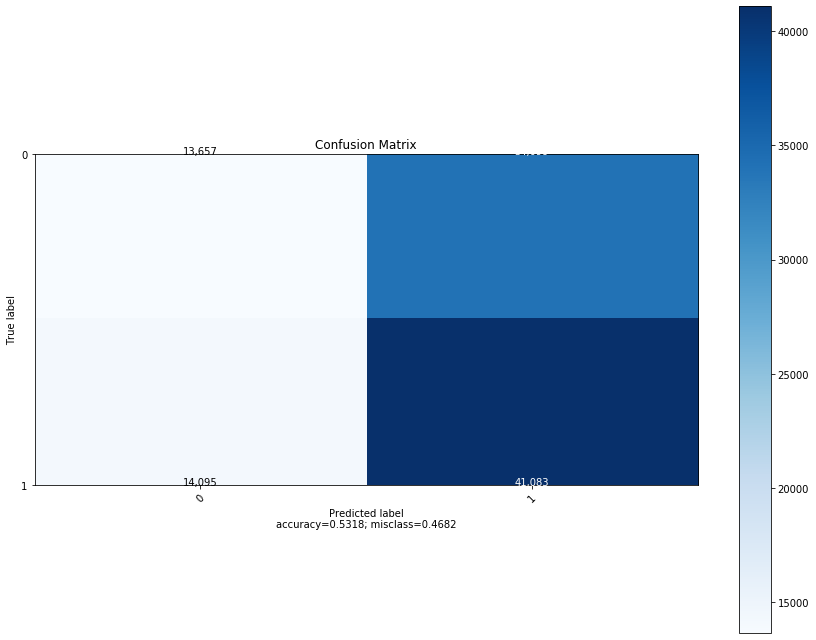

In [232]:
#cm = confusion_matrix(val_y, pred_class) #confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

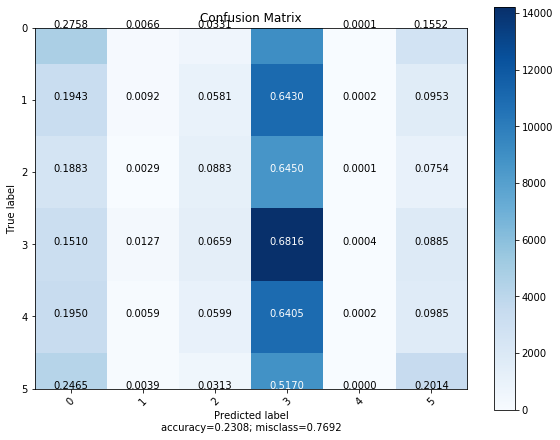

In [211]:
plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix")

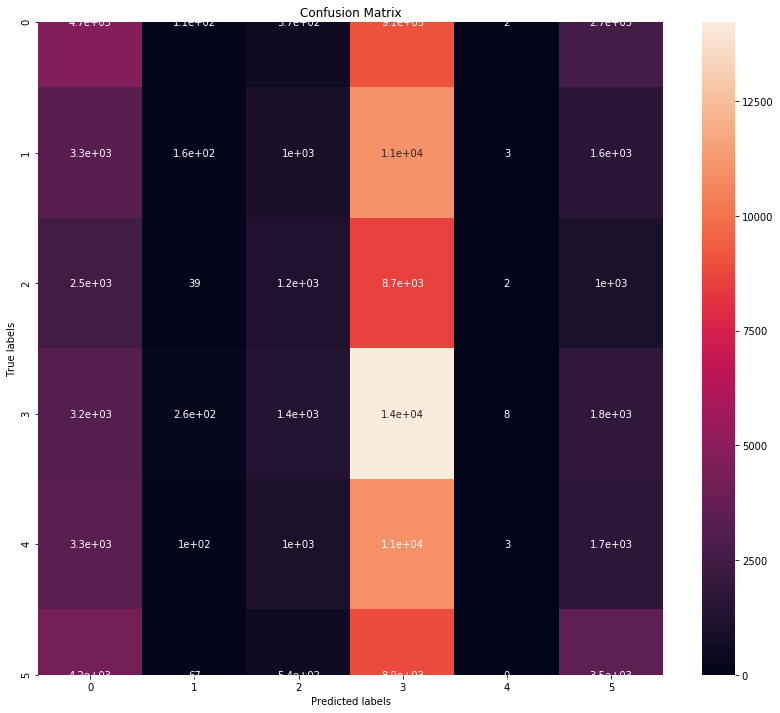

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt     

f, ax= plt.subplots(1,1,figsize=(14,12))
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

# Try the Keras tuner

In [255]:
#!pip install -q -U keras-tuner
#!python -m pip install keras-tuner
import kerastuner as kt
import IPython

In [257]:
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                     max_epochs = 100,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt') 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}.
""")    

INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal 
        L2 ratio is 0.0001 and the optimal learning rate for the optimizer
        is 0.001.



In [260]:
best_hps

In [269]:
tuner.results_summary(1)

TypeError: 'NoneType' object is not subscriptable

In [273]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(validate_ds, val_y)

3217/3217 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.3438 - auc: 0.46 - ETA: 5s - loss: 0.6971 - accuracy: 0.4914 - auc: 0.52 - ETA: 5s - loss: 0.6964 - accuracy: 0.4955 - auc: 0.50 - ETA: 5s - loss: 0.6952 - accuracy: 0.5026 - auc: 0.51 - ETA: 5s - loss: 0.6947 - accuracy: 0.5063 - auc: 0.51 - ETA: 5s - loss: 0.6940 - accuracy: 0.5124 - auc: 0.51 - ETA: 5s - loss: 0.6943 - accuracy: 0.5107 - auc: 0.51 - ETA: 5s - loss: 0.6939 - accuracy: 0.5130 - auc: 0.51 - ETA: 5s - loss: 0.6937 - accuracy: 0.5142 - auc: 0.51 - ETA: 5s - loss: 0.6934 - accuracy: 0.5164 - auc: 0.51 - ETA: 5s - loss: 0.6934 - accuracy: 0.5170 - auc: 0.51 - ETA: 5s - loss: 0.6933 - accuracy: 0.5165 - auc: 0.51 - ETA: 5s - loss: 0.6934 - accuracy: 0.5166 - auc: 0.51 - ETA: 5s - loss: 0.6928 - accuracy: 0.5181 - auc: 0.52 - ETA: 5s - loss: 0.6926 - accuracy: 0.5189 - auc: 0.52 - ETA: 5s - loss: 0.6930 - accuracy: 0.5181 - auc: 0.52 - ETA: 5s - loss: 0.6930 - accuracy: 0.5191 - auc: 0.52 - ETA

[0.6896852850914001, 0.5364311337471008, 0.543425977230072]

In [267]:
tuner.results_summary()

In [264]:
tuner.get_best_models(num_models=1)

In [261]:
tuner.search_space_summary()

### Try the other tuners

In [274]:
# using BayesianOptimization
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

#bayesian.BayesianOptimization
tuner = kt.BayesianOptimization(model_builder,
                                 objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                                 max_trials = 100,
                                 #factor = 3,
                                 directory = 'my_dir_2',
                                 project_name = 'intro_to_kt_2',
                                 seed=123) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = tuner.get_best_models(num_models=1)[0]
res = best_model.evaluate(validate_ds, val_y)

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}. Res is: {res}
""")    



Epoch 1/100


 3027/12867 [======>.......................] - ETA: 0s - loss: 22440.9473 - accuracy: 0.7188 - auc: 0.52 - ETA: 30s - loss: 7593.4287 - accuracy: 0.5506 - auc: 0.50 - ETA: 31s - loss: 4028.6638 - accuracy: 0.5053 - auc: 0.49 - ETA: 29s - loss: 2565.8328 - accuracy: 0.5067 - auc: 0.50 - ETA: 30s - loss: 1963.6013 - accuracy: 0.4938 - auc: 0.50 - ETA: 30s - loss: 1560.1361 - accuracy: 0.4918 - auc: 0.49 - ETA: 30s - loss: 1324.9932 - accuracy: 0.4950 - auc: 0.49 - ETA: 30s - loss: 1143.5842 - accuracy: 0.5047 - auc: 0.49 - ETA: 30s - loss: 999.8717 - accuracy: 0.5052 - auc: 0.4970 - ETA: 30s - loss: 874.3232 - accuracy: 0.5090 - auc: 0.497 - ETA: 29s - loss: 776.8043 - accuracy: 0.5118 - auc: 0.497 - ETA: 29s - loss: 707.7455 - accuracy: 0.5118 - auc: 0.499 - ETA: 30s - loss: 652.5098 - accuracy: 0.5132 - auc: 0.498 - ETA: 30s - loss: 603.0961 - accuracy: 0.5150 - auc: 0.499 - ETA: 30s - loss: 560.6464 - accuracy: 0.5150 - auc: 0.497 - ETA: 30s - loss: 525.4293 - accuracy: 0.5177 - auc: 

 6250/12867 [=============>................] - ETA: 22s - loss: 55.4833 - accuracy: 0.5362 - auc: 0.50 - ETA: 22s - loss: 55.0741 - accuracy: 0.5360 - auc: 0.50 - ETA: 22s - loss: 54.6705 - accuracy: 0.5360 - auc: 0.50 - ETA: 22s - loss: 54.2730 - accuracy: 0.5359 - auc: 0.50 - ETA: 22s - loss: 53.8820 - accuracy: 0.5357 - auc: 0.50 - ETA: 22s - loss: 53.4959 - accuracy: 0.5354 - auc: 0.50 - ETA: 22s - loss: 53.0996 - accuracy: 0.5354 - auc: 0.50 - ETA: 22s - loss: 52.7248 - accuracy: 0.5353 - auc: 0.50 - ETA: 22s - loss: 52.3551 - accuracy: 0.5353 - auc: 0.50 - ETA: 21s - loss: 51.9754 - accuracy: 0.5350 - auc: 0.50 - ETA: 21s - loss: 51.6167 - accuracy: 0.5350 - auc: 0.50 - ETA: 21s - loss: 51.2780 - accuracy: 0.5350 - auc: 0.50 - ETA: 21s - loss: 50.9741 - accuracy: 0.5348 - auc: 0.50 - ETA: 21s - loss: 50.6288 - accuracy: 0.5349 - auc: 0.50 - ETA: 21s - loss: 50.3027 - accuracy: 0.5349 - auc: 0.50 - ETA: 21s - loss: 49.9668 - accuracy: 0.5351 - auc: 0.50 - ETA: 21s - loss: 49.6358 

 9592/12867 [=====================>........] - ETA: 14s - loss: 27.4028 - accuracy: 0.5333 - auc: 0.50 - ETA: 14s - loss: 27.3025 - accuracy: 0.5333 - auc: 0.50 - ETA: 14s - loss: 27.2145 - accuracy: 0.5333 - auc: 0.50 - ETA: 14s - loss: 27.1276 - accuracy: 0.5334 - auc: 0.50 - ETA: 14s - loss: 27.0329 - accuracy: 0.5334 - auc: 0.50 - ETA: 14s - loss: 26.9429 - accuracy: 0.5334 - auc: 0.50 - ETA: 14s - loss: 26.8491 - accuracy: 0.5335 - auc: 0.50 - ETA: 14s - loss: 26.7561 - accuracy: 0.5336 - auc: 0.50 - ETA: 14s - loss: 26.6561 - accuracy: 0.5335 - auc: 0.50 - ETA: 14s - loss: 26.5684 - accuracy: 0.5336 - auc: 0.50 - ETA: 14s - loss: 26.4771 - accuracy: 0.5337 - auc: 0.50 - ETA: 14s - loss: 26.3785 - accuracy: 0.5339 - auc: 0.50 - ETA: 14s - loss: 26.2814 - accuracy: 0.5339 - auc: 0.50 - ETA: 14s - loss: 26.1890 - accuracy: 0.5338 - auc: 0.50 - ETA: 14s - loss: 26.1046 - accuracy: 0.5338 - auc: 0.50 - ETA: 14s - loss: 26.0170 - accuracy: 0.5338 - auc: 0.50 - ETA: 13s - loss: 25.9301 

12867/12867 [==============================] - ETA: 7s - loss: 18.1989 - accuracy: 0.5327 - auc: 0.505 - ETA: 7s - loss: 18.1556 - accuracy: 0.5328 - auc: 0.505 - ETA: 7s - loss: 18.1108 - accuracy: 0.5328 - auc: 0.505 - ETA: 7s - loss: 18.0646 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 18.0206 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.9804 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.9420 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.9058 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.8678 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.8281 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.7859 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.7455 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.7029 - accuracy: 0.5328 - auc: 0.505 - ETA: 6s - loss: 17.6620 - accuracy: 0.5329 - auc: 0.505 - ETA: 6s - loss: 17.6215 - accuracy: 0.5329 - auc: 0.505 - ETA: 6s - loss: 17.5849 - accuracy: 0.5329 - auc: 0.505 - ETA: 6s - loss: 17.5465 -

Epoch 2/100


 3226/12867 [======>.......................] - ETA: 0s - loss: 1.3232 - accuracy: 0.4688 - auc: 0.52 - ETA: 26s - loss: 0.9152 - accuracy: 0.5182 - auc: 0.457 - ETA: 27s - loss: 0.8930 - accuracy: 0.5027 - auc: 0.456 - ETA: 27s - loss: 0.9044 - accuracy: 0.5094 - auc: 0.466 - ETA: 27s - loss: 0.8964 - accuracy: 0.5138 - auc: 0.471 - ETA: 27s - loss: 0.8756 - accuracy: 0.5169 - auc: 0.484 - ETA: 26s - loss: 0.8788 - accuracy: 0.5125 - auc: 0.484 - ETA: 26s - loss: 0.8915 - accuracy: 0.5179 - auc: 0.490 - ETA: 26s - loss: 0.9343 - accuracy: 0.5161 - auc: 0.491 - ETA: 27s - loss: 0.9294 - accuracy: 0.5168 - auc: 0.492 - ETA: 26s - loss: 0.9256 - accuracy: 0.5170 - auc: 0.494 - ETA: 26s - loss: 0.9260 - accuracy: 0.5177 - auc: 0.497 - ETA: 26s - loss: 0.9264 - accuracy: 0.5200 - auc: 0.495 - ETA: 26s - loss: 0.9230 - accuracy: 0.5207 - auc: 0.497 - ETA: 26s - loss: 0.9176 - accuracy: 0.5220 - auc: 0.498 - ETA: 26s - loss: 0.9132 - accuracy: 0.5237 - auc: 0.500 - ETA: 26s - loss: 0.9077 - a

 6907/12867 [===============>..............] - ETA: 21s - loss: 0.9212 - accuracy: 0.5312 - auc: 0.501 - ETA: 21s - loss: 0.9225 - accuracy: 0.5312 - auc: 0.501 - ETA: 20s - loss: 0.9234 - accuracy: 0.5314 - auc: 0.501 - ETA: 20s - loss: 0.9233 - accuracy: 0.5313 - auc: 0.501 - ETA: 20s - loss: 0.9236 - accuracy: 0.5314 - auc: 0.501 - ETA: 20s - loss: 0.9237 - accuracy: 0.5312 - auc: 0.501 - ETA: 20s - loss: 0.9227 - accuracy: 0.5311 - auc: 0.502 - ETA: 20s - loss: 0.9231 - accuracy: 0.5311 - auc: 0.502 - ETA: 20s - loss: 0.9232 - accuracy: 0.5312 - auc: 0.501 - ETA: 20s - loss: 0.9229 - accuracy: 0.5312 - auc: 0.501 - ETA: 20s - loss: 0.9235 - accuracy: 0.5310 - auc: 0.502 - ETA: 20s - loss: 0.9232 - accuracy: 0.5308 - auc: 0.502 - ETA: 20s - loss: 0.9230 - accuracy: 0.5308 - auc: 0.502 - ETA: 20s - loss: 0.9244 - accuracy: 0.5309 - auc: 0.502 - ETA: 20s - loss: 0.9237 - accuracy: 0.5310 - auc: 0.502 - ETA: 19s - loss: 0.9231 - accuracy: 0.5311 - auc: 0.502 - ETA: 19s - loss: 0.9226 -

10359/12867 [=======================>......] - ETA: 12s - loss: 0.9274 - accuracy: 0.5312 - auc: 0.503 - ETA: 12s - loss: 0.9272 - accuracy: 0.5314 - auc: 0.503 - ETA: 12s - loss: 0.9268 - accuracy: 0.5313 - auc: 0.503 - ETA: 12s - loss: 0.9266 - accuracy: 0.5314 - auc: 0.503 - ETA: 11s - loss: 0.9270 - accuracy: 0.5314 - auc: 0.503 - ETA: 11s - loss: 0.9267 - accuracy: 0.5314 - auc: 0.503 - ETA: 11s - loss: 0.9267 - accuracy: 0.5313 - auc: 0.503 - ETA: 11s - loss: 0.9265 - accuracy: 0.5314 - auc: 0.503 - ETA: 11s - loss: 0.9265 - accuracy: 0.5313 - auc: 0.503 - ETA: 11s - loss: 0.9263 - accuracy: 0.5313 - auc: 0.503 - ETA: 11s - loss: 0.9264 - accuracy: 0.5312 - auc: 0.503 - ETA: 11s - loss: 0.9272 - accuracy: 0.5310 - auc: 0.503 - ETA: 11s - loss: 0.9270 - accuracy: 0.5310 - auc: 0.503 - ETA: 11s - loss: 0.9270 - accuracy: 0.5309 - auc: 0.503 - ETA: 11s - loss: 0.9270 - accuracy: 0.5308 - auc: 0.503 - ETA: 11s - loss: 0.9269 - accuracy: 0.5308 - auc: 0.503 - ETA: 11s - loss: 0.9269 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9297 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9293 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9296 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9301 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9301 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9299 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9296 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9291 - accuracy: 0.5307 - auc: 0.50 - E

 3182/12867 [======>.......................] - ETA: 0s - loss: 0.9048 - accuracy: 0.5000 - auc: 0.58 - ETA: 30s - loss: 0.8174 - accuracy: 0.5193 - auc: 0.543 - ETA: 29s - loss: 0.8396 - accuracy: 0.5284 - auc: 0.531 - ETA: 28s - loss: 0.8337 - accuracy: 0.5335 - auc: 0.526 - ETA: 28s - loss: 0.8551 - accuracy: 0.5363 - auc: 0.521 - ETA: 28s - loss: 0.8519 - accuracy: 0.5424 - auc: 0.519 - ETA: 28s - loss: 0.8460 - accuracy: 0.5380 - auc: 0.514 - ETA: 28s - loss: 0.8479 - accuracy: 0.5361 - auc: 0.504 - ETA: 27s - loss: 0.8647 - accuracy: 0.5318 - auc: 0.504 - ETA: 27s - loss: 0.8978 - accuracy: 0.5331 - auc: 0.505 - ETA: 27s - loss: 0.9024 - accuracy: 0.5317 - auc: 0.502 - ETA: 27s - loss: 0.9100 - accuracy: 0.5315 - auc: 0.502 - ETA: 27s - loss: 0.9078 - accuracy: 0.5298 - auc: 0.500 - ETA: 27s - loss: 0.9191 - accuracy: 0.5293 - auc: 0.503 - ETA: 27s - loss: 0.9383 - accuracy: 0.5304 - auc: 0.503 - ETA: 27s - loss: 0.9593 - accuracy: 0.5308 - auc: 0.503 - ETA: 27s - loss: 0.9614 - a

 6592/12867 [==============>...............] - ETA: 21s - loss: 0.9317 - accuracy: 0.5327 - auc: 0.504 - ETA: 21s - loss: 0.9311 - accuracy: 0.5327 - auc: 0.504 - ETA: 21s - loss: 0.9312 - accuracy: 0.5323 - auc: 0.504 - ETA: 21s - loss: 0.9304 - accuracy: 0.5323 - auc: 0.504 - ETA: 21s - loss: 0.9304 - accuracy: 0.5322 - auc: 0.504 - ETA: 21s - loss: 0.9300 - accuracy: 0.5321 - auc: 0.504 - ETA: 21s - loss: 0.9299 - accuracy: 0.5319 - auc: 0.503 - ETA: 21s - loss: 0.9297 - accuracy: 0.5320 - auc: 0.504 - ETA: 21s - loss: 0.9296 - accuracy: 0.5319 - auc: 0.504 - ETA: 20s - loss: 0.9308 - accuracy: 0.5318 - auc: 0.503 - ETA: 20s - loss: 0.9310 - accuracy: 0.5319 - auc: 0.503 - ETA: 20s - loss: 0.9314 - accuracy: 0.5320 - auc: 0.504 - ETA: 20s - loss: 0.9315 - accuracy: 0.5321 - auc: 0.504 - ETA: 20s - loss: 0.9309 - accuracy: 0.5320 - auc: 0.504 - ETA: 20s - loss: 0.9308 - accuracy: 0.5318 - auc: 0.504 - ETA: 20s - loss: 0.9300 - accuracy: 0.5318 - auc: 0.503 - ETA: 20s - loss: 0.9302 -

10180/12867 [======================>.......] - ETA: 13s - loss: 0.9320 - accuracy: 0.5313 - auc: 0.504 - ETA: 13s - loss: 0.9317 - accuracy: 0.5314 - auc: 0.504 - ETA: 13s - loss: 0.9312 - accuracy: 0.5313 - auc: 0.504 - ETA: 13s - loss: 0.9314 - accuracy: 0.5312 - auc: 0.504 - ETA: 13s - loss: 0.9319 - accuracy: 0.5311 - auc: 0.504 - ETA: 13s - loss: 0.9319 - accuracy: 0.5309 - auc: 0.504 - ETA: 13s - loss: 0.9318 - accuracy: 0.5309 - auc: 0.504 - ETA: 13s - loss: 0.9316 - accuracy: 0.5310 - auc: 0.504 - ETA: 12s - loss: 0.9316 - accuracy: 0.5310 - auc: 0.504 - ETA: 12s - loss: 0.9319 - accuracy: 0.5309 - auc: 0.503 - ETA: 12s - loss: 0.9325 - accuracy: 0.5308 - auc: 0.503 - ETA: 12s - loss: 0.9330 - accuracy: 0.5308 - auc: 0.503 - ETA: 12s - loss: 0.9332 - accuracy: 0.5307 - auc: 0.503 - ETA: 12s - loss: 0.9328 - accuracy: 0.5307 - auc: 0.503 - ETA: 12s - loss: 0.9326 - accuracy: 0.5306 - auc: 0.503 - ETA: 12s - loss: 0.9322 - accuracy: 0.5308 - auc: 0.503 - ETA: 12s - loss: 0.9320 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9341 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9347 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9346 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9348 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9348 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9347 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9345 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9341 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5307 - auc: 0.50 - E

 3270/12867 [======>.......................] - ETA: 0s - loss: 0.8831 - accuracy: 0.5000 - auc: 0.51 - ETA: 24s - loss: 0.8763 - accuracy: 0.5168 - auc: 0.491 - ETA: 25s - loss: 0.8966 - accuracy: 0.5319 - auc: 0.506 - ETA: 26s - loss: 0.9227 - accuracy: 0.5334 - auc: 0.506 - ETA: 27s - loss: 1.0074 - accuracy: 0.5279 - auc: 0.508 - ETA: 27s - loss: 0.9873 - accuracy: 0.5214 - auc: 0.500 - ETA: 27s - loss: 0.9761 - accuracy: 0.5235 - auc: 0.504 - ETA: 27s - loss: 0.9912 - accuracy: 0.5254 - auc: 0.502 - ETA: 26s - loss: 1.0394 - accuracy: 0.5243 - auc: 0.500 - ETA: 26s - loss: 1.0384 - accuracy: 0.5250 - auc: 0.503 - ETA: 26s - loss: 1.0319 - accuracy: 0.5250 - auc: 0.502 - ETA: 26s - loss: 1.0141 - accuracy: 0.5283 - auc: 0.502 - ETA: 26s - loss: 1.0040 - accuracy: 0.5281 - auc: 0.501 - ETA: 26s - loss: 0.9954 - accuracy: 0.5291 - auc: 0.502 - ETA: 25s - loss: 0.9986 - accuracy: 0.5297 - auc: 0.504 - ETA: 25s - loss: 1.0040 - accuracy: 0.5310 - auc: 0.506 - ETA: 25s - loss: 1.0042 - a

 6569/12867 [==============>...............] - ETA: 20s - loss: 0.9344 - accuracy: 0.5304 - auc: 0.506 - ETA: 20s - loss: 0.9352 - accuracy: 0.5304 - auc: 0.506 - ETA: 20s - loss: 0.9343 - accuracy: 0.5307 - auc: 0.506 - ETA: 20s - loss: 0.9338 - accuracy: 0.5306 - auc: 0.506 - ETA: 20s - loss: 0.9343 - accuracy: 0.5306 - auc: 0.506 - ETA: 20s - loss: 0.9335 - accuracy: 0.5305 - auc: 0.506 - ETA: 20s - loss: 0.9332 - accuracy: 0.5303 - auc: 0.506 - ETA: 20s - loss: 0.9325 - accuracy: 0.5304 - auc: 0.507 - ETA: 20s - loss: 0.9320 - accuracy: 0.5307 - auc: 0.507 - ETA: 20s - loss: 0.9317 - accuracy: 0.5307 - auc: 0.507 - ETA: 20s - loss: 0.9320 - accuracy: 0.5306 - auc: 0.507 - ETA: 20s - loss: 0.9331 - accuracy: 0.5306 - auc: 0.507 - ETA: 20s - loss: 0.9341 - accuracy: 0.5305 - auc: 0.507 - ETA: 20s - loss: 0.9341 - accuracy: 0.5304 - auc: 0.507 - ETA: 20s - loss: 0.9336 - accuracy: 0.5303 - auc: 0.506 - ETA: 19s - loss: 0.9353 - accuracy: 0.5302 - auc: 0.506 - ETA: 19s - loss: 0.9352 -

 9904/12867 [======================>.......] - ETA: 13s - loss: 0.9383 - accuracy: 0.5294 - auc: 0.504 - ETA: 13s - loss: 0.9382 - accuracy: 0.5293 - auc: 0.504 - ETA: 13s - loss: 0.9378 - accuracy: 0.5294 - auc: 0.504 - ETA: 13s - loss: 0.9388 - accuracy: 0.5294 - auc: 0.504 - ETA: 13s - loss: 0.9388 - accuracy: 0.5293 - auc: 0.504 - ETA: 13s - loss: 0.9387 - accuracy: 0.5295 - auc: 0.504 - ETA: 13s - loss: 0.9386 - accuracy: 0.5295 - auc: 0.505 - ETA: 13s - loss: 0.9385 - accuracy: 0.5294 - auc: 0.504 - ETA: 13s - loss: 0.9387 - accuracy: 0.5296 - auc: 0.504 - ETA: 13s - loss: 0.9388 - accuracy: 0.5295 - auc: 0.504 - ETA: 13s - loss: 0.9384 - accuracy: 0.5295 - auc: 0.504 - ETA: 13s - loss: 0.9380 - accuracy: 0.5295 - auc: 0.504 - ETA: 13s - loss: 0.9381 - accuracy: 0.5294 - auc: 0.504 - ETA: 12s - loss: 0.9379 - accuracy: 0.5295 - auc: 0.504 - ETA: 12s - loss: 0.9375 - accuracy: 0.5295 - auc: 0.504 - ETA: 12s - loss: 0.9374 - accuracy: 0.5295 - auc: 0.504 - ETA: 12s - loss: 0.9377 -

12867/12867 [==============================] - ETA: 6s - loss: 0.9348 - accuracy: 0.5297 - auc: 0.50 - ETA: 6s - loss: 0.9350 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9349 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9347 - accuracy: 0.5295 - auc: 0.50 - ETA: 6s - loss: 0.9348 - accuracy: 0.5295 - auc: 0.50 - ETA: 6s - loss: 0.9348 - accuracy: 0.5295 - auc: 0.50 - ETA: 6s - loss: 0.9351 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9352 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9351 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9349 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9347 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9345 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9345 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9352 - accuracy: 0.5295 - auc: 0.50 - E

 3615/12867 [=======>......................] - ETA: 0s - loss: 1.1031 - accuracy: 0.6250 - auc: 0.52 - ETA: 23s - loss: 0.8243 - accuracy: 0.5513 - auc: 0.549 - ETA: 24s - loss: 0.8320 - accuracy: 0.5451 - auc: 0.541 - ETA: 24s - loss: 0.9017 - accuracy: 0.5371 - auc: 0.523 - ETA: 24s - loss: 0.9085 - accuracy: 0.5333 - auc: 0.520 - ETA: 24s - loss: 0.8913 - accuracy: 0.5340 - auc: 0.519 - ETA: 23s - loss: 0.8752 - accuracy: 0.5378 - auc: 0.517 - ETA: 23s - loss: 0.8864 - accuracy: 0.5377 - auc: 0.518 - ETA: 24s - loss: 0.9043 - accuracy: 0.5405 - auc: 0.518 - ETA: 24s - loss: 0.9183 - accuracy: 0.5407 - auc: 0.517 - ETA: 24s - loss: 0.9059 - accuracy: 0.5401 - auc: 0.521 - ETA: 24s - loss: 0.9012 - accuracy: 0.5416 - auc: 0.520 - ETA: 25s - loss: 0.8976 - accuracy: 0.5421 - auc: 0.518 - ETA: 25s - loss: 0.8961 - accuracy: 0.5403 - auc: 0.517 - ETA: 25s - loss: 0.8957 - accuracy: 0.5422 - auc: 0.519 - ETA: 26s - loss: 0.8971 - accuracy: 0.5418 - auc: 0.517 - ETA: 26s - loss: 0.8936 - a

 7299/12867 [================>.............] - ETA: 18s - loss: 0.9292 - accuracy: 0.5349 - auc: 0.508 - ETA: 17s - loss: 0.9297 - accuracy: 0.5349 - auc: 0.508 - ETA: 17s - loss: 0.9290 - accuracy: 0.5349 - auc: 0.508 - ETA: 17s - loss: 0.9281 - accuracy: 0.5349 - auc: 0.508 - ETA: 17s - loss: 0.9287 - accuracy: 0.5348 - auc: 0.508 - ETA: 17s - loss: 0.9297 - accuracy: 0.5347 - auc: 0.508 - ETA: 17s - loss: 0.9304 - accuracy: 0.5347 - auc: 0.508 - ETA: 17s - loss: 0.9304 - accuracy: 0.5347 - auc: 0.508 - ETA: 17s - loss: 0.9298 - accuracy: 0.5347 - auc: 0.508 - ETA: 17s - loss: 0.9288 - accuracy: 0.5346 - auc: 0.508 - ETA: 17s - loss: 0.9286 - accuracy: 0.5346 - auc: 0.508 - ETA: 17s - loss: 0.9285 - accuracy: 0.5346 - auc: 0.509 - ETA: 17s - loss: 0.9283 - accuracy: 0.5347 - auc: 0.509 - ETA: 17s - loss: 0.9291 - accuracy: 0.5348 - auc: 0.509 - ETA: 17s - loss: 0.9302 - accuracy: 0.5345 - auc: 0.509 - ETA: 17s - loss: 0.9299 - accuracy: 0.5344 - auc: 0.508 - ETA: 17s - loss: 0.9297 -

10997/12867 [========================>.....] - ETA: 10s - loss: 0.9332 - accuracy: 0.5327 - auc: 0.508 - ETA: 10s - loss: 0.9333 - accuracy: 0.5326 - auc: 0.508 - ETA: 10s - loss: 0.9335 - accuracy: 0.5327 - auc: 0.508 - ETA: 10s - loss: 0.9340 - accuracy: 0.5326 - auc: 0.508 - ETA: 10s - loss: 0.9335 - accuracy: 0.5326 - auc: 0.508 - ETA: 10s - loss: 0.9332 - accuracy: 0.5325 - auc: 0.508 - ETA: 10s - loss: 0.9329 - accuracy: 0.5325 - auc: 0.508 - ETA: 10s - loss: 0.9327 - accuracy: 0.5324 - auc: 0.508 - ETA: 10s - loss: 0.9328 - accuracy: 0.5324 - auc: 0.507 - ETA: 10s - loss: 0.9334 - accuracy: 0.5324 - auc: 0.507 - ETA: 10s - loss: 0.9339 - accuracy: 0.5322 - auc: 0.507 - ETA: 10s - loss: 0.9345 - accuracy: 0.5321 - auc: 0.507 - ETA: 10s - loss: 0.9344 - accuracy: 0.5321 - auc: 0.507 - ETA: 10s - loss: 0.9341 - accuracy: 0.5321 - auc: 0.507 - ETA: 10s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.507 - ETA: 10s - loss: 0.9332 - accuracy: 0.5321 - auc: 0.507 - ETA: 10s - loss: 0.9328 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9341 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9337 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9346 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9356 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9354 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9348 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9345 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5310 - auc: 0.50 - E

 3394/12867 [======>.......................] - ETA: 0s - loss: 0.7658 - accuracy: 0.4062 - auc: 0.53 - ETA: 22s - loss: 0.9935 - accuracy: 0.5368 - auc: 0.529 - ETA: 23s - loss: 0.9238 - accuracy: 0.5463 - auc: 0.514 - ETA: 23s - loss: 0.9519 - accuracy: 0.5377 - auc: 0.505 - ETA: 23s - loss: 0.9341 - accuracy: 0.5361 - auc: 0.505 - ETA: 23s - loss: 0.9323 - accuracy: 0.5388 - auc: 0.509 - ETA: 23s - loss: 0.9401 - accuracy: 0.5422 - auc: 0.508 - ETA: 23s - loss: 0.9236 - accuracy: 0.5452 - auc: 0.506 - ETA: 23s - loss: 0.9771 - accuracy: 0.5403 - auc: 0.504 - ETA: 23s - loss: 0.9891 - accuracy: 0.5373 - auc: 0.505 - ETA: 23s - loss: 1.0023 - accuracy: 0.5347 - auc: 0.501 - ETA: 23s - loss: 0.9926 - accuracy: 0.5360 - auc: 0.502 - ETA: 23s - loss: 0.9806 - accuracy: 0.5380 - auc: 0.502 - ETA: 23s - loss: 0.9770 - accuracy: 0.5375 - auc: 0.503 - ETA: 23s - loss: 0.9701 - accuracy: 0.5358 - auc: 0.501 - ETA: 23s - loss: 0.9622 - accuracy: 0.5358 - auc: 0.503 - ETA: 23s - loss: 0.9596 - a

 6812/12867 [==============>...............] - ETA: 19s - loss: 0.9568 - accuracy: 0.5323 - auc: 0.506 - ETA: 19s - loss: 0.9565 - accuracy: 0.5324 - auc: 0.506 - ETA: 19s - loss: 0.9556 - accuracy: 0.5326 - auc: 0.506 - ETA: 19s - loss: 0.9543 - accuracy: 0.5326 - auc: 0.506 - ETA: 19s - loss: 0.9539 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9534 - accuracy: 0.5327 - auc: 0.505 - ETA: 19s - loss: 0.9526 - accuracy: 0.5327 - auc: 0.505 - ETA: 19s - loss: 0.9523 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9516 - accuracy: 0.5326 - auc: 0.506 - ETA: 19s - loss: 0.9513 - accuracy: 0.5325 - auc: 0.505 - ETA: 19s - loss: 0.9506 - accuracy: 0.5326 - auc: 0.505 - ETA: 19s - loss: 0.9512 - accuracy: 0.5326 - auc: 0.506 - ETA: 19s - loss: 0.9511 - accuracy: 0.5328 - auc: 0.506 - ETA: 19s - loss: 0.9505 - accuracy: 0.5327 - auc: 0.505 - ETA: 19s - loss: 0.9501 - accuracy: 0.5325 - auc: 0.505 - ETA: 19s - loss: 0.9504 - accuracy: 0.5325 - auc: 0.505 - ETA: 18s - loss: 0.9509 -

10311/12867 [=======================>......] - ETA: 12s - loss: 0.9396 - accuracy: 0.5305 - auc: 0.505 - ETA: 12s - loss: 0.9395 - accuracy: 0.5306 - auc: 0.505 - ETA: 12s - loss: 0.9391 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9393 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9390 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9391 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9389 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9388 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9387 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9395 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9394 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9393 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9393 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9401 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9401 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9400 - accuracy: 0.5307 - auc: 0.505 - ETA: 11s - loss: 0.9401 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9361 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9361 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9359 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9357 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9356 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9354 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9352 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9351 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9355 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9353 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9354 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9359 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9356 - accuracy: 0.5310 - auc: 0.50 - E

 3377/12867 [======>.......................] - ETA: 0s - loss: 0.8925 - accuracy: 0.5000 - auc: 0.36 - ETA: 24s - loss: 1.1243 - accuracy: 0.5084 - auc: 0.495 - ETA: 25s - loss: 1.0820 - accuracy: 0.5206 - auc: 0.493 - ETA: 25s - loss: 1.0840 - accuracy: 0.5225 - auc: 0.500 - ETA: 26s - loss: 1.0260 - accuracy: 0.5226 - auc: 0.504 - ETA: 25s - loss: 1.0293 - accuracy: 0.5237 - auc: 0.504 - ETA: 25s - loss: 0.9902 - accuracy: 0.5300 - auc: 0.506 - ETA: 25s - loss: 0.9630 - accuracy: 0.5336 - auc: 0.507 - ETA: 25s - loss: 0.9496 - accuracy: 0.5369 - auc: 0.507 - ETA: 25s - loss: 0.9406 - accuracy: 0.5387 - auc: 0.507 - ETA: 25s - loss: 0.9326 - accuracy: 0.5396 - auc: 0.508 - ETA: 25s - loss: 0.9240 - accuracy: 0.5406 - auc: 0.510 - ETA: 25s - loss: 0.9157 - accuracy: 0.5398 - auc: 0.511 - ETA: 25s - loss: 0.9116 - accuracy: 0.5393 - auc: 0.510 - ETA: 25s - loss: 0.9242 - accuracy: 0.5392 - auc: 0.511 - ETA: 25s - loss: 0.9331 - accuracy: 0.5385 - auc: 0.512 - ETA: 25s - loss: 0.9546 - a

 6662/12867 [==============>...............] - ETA: 19s - loss: 0.9434 - accuracy: 0.5314 - auc: 0.505 - ETA: 19s - loss: 0.9426 - accuracy: 0.5314 - auc: 0.505 - ETA: 19s - loss: 0.9418 - accuracy: 0.5316 - auc: 0.505 - ETA: 19s - loss: 0.9431 - accuracy: 0.5316 - auc: 0.505 - ETA: 19s - loss: 0.9432 - accuracy: 0.5317 - auc: 0.505 - ETA: 19s - loss: 0.9424 - accuracy: 0.5317 - auc: 0.505 - ETA: 19s - loss: 0.9429 - accuracy: 0.5318 - auc: 0.505 - ETA: 19s - loss: 0.9427 - accuracy: 0.5316 - auc: 0.505 - ETA: 19s - loss: 0.9431 - accuracy: 0.5315 - auc: 0.505 - ETA: 19s - loss: 0.9436 - accuracy: 0.5313 - auc: 0.505 - ETA: 19s - loss: 0.9441 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9445 - accuracy: 0.5312 - auc: 0.505 - ETA: 19s - loss: 0.9458 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9453 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9450 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9445 - accuracy: 0.5312 - auc: 0.505 - ETA: 19s - loss: 0.9438 -

10061/12867 [======================>.......] - ETA: 13s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.504 - ETA: 13s - loss: 0.9382 - accuracy: 0.5305 - auc: 0.504 - ETA: 13s - loss: 0.9381 - accuracy: 0.5305 - auc: 0.504 - ETA: 13s - loss: 0.9378 - accuracy: 0.5305 - auc: 0.504 - ETA: 13s - loss: 0.9376 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9372 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9386 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9387 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9388 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9398 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9400 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9398 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9395 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9393 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9390 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9388 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9338 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9346 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - E

 3299/12867 [======>.......................] - ETA: 0s - loss: 0.7359 - accuracy: 0.5938 - auc: 0.53 - ETA: 25s - loss: 0.9185 - accuracy: 0.5350 - auc: 0.491 - ETA: 26s - loss: 0.9819 - accuracy: 0.5364 - auc: 0.527 - ETA: 26s - loss: 0.9855 - accuracy: 0.5262 - auc: 0.522 - ETA: 27s - loss: 0.9596 - accuracy: 0.5270 - auc: 0.520 - ETA: 26s - loss: 0.9440 - accuracy: 0.5326 - auc: 0.521 - ETA: 26s - loss: 0.9533 - accuracy: 0.5347 - auc: 0.523 - ETA: 27s - loss: 0.9426 - accuracy: 0.5354 - auc: 0.521 - ETA: 26s - loss: 0.9381 - accuracy: 0.5359 - auc: 0.521 - ETA: 26s - loss: 0.9519 - accuracy: 0.5302 - auc: 0.516 - ETA: 26s - loss: 0.9510 - accuracy: 0.5290 - auc: 0.514 - ETA: 26s - loss: 0.9673 - accuracy: 0.5273 - auc: 0.509 - ETA: 26s - loss: 0.9605 - accuracy: 0.5273 - auc: 0.509 - ETA: 26s - loss: 0.9475 - accuracy: 0.5255 - auc: 0.509 - ETA: 26s - loss: 0.9439 - accuracy: 0.5257 - auc: 0.508 - ETA: 26s - loss: 0.9409 - accuracy: 0.5279 - auc: 0.510 - ETA: 26s - loss: 0.9455 - a

 6646/12867 [==============>...............] - ETA: 20s - loss: 0.9322 - accuracy: 0.5309 - auc: 0.504 - ETA: 20s - loss: 0.9313 - accuracy: 0.5308 - auc: 0.504 - ETA: 20s - loss: 0.9306 - accuracy: 0.5310 - auc: 0.504 - ETA: 20s - loss: 0.9302 - accuracy: 0.5310 - auc: 0.504 - ETA: 20s - loss: 0.9299 - accuracy: 0.5310 - auc: 0.504 - ETA: 20s - loss: 0.9292 - accuracy: 0.5312 - auc: 0.504 - ETA: 20s - loss: 0.9286 - accuracy: 0.5311 - auc: 0.504 - ETA: 20s - loss: 0.9285 - accuracy: 0.5309 - auc: 0.504 - ETA: 20s - loss: 0.9277 - accuracy: 0.5311 - auc: 0.504 - ETA: 20s - loss: 0.9292 - accuracy: 0.5310 - auc: 0.504 - ETA: 20s - loss: 0.9297 - accuracy: 0.5309 - auc: 0.504 - ETA: 20s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.504 - ETA: 20s - loss: 0.9293 - accuracy: 0.5310 - auc: 0.504 - ETA: 19s - loss: 0.9287 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9294 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9321 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9320 -

10174/12867 [======================>.......] - ETA: 13s - loss: 0.9338 - accuracy: 0.5298 - auc: 0.503 - ETA: 13s - loss: 0.9334 - accuracy: 0.5298 - auc: 0.503 - ETA: 13s - loss: 0.9330 - accuracy: 0.5298 - auc: 0.503 - ETA: 13s - loss: 0.9339 - accuracy: 0.5297 - auc: 0.503 - ETA: 13s - loss: 0.9338 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9338 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9334 - accuracy: 0.5299 - auc: 0.503 - ETA: 12s - loss: 0.9330 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9326 - accuracy: 0.5301 - auc: 0.503 - ETA: 12s - loss: 0.9326 - accuracy: 0.5301 - auc: 0.503 - ETA: 12s - loss: 0.9338 - accuracy: 0.5301 - auc: 0.503 - ETA: 12s - loss: 0.9362 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9371 - accuracy: 0.5299 - auc: 0.503 - ETA: 12s - loss: 0.9374 - accuracy: 0.5301 - auc: 0.504 - ETA: 12s - loss: 0.9389 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9400 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9398 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9352 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9349 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9345 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9335 - accuracy: 0.5311 - auc: 0.50 - E

 3398/12867 [======>.......................] - ETA: 0s - loss: 0.9340 - accuracy: 0.4062 - auc: 0.34 - ETA: 26s - loss: 0.8978 - accuracy: 0.5182 - auc: 0.481 - ETA: 27s - loss: 0.9331 - accuracy: 0.5149 - auc: 0.485 - ETA: 28s - loss: 0.9018 - accuracy: 0.5262 - auc: 0.502 - ETA: 28s - loss: 0.9044 - accuracy: 0.5302 - auc: 0.498 - ETA: 27s - loss: 0.9132 - accuracy: 0.5321 - auc: 0.504 - ETA: 27s - loss: 0.9386 - accuracy: 0.5283 - auc: 0.505 - ETA: 27s - loss: 0.9334 - accuracy: 0.5286 - auc: 0.506 - ETA: 26s - loss: 0.9426 - accuracy: 0.5271 - auc: 0.508 - ETA: 26s - loss: 0.9406 - accuracy: 0.5256 - auc: 0.507 - ETA: 26s - loss: 0.9363 - accuracy: 0.5264 - auc: 0.508 - ETA: 26s - loss: 0.9338 - accuracy: 0.5275 - auc: 0.506 - ETA: 26s - loss: 0.9330 - accuracy: 0.5302 - auc: 0.508 - ETA: 26s - loss: 0.9463 - accuracy: 0.5312 - auc: 0.511 - ETA: 26s - loss: 0.9476 - accuracy: 0.5299 - auc: 0.510 - ETA: 26s - loss: 0.9505 - accuracy: 0.5288 - auc: 0.510 - ETA: 26s - loss: 0.9453 - a

 6829/12867 [==============>...............] - ETA: 19s - loss: 0.9369 - accuracy: 0.5276 - auc: 0.502 - ETA: 19s - loss: 0.9369 - accuracy: 0.5276 - auc: 0.502 - ETA: 19s - loss: 0.9362 - accuracy: 0.5275 - auc: 0.502 - ETA: 19s - loss: 0.9355 - accuracy: 0.5275 - auc: 0.501 - ETA: 19s - loss: 0.9351 - accuracy: 0.5274 - auc: 0.502 - ETA: 19s - loss: 0.9353 - accuracy: 0.5273 - auc: 0.501 - ETA: 19s - loss: 0.9350 - accuracy: 0.5272 - auc: 0.501 - ETA: 19s - loss: 0.9349 - accuracy: 0.5272 - auc: 0.501 - ETA: 19s - loss: 0.9353 - accuracy: 0.5272 - auc: 0.501 - ETA: 19s - loss: 0.9350 - accuracy: 0.5271 - auc: 0.501 - ETA: 19s - loss: 0.9352 - accuracy: 0.5270 - auc: 0.501 - ETA: 19s - loss: 0.9349 - accuracy: 0.5270 - auc: 0.501 - ETA: 19s - loss: 0.9350 - accuracy: 0.5267 - auc: 0.501 - ETA: 18s - loss: 0.9345 - accuracy: 0.5268 - auc: 0.501 - ETA: 18s - loss: 0.9342 - accuracy: 0.5269 - auc: 0.501 - ETA: 18s - loss: 0.9344 - accuracy: 0.5270 - auc: 0.501 - ETA: 18s - loss: 0.9344 -

10346/12867 [=======================>......] - ETA: 12s - loss: 0.9353 - accuracy: 0.5289 - auc: 0.502 - ETA: 12s - loss: 0.9354 - accuracy: 0.5290 - auc: 0.502 - ETA: 12s - loss: 0.9352 - accuracy: 0.5290 - auc: 0.502 - ETA: 12s - loss: 0.9352 - accuracy: 0.5291 - auc: 0.502 - ETA: 12s - loss: 0.9352 - accuracy: 0.5292 - auc: 0.502 - ETA: 12s - loss: 0.9358 - accuracy: 0.5292 - auc: 0.502 - ETA: 12s - loss: 0.9359 - accuracy: 0.5292 - auc: 0.502 - ETA: 12s - loss: 0.9356 - accuracy: 0.5292 - auc: 0.502 - ETA: 12s - loss: 0.9353 - accuracy: 0.5292 - auc: 0.502 - ETA: 12s - loss: 0.9359 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9357 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9359 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9360 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9360 - accuracy: 0.5293 - auc: 0.503 - ETA: 11s - loss: 0.9368 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9368 - accuracy: 0.5292 - auc: 0.502 - ETA: 11s - loss: 0.9378 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9362 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9360 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9359 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9357 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9355 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9364 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9367 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9368 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9369 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9372 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9369 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9366 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9363 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9361 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9359 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9360 - accuracy: 0.5302 - auc: 0.50 - E

 3375/12867 [======>.......................] - ETA: 12s - loss: 0.8748 - accuracy: 0.5625 - auc: 0.434 - ETA: 25s - loss: 0.9434 - accuracy: 0.5601 - auc: 0.537 - ETA: 25s - loss: 0.8991 - accuracy: 0.5444 - auc: 0.517 - ETA: 25s - loss: 0.8775 - accuracy: 0.5392 - auc: 0.510 - ETA: 25s - loss: 0.8723 - accuracy: 0.5347 - auc: 0.499 - ETA: 25s - loss: 0.8914 - accuracy: 0.5320 - auc: 0.501 - ETA: 26s - loss: 0.9034 - accuracy: 0.5327 - auc: 0.508 - ETA: 26s - loss: 0.9082 - accuracy: 0.5325 - auc: 0.511 - ETA: 25s - loss: 0.9258 - accuracy: 0.5332 - auc: 0.510 - ETA: 25s - loss: 0.9176 - accuracy: 0.5354 - auc: 0.513 - ETA: 25s - loss: 0.9224 - accuracy: 0.5357 - auc: 0.514 - ETA: 25s - loss: 0.9151 - accuracy: 0.5352 - auc: 0.511 - ETA: 25s - loss: 0.9115 - accuracy: 0.5360 - auc: 0.510 - ETA: 25s - loss: 0.9216 - accuracy: 0.5383 - auc: 0.513 - ETA: 25s - loss: 0.9219 - accuracy: 0.5376 - auc: 0.513 - ETA: 25s - loss: 0.9276 - accuracy: 0.5382 - auc: 0.512 - ETA: 25s - loss: 0.9223 -

 6784/12867 [==============>...............] - ETA: 19s - loss: 0.9369 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9367 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9361 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9352 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9346 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9342 - accuracy: 0.5304 - auc: 0.505 - ETA: 19s - loss: 0.9346 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9337 - accuracy: 0.5299 - auc: 0.505 - ETA: 19s - loss: 0.9333 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9326 - accuracy: 0.5299 - auc: 0.505 - ETA: 19s - loss: 0.9319 - accuracy: 0.5297 - auc: 0.505 - ETA: 19s - loss: 0.9325 - accuracy: 0.5297 - auc: 0.506 - ETA: 19s - loss: 0.9320 - accuracy: 0.5297 - auc: 0.506 - ETA: 19s - loss: 0.9316 - accuracy: 0.5296 - auc: 0.506 - ETA: 19s - loss: 0.9309 - accuracy: 0.5295 - auc: 0.506 - ETA: 19s - loss: 0.9310 - accuracy: 0.5293 - auc: 0.506 - ETA: 18s - loss: 0.9317 -

10303/12867 [=======================>......] - ETA: 12s - loss: 0.9322 - accuracy: 0.5291 - auc: 0.504 - ETA: 12s - loss: 0.9320 - accuracy: 0.5290 - auc: 0.504 - ETA: 12s - loss: 0.9317 - accuracy: 0.5291 - auc: 0.504 - ETA: 12s - loss: 0.9318 - accuracy: 0.5292 - auc: 0.504 - ETA: 12s - loss: 0.9316 - accuracy: 0.5292 - auc: 0.504 - ETA: 12s - loss: 0.9313 - accuracy: 0.5294 - auc: 0.504 - ETA: 12s - loss: 0.9312 - accuracy: 0.5294 - auc: 0.504 - ETA: 12s - loss: 0.9313 - accuracy: 0.5295 - auc: 0.504 - ETA: 12s - loss: 0.9322 - accuracy: 0.5294 - auc: 0.504 - ETA: 12s - loss: 0.9323 - accuracy: 0.5296 - auc: 0.504 - ETA: 12s - loss: 0.9321 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9323 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9320 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9316 - accuracy: 0.5296 - auc: 0.505 - ETA: 11s - loss: 0.9314 - accuracy: 0.5296 - auc: 0.504 - ETA: 11s - loss: 0.9312 - accuracy: 0.5296 - auc: 0.504 - ETA: 11s - loss: 0.9318 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9292 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9300 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9298 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9297 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9298 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9295 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9297 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9296 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5299 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5299 - auc: 0.50 - E

 3375/12867 [======>.......................] - ETA: 0s - loss: 0.7741 - accuracy: 0.5938 - auc: 0.43 - ETA: 24s - loss: 1.0314 - accuracy: 0.5240 - auc: 0.486 - ETA: 24s - loss: 1.0243 - accuracy: 0.5276 - auc: 0.495 - ETA: 25s - loss: 1.0183 - accuracy: 0.5230 - auc: 0.488 - ETA: 25s - loss: 1.0343 - accuracy: 0.5254 - auc: 0.490 - ETA: 25s - loss: 1.0093 - accuracy: 0.5347 - auc: 0.501 - ETA: 25s - loss: 1.0023 - accuracy: 0.5358 - auc: 0.501 - ETA: 25s - loss: 0.9808 - accuracy: 0.5334 - auc: 0.502 - ETA: 25s - loss: 0.9795 - accuracy: 0.5316 - auc: 0.500 - ETA: 25s - loss: 0.9733 - accuracy: 0.5283 - auc: 0.502 - ETA: 25s - loss: 0.9570 - accuracy: 0.5304 - auc: 0.507 - ETA: 25s - loss: 0.9514 - accuracy: 0.5322 - auc: 0.506 - ETA: 25s - loss: 0.9716 - accuracy: 0.5306 - auc: 0.504 - ETA: 25s - loss: 0.9659 - accuracy: 0.5299 - auc: 0.505 - ETA: 25s - loss: 0.9593 - accuracy: 0.5306 - auc: 0.504 - ETA: 26s - loss: 0.9622 - accuracy: 0.5312 - auc: 0.503 - ETA: 26s - loss: 0.9627 - a

 6834/12867 [==============>...............] - ETA: 19s - loss: 0.9262 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9260 - accuracy: 0.5329 - auc: 0.506 - ETA: 19s - loss: 0.9261 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9262 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9262 - accuracy: 0.5329 - auc: 0.506 - ETA: 19s - loss: 0.9260 - accuracy: 0.5331 - auc: 0.506 - ETA: 19s - loss: 0.9272 - accuracy: 0.5329 - auc: 0.506 - ETA: 19s - loss: 0.9274 - accuracy: 0.5328 - auc: 0.506 - ETA: 19s - loss: 0.9272 - accuracy: 0.5328 - auc: 0.506 - ETA: 19s - loss: 0.9272 - accuracy: 0.5329 - auc: 0.506 - ETA: 19s - loss: 0.9269 - accuracy: 0.5328 - auc: 0.506 - ETA: 19s - loss: 0.9269 - accuracy: 0.5327 - auc: 0.506 - ETA: 19s - loss: 0.9268 - accuracy: 0.5328 - auc: 0.506 - ETA: 19s - loss: 0.9282 - accuracy: 0.5326 - auc: 0.506 - ETA: 19s - loss: 0.9315 - accuracy: 0.5323 - auc: 0.505 - ETA: 19s - loss: 0.9310 - accuracy: 0.5325 - auc: 0.506 - ETA: 18s - loss: 0.9306 -

10379/12867 [=======================>......] - ETA: 12s - loss: 0.9349 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9350 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9350 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9359 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9367 - accuracy: 0.5315 - auc: 0.504 - ETA: 12s - loss: 0.9364 - accuracy: 0.5315 - auc: 0.504 - ETA: 12s - loss: 0.9367 - accuracy: 0.5315 - auc: 0.504 - ETA: 12s - loss: 0.9365 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9364 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9362 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9361 - accuracy: 0.5315 - auc: 0.504 - ETA: 11s - loss: 0.9361 - accuracy: 0.5317 - auc: 0.504 - ETA: 11s - loss: 0.9361 - accuracy: 0.5316 - auc: 0.504 - ETA: 11s - loss: 0.9362 - accuracy: 0.5316 - auc: 0.504 - ETA: 11s - loss: 0.9363 - accuracy: 0.5315 - auc: 0.504 - ETA: 11s - loss: 0.9366 - accuracy: 0.5314 - auc: 0.504 - ETA: 11s - loss: 0.9365 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9333 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5315 - auc: 0.50 - ETA: 4s - loss: 0.9334 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9338 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9339 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9346 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9345 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9337 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9334 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9333 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9335 - accuracy: 0.5314 - auc: 0.50 - E

 3408/12867 [======>.......................] - ETA: 0s - loss: 0.7540 - accuracy: 0.6562 - auc: 0.58 - ETA: 25s - loss: 0.9193 - accuracy: 0.5601 - auc: 0.492 - ETA: 26s - loss: 0.8745 - accuracy: 0.5487 - auc: 0.479 - ETA: 25s - loss: 0.8566 - accuracy: 0.5345 - auc: 0.474 - ETA: 26s - loss: 0.8533 - accuracy: 0.5328 - auc: 0.474 - ETA: 26s - loss: 0.8607 - accuracy: 0.5297 - auc: 0.481 - ETA: 26s - loss: 0.8713 - accuracy: 0.5304 - auc: 0.488 - ETA: 26s - loss: 0.8865 - accuracy: 0.5301 - auc: 0.489 - ETA: 26s - loss: 0.8967 - accuracy: 0.5274 - auc: 0.489 - ETA: 26s - loss: 0.9093 - accuracy: 0.5293 - auc: 0.490 - ETA: 26s - loss: 0.9224 - accuracy: 0.5282 - auc: 0.493 - ETA: 26s - loss: 0.9133 - accuracy: 0.5272 - auc: 0.496 - ETA: 26s - loss: 0.9097 - accuracy: 0.5270 - auc: 0.496 - ETA: 25s - loss: 0.9284 - accuracy: 0.5252 - auc: 0.494 - ETA: 25s - loss: 0.9225 - accuracy: 0.5280 - auc: 0.497 - ETA: 25s - loss: 0.9178 - accuracy: 0.5284 - auc: 0.497 - ETA: 25s - loss: 0.9141 - a

 6841/12867 [==============>...............] - ETA: 19s - loss: 0.9465 - accuracy: 0.5312 - auc: 0.505 - ETA: 19s - loss: 0.9467 - accuracy: 0.5312 - auc: 0.505 - ETA: 19s - loss: 0.9473 - accuracy: 0.5313 - auc: 0.505 - ETA: 19s - loss: 0.9472 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9486 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9494 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9508 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9505 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9512 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9515 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9505 - accuracy: 0.5304 - auc: 0.504 - ETA: 18s - loss: 0.9501 - accuracy: 0.5303 - auc: 0.505 - ETA: 18s - loss: 0.9501 - accuracy: 0.5303 - auc: 0.505 - ETA: 18s - loss: 0.9491 - accuracy: 0.5302 - auc: 0.504 - ETA: 18s - loss: 0.9488 - accuracy: 0.5302 - auc: 0.505 - ETA: 18s - loss: 0.9510 - accuracy: 0.5301 - auc: 0.505 - ETA: 18s - loss: 0.9507 -

10374/12867 [=======================>......] - ETA: 12s - loss: 0.9478 - accuracy: 0.5302 - auc: 0.505 - ETA: 12s - loss: 0.9475 - accuracy: 0.5301 - auc: 0.505 - ETA: 12s - loss: 0.9473 - accuracy: 0.5301 - auc: 0.505 - ETA: 12s - loss: 0.9475 - accuracy: 0.5300 - auc: 0.505 - ETA: 12s - loss: 0.9478 - accuracy: 0.5300 - auc: 0.505 - ETA: 12s - loss: 0.9475 - accuracy: 0.5300 - auc: 0.505 - ETA: 12s - loss: 0.9476 - accuracy: 0.5301 - auc: 0.505 - ETA: 12s - loss: 0.9477 - accuracy: 0.5301 - auc: 0.505 - ETA: 12s - loss: 0.9475 - accuracy: 0.5301 - auc: 0.505 - ETA: 11s - loss: 0.9475 - accuracy: 0.5300 - auc: 0.504 - ETA: 11s - loss: 0.9476 - accuracy: 0.5300 - auc: 0.504 - ETA: 11s - loss: 0.9474 - accuracy: 0.5301 - auc: 0.504 - ETA: 11s - loss: 0.9483 - accuracy: 0.5301 - auc: 0.504 - ETA: 11s - loss: 0.9484 - accuracy: 0.5300 - auc: 0.504 - ETA: 11s - loss: 0.9486 - accuracy: 0.5301 - auc: 0.504 - ETA: 11s - loss: 0.9484 - accuracy: 0.5301 - auc: 0.504 - ETA: 11s - loss: 0.9487 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9414 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9416 - accuracy: 0.5301 - auc: 0.50 - ETA: 5s - loss: 0.9416 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9412 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9411 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9409 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9413 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9412 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9411 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9410 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9407 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9406 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9408 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9407 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9403 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9405 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9405 - accuracy: 0.5300 - auc: 0.50 - E

 3405/12867 [======>.......................] - ETA: 0s - loss: 0.8817 - accuracy: 0.5000 - auc: 0.40 - ETA: 29s - loss: 0.9482 - accuracy: 0.5597 - auc: 0.527 - ETA: 32s - loss: 0.9471 - accuracy: 0.5625 - auc: 0.521 - ETA: 32s - loss: 0.9123 - accuracy: 0.5553 - auc: 0.516 - ETA: 30s - loss: 0.9142 - accuracy: 0.5408 - auc: 0.507 - ETA: 29s - loss: 0.9071 - accuracy: 0.5420 - auc: 0.503 - ETA: 29s - loss: 0.9394 - accuracy: 0.5367 - auc: 0.498 - ETA: 29s - loss: 0.9262 - accuracy: 0.5333 - auc: 0.498 - ETA: 28s - loss: 0.9110 - accuracy: 0.5342 - auc: 0.499 - ETA: 28s - loss: 0.8966 - accuracy: 0.5362 - auc: 0.505 - ETA: 28s - loss: 0.8940 - accuracy: 0.5347 - auc: 0.504 - ETA: 28s - loss: 0.8889 - accuracy: 0.5357 - auc: 0.505 - ETA: 27s - loss: 0.8816 - accuracy: 0.5361 - auc: 0.506 - ETA: 27s - loss: 0.8834 - accuracy: 0.5329 - auc: 0.506 - ETA: 27s - loss: 0.8835 - accuracy: 0.5331 - auc: 0.504 - ETA: 27s - loss: 0.8907 - accuracy: 0.5336 - auc: 0.502 - ETA: 27s - loss: 0.8966 - a

 6805/12867 [==============>...............] - ETA: 19s - loss: 0.9217 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9213 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9209 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9206 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9198 - accuracy: 0.5313 - auc: 0.503 - ETA: 19s - loss: 0.9190 - accuracy: 0.5315 - auc: 0.503 - ETA: 19s - loss: 0.9195 - accuracy: 0.5315 - auc: 0.503 - ETA: 19s - loss: 0.9198 - accuracy: 0.5315 - auc: 0.503 - ETA: 19s - loss: 0.9191 - accuracy: 0.5316 - auc: 0.503 - ETA: 19s - loss: 0.9188 - accuracy: 0.5315 - auc: 0.503 - ETA: 19s - loss: 0.9187 - accuracy: 0.5317 - auc: 0.503 - ETA: 19s - loss: 0.9210 - accuracy: 0.5316 - auc: 0.503 - ETA: 19s - loss: 0.9220 - accuracy: 0.5318 - auc: 0.503 - ETA: 19s - loss: 0.9226 - accuracy: 0.5318 - auc: 0.502 - ETA: 19s - loss: 0.9232 - accuracy: 0.5319 - auc: 0.503 - ETA: 19s - loss: 0.9240 - accuracy: 0.5319 - auc: 0.503 - ETA: 18s - loss: 0.9269 -

10315/12867 [=======================>......] - ETA: 12s - loss: 0.9255 - accuracy: 0.5310 - auc: 0.501 - ETA: 12s - loss: 0.9257 - accuracy: 0.5311 - auc: 0.502 - ETA: 12s - loss: 0.9255 - accuracy: 0.5312 - auc: 0.502 - ETA: 12s - loss: 0.9251 - accuracy: 0.5313 - auc: 0.502 - ETA: 12s - loss: 0.9248 - accuracy: 0.5313 - auc: 0.502 - ETA: 12s - loss: 0.9243 - accuracy: 0.5313 - auc: 0.502 - ETA: 12s - loss: 0.9243 - accuracy: 0.5313 - auc: 0.502 - ETA: 12s - loss: 0.9240 - accuracy: 0.5313 - auc: 0.502 - ETA: 12s - loss: 0.9241 - accuracy: 0.5314 - auc: 0.502 - ETA: 12s - loss: 0.9239 - accuracy: 0.5314 - auc: 0.502 - ETA: 12s - loss: 0.9238 - accuracy: 0.5315 - auc: 0.502 - ETA: 12s - loss: 0.9234 - accuracy: 0.5316 - auc: 0.502 - ETA: 11s - loss: 0.9234 - accuracy: 0.5316 - auc: 0.502 - ETA: 11s - loss: 0.9236 - accuracy: 0.5316 - auc: 0.502 - ETA: 11s - loss: 0.9235 - accuracy: 0.5316 - auc: 0.502 - ETA: 11s - loss: 0.9238 - accuracy: 0.5317 - auc: 0.502 - ETA: 11s - loss: 0.9247 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9258 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9256 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9256 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9258 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9259 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9262 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9260 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9258 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9254 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9254 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9253 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9259 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9257 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9257 - accuracy: 0.5302 - auc: 0.50 - E

 3124/12867 [======>.......................] - ETA: 0s - loss: 0.8293 - accuracy: 0.5625 - auc: 0.39 - ETA: 33s - loss: 0.8198 - accuracy: 0.5033 - auc: 0.484 - ETA: 34s - loss: 0.8534 - accuracy: 0.5177 - auc: 0.511 - ETA: 32s - loss: 0.9097 - accuracy: 0.5164 - auc: 0.505 - ETA: 31s - loss: 0.9140 - accuracy: 0.5267 - auc: 0.509 - ETA: 30s - loss: 0.8894 - accuracy: 0.5255 - auc: 0.503 - ETA: 30s - loss: 0.9108 - accuracy: 0.5268 - auc: 0.498 - ETA: 30s - loss: 0.9165 - accuracy: 0.5272 - auc: 0.500 - ETA: 30s - loss: 0.9344 - accuracy: 0.5240 - auc: 0.495 - ETA: 30s - loss: 0.9603 - accuracy: 0.5285 - auc: 0.502 - ETA: 30s - loss: 0.9767 - accuracy: 0.5255 - auc: 0.496 - ETA: 29s - loss: 0.9718 - accuracy: 0.5271 - auc: 0.498 - ETA: 29s - loss: 0.9576 - accuracy: 0.5274 - auc: 0.498 - ETA: 29s - loss: 0.9545 - accuracy: 0.5291 - auc: 0.501 - ETA: 28s - loss: 0.9528 - accuracy: 0.5306 - auc: 0.501 - ETA: 28s - loss: 0.9452 - accuracy: 0.5319 - auc: 0.498 - ETA: 28s - loss: 0.9409 - a

 6367/12867 [=============>................] - ETA: 22s - loss: 0.9393 - accuracy: 0.5359 - auc: 0.507 - ETA: 22s - loss: 0.9399 - accuracy: 0.5361 - auc: 0.507 - ETA: 21s - loss: 0.9400 - accuracy: 0.5361 - auc: 0.507 - ETA: 21s - loss: 0.9400 - accuracy: 0.5360 - auc: 0.507 - ETA: 21s - loss: 0.9406 - accuracy: 0.5361 - auc: 0.507 - ETA: 21s - loss: 0.9399 - accuracy: 0.5362 - auc: 0.507 - ETA: 21s - loss: 0.9393 - accuracy: 0.5359 - auc: 0.507 - ETA: 21s - loss: 0.9394 - accuracy: 0.5359 - auc: 0.507 - ETA: 21s - loss: 0.9399 - accuracy: 0.5358 - auc: 0.507 - ETA: 21s - loss: 0.9409 - accuracy: 0.5357 - auc: 0.507 - ETA: 21s - loss: 0.9410 - accuracy: 0.5357 - auc: 0.507 - ETA: 21s - loss: 0.9421 - accuracy: 0.5356 - auc: 0.507 - ETA: 21s - loss: 0.9424 - accuracy: 0.5355 - auc: 0.507 - ETA: 21s - loss: 0.9422 - accuracy: 0.5355 - auc: 0.507 - ETA: 21s - loss: 0.9417 - accuracy: 0.5353 - auc: 0.507 - ETA: 21s - loss: 0.9410 - accuracy: 0.5354 - auc: 0.507 - ETA: 21s - loss: 0.9402 -

 9841/12867 [=====================>........] - ETA: 14s - loss: 0.9331 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9327 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9324 - accuracy: 0.5322 - auc: 0.506 - ETA: 14s - loss: 0.9320 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9322 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9325 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9331 - accuracy: 0.5323 - auc: 0.506 - ETA: 14s - loss: 0.9331 - accuracy: 0.5324 - auc: 0.506 - ETA: 14s - loss: 0.9332 - accuracy: 0.5322 - auc: 0.506 - ETA: 13s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.506 - ETA: 13s - loss: 0.9338 - accuracy: 0.5322 - auc: 0.506 - ETA: 13s - loss: 0.9336 - accuracy: 0.5322 - auc: 0.506 - ETA: 13s - loss: 0.9332 - accuracy: 0.5323 - auc: 0.506 - ETA: 13s - loss: 0.9330 - accuracy: 0.5322 - auc: 0.506 - ETA: 13s - loss: 0.9331 - accuracy: 0.5322 - auc: 0.506 - ETA: 13s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.506 - ETA: 13s - loss: 0.9333 -

12867/12867 [==============================] - ETA: 6s - loss: 0.9349 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9346 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9343 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9340 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9337 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9336 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9333 - accuracy: 0.5313 - auc: 0.50 - ETA: 6s - loss: 0.9331 - accuracy: 0.5312 - auc: 0.50 - ETA: 6s - loss: 0.9331 - accuracy: 0.5313 - auc: 0.50 - ETA: 6s - loss: 0.9330 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9329 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9331 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9334 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.50 - E

 3652/12867 [=======>......................] - ETA: 0s - loss: 1.0838 - accuracy: 0.3750 - auc: 0.36 - ETA: 23s - loss: 0.9566 - accuracy: 0.5536 - auc: 0.500 - ETA: 23s - loss: 0.9544 - accuracy: 0.5437 - auc: 0.507 - ETA: 24s - loss: 0.9387 - accuracy: 0.5411 - auc: 0.506 - ETA: 24s - loss: 0.9503 - accuracy: 0.5410 - auc: 0.511 - ETA: 25s - loss: 0.9387 - accuracy: 0.5396 - auc: 0.509 - ETA: 25s - loss: 0.9350 - accuracy: 0.5368 - auc: 0.501 - ETA: 24s - loss: 0.9368 - accuracy: 0.5398 - auc: 0.504 - ETA: 24s - loss: 0.9289 - accuracy: 0.5399 - auc: 0.502 - ETA: 24s - loss: 0.9172 - accuracy: 0.5406 - auc: 0.500 - ETA: 24s - loss: 0.9100 - accuracy: 0.5417 - auc: 0.503 - ETA: 24s - loss: 0.9038 - accuracy: 0.5378 - auc: 0.500 - ETA: 24s - loss: 0.8991 - accuracy: 0.5371 - auc: 0.499 - ETA: 24s - loss: 0.8995 - accuracy: 0.5363 - auc: 0.500 - ETA: 24s - loss: 0.9042 - accuracy: 0.5330 - auc: 0.500 - ETA: 24s - loss: 0.9032 - accuracy: 0.5323 - auc: 0.501 - ETA: 24s - loss: 0.9185 - a

 7350/12867 [================>.............] - ETA: 17s - loss: 0.9239 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9237 - accuracy: 0.5317 - auc: 0.503 - ETA: 17s - loss: 0.9233 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9228 - accuracy: 0.5317 - auc: 0.503 - ETA: 17s - loss: 0.9231 - accuracy: 0.5317 - auc: 0.503 - ETA: 17s - loss: 0.9227 - accuracy: 0.5315 - auc: 0.503 - ETA: 17s - loss: 0.9232 - accuracy: 0.5316 - auc: 0.503 - ETA: 17s - loss: 0.9222 - accuracy: 0.5316 - auc: 0.503 - ETA: 17s - loss: 0.9216 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9218 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9216 - accuracy: 0.5319 - auc: 0.503 - ETA: 17s - loss: 0.9230 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9231 - accuracy: 0.5318 - auc: 0.503 - ETA: 17s - loss: 0.9228 - accuracy: 0.5317 - auc: 0.503 - ETA: 17s - loss: 0.9219 - accuracy: 0.5319 - auc: 0.503 - ETA: 17s - loss: 0.9213 - accuracy: 0.5319 - auc: 0.503 - ETA: 16s - loss: 0.9221 -

11153/12867 [=========================>....] - ETA: 10s - loss: 0.9318 - accuracy: 0.5321 - auc: 0.504 - ETA: 10s - loss: 0.9320 - accuracy: 0.5320 - auc: 0.504 - ETA: 10s - loss: 0.9321 - accuracy: 0.5320 - auc: 0.504 - ETA: 10s - loss: 0.9316 - accuracy: 0.5320 - auc: 0.504 - ETA: 10s - loss: 0.9312 - accuracy: 0.5318 - auc: 0.504 - ETA: 10s - loss: 0.9310 - accuracy: 0.5318 - auc: 0.504 - ETA: 10s - loss: 0.9317 - accuracy: 0.5319 - auc: 0.504 - ETA: 10s - loss: 0.9314 - accuracy: 0.5319 - auc: 0.504 - ETA: 10s - loss: 0.9309 - accuracy: 0.5319 - auc: 0.504 - ETA: 10s - loss: 0.9307 - accuracy: 0.5318 - auc: 0.504 - ETA: 10s - loss: 0.9303 - accuracy: 0.5318 - auc: 0.504 - ETA: 10s - loss: 0.9305 - accuracy: 0.5320 - auc: 0.504 - ETA: 9s - loss: 0.9302 - accuracy: 0.5320 - auc: 0.504 - ETA: 9s - loss: 0.9301 - accuracy: 0.5321 - auc: 0.50 - ETA: 9s - loss: 0.9296 - accuracy: 0.5322 - auc: 0.50 - ETA: 9s - loss: 0.9293 - accuracy: 0.5322 - auc: 0.50 - ETA: 9s - loss: 0.9298 - accurac

12867/12867 [==============================] - ETA: 3s - loss: 0.9334 - accuracy: 0.5310 - auc: 0.50 - ETA: 3s - loss: 0.9332 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9335 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9333 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9328 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9325 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9325 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9328 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9333 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9335 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9337 - accuracy: 0.5307 - auc: 0.50 - ETA: 2s - loss: 0.9338 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9337 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9334 - accuracy: 0.5308 - auc: 0.50 - E

 3663/12867 [=======>......................] - ETA: 0s - loss: 0.9771 - accuracy: 0.4375 - auc: 0.61 - ETA: 23s - loss: 0.9078 - accuracy: 0.5346 - auc: 0.505 - ETA: 23s - loss: 0.9855 - accuracy: 0.5318 - auc: 0.505 - ETA: 23s - loss: 0.9514 - accuracy: 0.5297 - auc: 0.509 - ETA: 24s - loss: 0.9480 - accuracy: 0.5384 - auc: 0.505 - ETA: 25s - loss: 0.9599 - accuracy: 0.5342 - auc: 0.496 - ETA: 24s - loss: 0.9401 - accuracy: 0.5351 - auc: 0.498 - ETA: 24s - loss: 0.9470 - accuracy: 0.5336 - auc: 0.501 - ETA: 24s - loss: 0.9338 - accuracy: 0.5369 - auc: 0.501 - ETA: 24s - loss: 0.9362 - accuracy: 0.5351 - auc: 0.500 - ETA: 24s - loss: 0.9295 - accuracy: 0.5348 - auc: 0.502 - ETA: 24s - loss: 0.9240 - accuracy: 0.5330 - auc: 0.504 - ETA: 24s - loss: 0.9192 - accuracy: 0.5328 - auc: 0.504 - ETA: 24s - loss: 0.9089 - accuracy: 0.5339 - auc: 0.503 - ETA: 24s - loss: 0.9117 - accuracy: 0.5308 - auc: 0.504 - ETA: 24s - loss: 0.9085 - accuracy: 0.5324 - auc: 0.504 - ETA: 24s - loss: 0.9096 - a

 7308/12867 [================>.............] - ETA: 17s - loss: 0.9206 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9219 - accuracy: 0.5318 - auc: 0.504 - ETA: 17s - loss: 0.9224 - accuracy: 0.5320 - auc: 0.505 - ETA: 17s - loss: 0.9226 - accuracy: 0.5321 - auc: 0.505 - ETA: 17s - loss: 0.9232 - accuracy: 0.5320 - auc: 0.505 - ETA: 17s - loss: 0.9232 - accuracy: 0.5320 - auc: 0.505 - ETA: 17s - loss: 0.9234 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9253 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9264 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9263 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9266 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9264 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9264 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9264 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9263 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9257 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9262 -

11094/12867 [========================>.....] - ETA: 10s - loss: 0.9317 - accuracy: 0.5334 - auc: 0.506 - ETA: 10s - loss: 0.9314 - accuracy: 0.5334 - auc: 0.506 - ETA: 10s - loss: 0.9315 - accuracy: 0.5335 - auc: 0.506 - ETA: 10s - loss: 0.9316 - accuracy: 0.5335 - auc: 0.506 - ETA: 10s - loss: 0.9317 - accuracy: 0.5334 - auc: 0.506 - ETA: 10s - loss: 0.9316 - accuracy: 0.5333 - auc: 0.506 - ETA: 10s - loss: 0.9313 - accuracy: 0.5333 - auc: 0.506 - ETA: 10s - loss: 0.9312 - accuracy: 0.5333 - auc: 0.506 - ETA: 10s - loss: 0.9318 - accuracy: 0.5332 - auc: 0.506 - ETA: 10s - loss: 0.9322 - accuracy: 0.5332 - auc: 0.506 - ETA: 10s - loss: 0.9321 - accuracy: 0.5332 - auc: 0.506 - ETA: 10s - loss: 0.9318 - accuracy: 0.5332 - auc: 0.506 - ETA: 10s - loss: 0.9321 - accuracy: 0.5332 - auc: 0.506 - ETA: 10s - loss: 0.9319 - accuracy: 0.5333 - auc: 0.506 - ETA: 10s - loss: 0.9325 - accuracy: 0.5332 - auc: 0.506 - ETA: 9s - loss: 0.9327 - accuracy: 0.5332 - auc: 0.506 - ETA: 9s - loss: 0.9325 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9321 - accuracy: 0.5326 - auc: 0.50 - ETA: 3s - loss: 0.9320 - accuracy: 0.5325 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5326 - auc: 0.50 - ETA: 3s - loss: 0.9317 - accuracy: 0.5324 - auc: 0.50 - ETA: 3s - loss: 0.9316 - accuracy: 0.5324 - auc: 0.50 - ETA: 3s - loss: 0.9317 - accuracy: 0.5324 - auc: 0.50 - ETA: 3s - loss: 0.9320 - accuracy: 0.5323 - auc: 0.50 - ETA: 3s - loss: 0.9320 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9321 - accuracy: 0.5322 - auc: 0.50 - ETA: 2s - loss: 0.9320 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9319 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9318 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9316 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9315 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9316 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9317 - accuracy: 0.5323 - auc: 0.50 - ETA: 2s - loss: 0.9317 - accuracy: 0.5323 - auc: 0.50 - E

 3664/12867 [=======>......................] - ETA: 0s - loss: 1.0262 - accuracy: 0.5312 - auc: 0.49 - ETA: 23s - loss: 1.0124 - accuracy: 0.5391 - auc: 0.523 - ETA: 23s - loss: 1.0621 - accuracy: 0.5352 - auc: 0.514 - ETA: 23s - loss: 1.0451 - accuracy: 0.5332 - auc: 0.521 - ETA: 24s - loss: 1.0110 - accuracy: 0.5354 - auc: 0.515 - ETA: 24s - loss: 0.9820 - accuracy: 0.5371 - auc: 0.512 - ETA: 23s - loss: 0.9671 - accuracy: 0.5363 - auc: 0.506 - ETA: 24s - loss: 0.9596 - accuracy: 0.5338 - auc: 0.503 - ETA: 24s - loss: 0.9500 - accuracy: 0.5348 - auc: 0.507 - ETA: 24s - loss: 0.9419 - accuracy: 0.5360 - auc: 0.509 - ETA: 24s - loss: 0.9336 - accuracy: 0.5361 - auc: 0.507 - ETA: 24s - loss: 0.9334 - accuracy: 0.5358 - auc: 0.507 - ETA: 24s - loss: 0.9336 - accuracy: 0.5327 - auc: 0.505 - ETA: 24s - loss: 0.9350 - accuracy: 0.5333 - auc: 0.503 - ETA: 24s - loss: 0.9249 - accuracy: 0.5349 - auc: 0.502 - ETA: 24s - loss: 0.9216 - accuracy: 0.5353 - auc: 0.503 - ETA: 24s - loss: 0.9307 - a

 7361/12867 [================>.............] - ETA: 17s - loss: 0.9351 - accuracy: 0.5287 - auc: 0.504 - ETA: 17s - loss: 0.9347 - accuracy: 0.5287 - auc: 0.504 - ETA: 17s - loss: 0.9338 - accuracy: 0.5288 - auc: 0.504 - ETA: 17s - loss: 0.9339 - accuracy: 0.5290 - auc: 0.504 - ETA: 17s - loss: 0.9346 - accuracy: 0.5290 - auc: 0.504 - ETA: 17s - loss: 0.9357 - accuracy: 0.5290 - auc: 0.504 - ETA: 17s - loss: 0.9369 - accuracy: 0.5289 - auc: 0.504 - ETA: 17s - loss: 0.9369 - accuracy: 0.5290 - auc: 0.504 - ETA: 17s - loss: 0.9366 - accuracy: 0.5290 - auc: 0.504 - ETA: 17s - loss: 0.9365 - accuracy: 0.5292 - auc: 0.504 - ETA: 17s - loss: 0.9363 - accuracy: 0.5293 - auc: 0.505 - ETA: 17s - loss: 0.9359 - accuracy: 0.5294 - auc: 0.505 - ETA: 17s - loss: 0.9348 - accuracy: 0.5296 - auc: 0.505 - ETA: 17s - loss: 0.9346 - accuracy: 0.5295 - auc: 0.505 - ETA: 17s - loss: 0.9347 - accuracy: 0.5294 - auc: 0.505 - ETA: 16s - loss: 0.9340 - accuracy: 0.5296 - auc: 0.505 - ETA: 16s - loss: 0.9334 -

11176/12867 [=========================>....] - ETA: 10s - loss: 0.9323 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9328 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9342 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9344 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9348 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9360 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9358 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9354 - accuracy: 0.5316 - auc: 0.506 - ETA: 10s - loss: 0.9350 - accuracy: 0.5316 - auc: 0.506 - ETA: 10s - loss: 0.9345 - accuracy: 0.5316 - auc: 0.506 - ETA: 10s - loss: 0.9352 - accuracy: 0.5316 - auc: 0.506 - ETA: 10s - loss: 0.9352 - accuracy: 0.5316 - auc: 0.506 - ETA: 9s - loss: 0.9355 - accuracy: 0.5316 - auc: 0.506 - ETA: 9s - loss: 0.9355 - accuracy: 0.5314 - auc: 0.50 - ETA: 9s - loss: 0.9351 - accuracy: 0.5315 - auc: 0.50 - ETA: 9s - loss: 0.9346 - accuracy: 0.5316 - auc: 0.50 - ETA: 9s - loss: 0.9343 - accurac

12867/12867 [==============================] - ETA: 3s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5310 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9338 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9335 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9333 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9330 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9336 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9342 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9344 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9345 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9348 - accuracy: 0.5311 - auc: 0.50 - E

 3671/12867 [=======>......................] - ETA: 0s - loss: 0.7853 - accuracy: 0.4688 - auc: 0.44 - ETA: 22s - loss: 0.8753 - accuracy: 0.5033 - auc: 0.503 - ETA: 23s - loss: 1.0134 - accuracy: 0.5176 - auc: 0.508 - ETA: 23s - loss: 1.0020 - accuracy: 0.5181 - auc: 0.506 - ETA: 24s - loss: 0.9897 - accuracy: 0.5190 - auc: 0.503 - ETA: 24s - loss: 0.9952 - accuracy: 0.5211 - auc: 0.508 - ETA: 24s - loss: 0.9676 - accuracy: 0.5273 - auc: 0.510 - ETA: 24s - loss: 0.9713 - accuracy: 0.5263 - auc: 0.507 - ETA: 24s - loss: 0.9713 - accuracy: 0.5258 - auc: 0.509 - ETA: 24s - loss: 0.9660 - accuracy: 0.5260 - auc: 0.508 - ETA: 24s - loss: 0.9762 - accuracy: 0.5236 - auc: 0.504 - ETA: 24s - loss: 0.9724 - accuracy: 0.5255 - auc: 0.504 - ETA: 24s - loss: 0.9651 - accuracy: 0.5271 - auc: 0.502 - ETA: 24s - loss: 0.9621 - accuracy: 0.5306 - auc: 0.501 - ETA: 24s - loss: 0.9580 - accuracy: 0.5306 - auc: 0.503 - ETA: 24s - loss: 0.9584 - accuracy: 0.5302 - auc: 0.500 - ETA: 24s - loss: 0.9515 - a

 7369/12867 [================>.............] - ETA: 17s - loss: 0.9347 - accuracy: 0.5314 - auc: 0.506 - ETA: 17s - loss: 0.9338 - accuracy: 0.5314 - auc: 0.506 - ETA: 17s - loss: 0.9336 - accuracy: 0.5314 - auc: 0.506 - ETA: 17s - loss: 0.9336 - accuracy: 0.5314 - auc: 0.506 - ETA: 17s - loss: 0.9328 - accuracy: 0.5317 - auc: 0.506 - ETA: 17s - loss: 0.9330 - accuracy: 0.5317 - auc: 0.506 - ETA: 17s - loss: 0.9324 - accuracy: 0.5318 - auc: 0.506 - ETA: 17s - loss: 0.9324 - accuracy: 0.5317 - auc: 0.506 - ETA: 17s - loss: 0.9318 - accuracy: 0.5318 - auc: 0.506 - ETA: 17s - loss: 0.9322 - accuracy: 0.5320 - auc: 0.507 - ETA: 17s - loss: 0.9339 - accuracy: 0.5321 - auc: 0.507 - ETA: 17s - loss: 0.9344 - accuracy: 0.5321 - auc: 0.507 - ETA: 17s - loss: 0.9338 - accuracy: 0.5323 - auc: 0.507 - ETA: 16s - loss: 0.9346 - accuracy: 0.5324 - auc: 0.507 - ETA: 16s - loss: 0.9349 - accuracy: 0.5321 - auc: 0.507 - ETA: 16s - loss: 0.9363 - accuracy: 0.5319 - auc: 0.507 - ETA: 16s - loss: 0.9369 -

11189/12867 [=========================>....] - ETA: 10s - loss: 0.9299 - accuracy: 0.5319 - auc: 0.507 - ETA: 10s - loss: 0.9304 - accuracy: 0.5317 - auc: 0.507 - ETA: 10s - loss: 0.9305 - accuracy: 0.5317 - auc: 0.507 - ETA: 10s - loss: 0.9312 - accuracy: 0.5316 - auc: 0.507 - ETA: 10s - loss: 0.9312 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9310 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9306 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9303 - accuracy: 0.5314 - auc: 0.507 - ETA: 10s - loss: 0.9302 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9298 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9294 - accuracy: 0.5315 - auc: 0.507 - ETA: 10s - loss: 0.9295 - accuracy: 0.5314 - auc: 0.507 - ETA: 9s - loss: 0.9295 - accuracy: 0.5313 - auc: 0.507 - ETA: 9s - loss: 0.9295 - accuracy: 0.5313 - auc: 0.50 - ETA: 9s - loss: 0.9296 - accuracy: 0.5312 - auc: 0.50 - ETA: 9s - loss: 0.9297 - accuracy: 0.5311 - auc: 0.50 - ETA: 9s - loss: 0.9305 - accurac

12867/12867 [==============================] - ETA: 3s - loss: 0.9332 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9328 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9331 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9341 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9340 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9337 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9335 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9334 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9333 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9340 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9343 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9344 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9342 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9339 - accuracy: 0.5305 - auc: 0.50 - E

 3572/12867 [=======>......................] - ETA: 0s - loss: 0.7588 - accuracy: 0.6250 - auc: 0.60 - ETA: 25s - loss: 0.8666 - accuracy: 0.5421 - auc: 0.512 - ETA: 24s - loss: 0.8995 - accuracy: 0.5442 - auc: 0.507 - ETA: 24s - loss: 0.8886 - accuracy: 0.5430 - auc: 0.507 - ETA: 24s - loss: 0.8746 - accuracy: 0.5415 - auc: 0.500 - ETA: 24s - loss: 0.9715 - accuracy: 0.5406 - auc: 0.504 - ETA: 24s - loss: 1.0019 - accuracy: 0.5402 - auc: 0.501 - ETA: 24s - loss: 1.0369 - accuracy: 0.5381 - auc: 0.501 - ETA: 23s - loss: 1.0343 - accuracy: 0.5365 - auc: 0.502 - ETA: 24s - loss: 1.0377 - accuracy: 0.5299 - auc: 0.497 - ETA: 24s - loss: 1.0334 - accuracy: 0.5290 - auc: 0.497 - ETA: 23s - loss: 1.0160 - accuracy: 0.5286 - auc: 0.494 - ETA: 24s - loss: 1.0016 - accuracy: 0.5275 - auc: 0.496 - ETA: 23s - loss: 0.9893 - accuracy: 0.5268 - auc: 0.496 - ETA: 23s - loss: 0.9809 - accuracy: 0.5250 - auc: 0.496 - ETA: 23s - loss: 0.9739 - accuracy: 0.5249 - auc: 0.498 - ETA: 23s - loss: 0.9781 - a

 7222/12867 [===============>..............] - ETA: 18s - loss: 0.9303 - accuracy: 0.5321 - auc: 0.505 - ETA: 18s - loss: 0.9295 - accuracy: 0.5323 - auc: 0.505 - ETA: 18s - loss: 0.9294 - accuracy: 0.5321 - auc: 0.505 - ETA: 18s - loss: 0.9307 - accuracy: 0.5320 - auc: 0.505 - ETA: 18s - loss: 0.9331 - accuracy: 0.5319 - auc: 0.505 - ETA: 18s - loss: 0.9338 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9334 - accuracy: 0.5316 - auc: 0.505 - ETA: 17s - loss: 0.9338 - accuracy: 0.5316 - auc: 0.505 - ETA: 17s - loss: 0.9333 - accuracy: 0.5316 - auc: 0.505 - ETA: 17s - loss: 0.9326 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9325 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9316 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9309 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9309 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9306 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9298 - accuracy: 0.5321 - auc: 0.505 - ETA: 17s - loss: 0.9306 -

10661/12867 [=======================>......] - ETA: 11s - loss: 0.9364 - accuracy: 0.5295 - auc: 0.504 - ETA: 10s - loss: 0.9365 - accuracy: 0.5296 - auc: 0.504 - ETA: 10s - loss: 0.9366 - accuracy: 0.5295 - auc: 0.504 - ETA: 10s - loss: 0.9363 - accuracy: 0.5294 - auc: 0.504 - ETA: 10s - loss: 0.9363 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9365 - accuracy: 0.5294 - auc: 0.504 - ETA: 10s - loss: 0.9366 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9368 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9370 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9368 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9366 - accuracy: 0.5292 - auc: 0.504 - ETA: 10s - loss: 0.9364 - accuracy: 0.5292 - auc: 0.504 - ETA: 10s - loss: 0.9362 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9361 - accuracy: 0.5294 - auc: 0.504 - ETA: 10s - loss: 0.9360 - accuracy: 0.5294 - auc: 0.504 - ETA: 10s - loss: 0.9357 - accuracy: 0.5293 - auc: 0.504 - ETA: 10s - loss: 0.9355 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9397 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 4s - loss: 0.9398 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9394 - accuracy: 0.5299 - auc: 0.50 - ETA: 4s - loss: 0.9391 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9393 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.50 - E

 3357/12867 [======>.......................] - ETA: 0s - loss: 0.8669 - accuracy: 0.4688 - auc: 0.58 - ETA: 25s - loss: 0.8369 - accuracy: 0.5240 - auc: 0.507 - ETA: 25s - loss: 0.8530 - accuracy: 0.5168 - auc: 0.500 - ETA: 25s - loss: 0.8446 - accuracy: 0.5231 - auc: 0.507 - ETA: 25s - loss: 0.8729 - accuracy: 0.5232 - auc: 0.508 - ETA: 26s - loss: 0.8958 - accuracy: 0.5222 - auc: 0.505 - ETA: 26s - loss: 0.9248 - accuracy: 0.5256 - auc: 0.510 - ETA: 25s - loss: 0.9080 - accuracy: 0.5286 - auc: 0.509 - ETA: 25s - loss: 0.9017 - accuracy: 0.5289 - auc: 0.507 - ETA: 25s - loss: 0.8980 - accuracy: 0.5290 - auc: 0.503 - ETA: 25s - loss: 0.8913 - accuracy: 0.5265 - auc: 0.503 - ETA: 25s - loss: 0.8944 - accuracy: 0.5261 - auc: 0.501 - ETA: 25s - loss: 0.9148 - accuracy: 0.5247 - auc: 0.499 - ETA: 25s - loss: 0.9215 - accuracy: 0.5232 - auc: 0.497 - ETA: 25s - loss: 0.9202 - accuracy: 0.5240 - auc: 0.498 - ETA: 25s - loss: 0.9201 - accuracy: 0.5236 - auc: 0.498 - ETA: 25s - loss: 0.9354 - a

 6761/12867 [==============>...............] - ETA: 19s - loss: 0.9359 - accuracy: 0.5340 - auc: 0.504 - ETA: 19s - loss: 0.9354 - accuracy: 0.5340 - auc: 0.504 - ETA: 19s - loss: 0.9349 - accuracy: 0.5341 - auc: 0.504 - ETA: 19s - loss: 0.9355 - accuracy: 0.5339 - auc: 0.504 - ETA: 19s - loss: 0.9353 - accuracy: 0.5340 - auc: 0.504 - ETA: 19s - loss: 0.9345 - accuracy: 0.5342 - auc: 0.504 - ETA: 19s - loss: 0.9341 - accuracy: 0.5340 - auc: 0.504 - ETA: 19s - loss: 0.9342 - accuracy: 0.5340 - auc: 0.504 - ETA: 19s - loss: 0.9336 - accuracy: 0.5339 - auc: 0.505 - ETA: 19s - loss: 0.9343 - accuracy: 0.5337 - auc: 0.504 - ETA: 19s - loss: 0.9344 - accuracy: 0.5337 - auc: 0.504 - ETA: 19s - loss: 0.9360 - accuracy: 0.5335 - auc: 0.505 - ETA: 19s - loss: 0.9359 - accuracy: 0.5334 - auc: 0.505 - ETA: 19s - loss: 0.9359 - accuracy: 0.5333 - auc: 0.505 - ETA: 19s - loss: 0.9359 - accuracy: 0.5331 - auc: 0.504 - ETA: 19s - loss: 0.9354 - accuracy: 0.5329 - auc: 0.505 - ETA: 19s - loss: 0.9365 -

10241/12867 [======================>.......] - ETA: 12s - loss: 0.9357 - accuracy: 0.5318 - auc: 0.504 - ETA: 12s - loss: 0.9365 - accuracy: 0.5318 - auc: 0.504 - ETA: 12s - loss: 0.9379 - accuracy: 0.5318 - auc: 0.504 - ETA: 12s - loss: 0.9379 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9377 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9389 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9390 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9391 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9388 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9385 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9381 - accuracy: 0.5318 - auc: 0.504 - ETA: 12s - loss: 0.9379 - accuracy: 0.5318 - auc: 0.505 - ETA: 12s - loss: 0.9376 - accuracy: 0.5317 - auc: 0.504 - ETA: 12s - loss: 0.9380 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9382 - accuracy: 0.5316 - auc: 0.504 - ETA: 12s - loss: 0.9380 - accuracy: 0.5315 - auc: 0.504 - ETA: 11s - loss: 0.9383 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9335 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9329 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9328 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9328 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9328 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9331 - accuracy: 0.5318 - auc: 0.50 - ETA: 4s - loss: 0.9329 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9327 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9327 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9325 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9324 - accuracy: 0.5317 - auc: 0.50 - E

 3380/12867 [======>.......................] - ETA: 0s - loss: 0.8311 - accuracy: 0.6250 - auc: 0.65 - ETA: 25s - loss: 0.9010 - accuracy: 0.5433 - auc: 0.508 - ETA: 25s - loss: 0.9293 - accuracy: 0.5331 - auc: 0.508 - ETA: 26s - loss: 0.9304 - accuracy: 0.5368 - auc: 0.505 - ETA: 26s - loss: 0.9282 - accuracy: 0.5341 - auc: 0.498 - ETA: 26s - loss: 0.9302 - accuracy: 0.5356 - auc: 0.503 - ETA: 26s - loss: 0.9395 - accuracy: 0.5371 - auc: 0.505 - ETA: 26s - loss: 0.9443 - accuracy: 0.5357 - auc: 0.505 - ETA: 26s - loss: 0.9383 - accuracy: 0.5350 - auc: 0.506 - ETA: 26s - loss: 0.9210 - accuracy: 0.5389 - auc: 0.507 - ETA: 26s - loss: 0.9233 - accuracy: 0.5401 - auc: 0.507 - ETA: 26s - loss: 0.9214 - accuracy: 0.5382 - auc: 0.506 - ETA: 26s - loss: 0.9208 - accuracy: 0.5358 - auc: 0.505 - ETA: 26s - loss: 0.9273 - accuracy: 0.5315 - auc: 0.504 - ETA: 26s - loss: 0.9307 - accuracy: 0.5313 - auc: 0.504 - ETA: 26s - loss: 0.9281 - accuracy: 0.5298 - auc: 0.505 - ETA: 26s - loss: 0.9190 - a

 6794/12867 [==============>...............] - ETA: 19s - loss: 0.9193 - accuracy: 0.5342 - auc: 0.505 - ETA: 19s - loss: 0.9191 - accuracy: 0.5345 - auc: 0.505 - ETA: 19s - loss: 0.9185 - accuracy: 0.5345 - auc: 0.505 - ETA: 19s - loss: 0.9181 - accuracy: 0.5344 - auc: 0.505 - ETA: 19s - loss: 0.9179 - accuracy: 0.5343 - auc: 0.505 - ETA: 19s - loss: 0.9175 - accuracy: 0.5342 - auc: 0.505 - ETA: 19s - loss: 0.9170 - accuracy: 0.5341 - auc: 0.505 - ETA: 19s - loss: 0.9175 - accuracy: 0.5341 - auc: 0.505 - ETA: 19s - loss: 0.9176 - accuracy: 0.5340 - auc: 0.505 - ETA: 19s - loss: 0.9185 - accuracy: 0.5340 - auc: 0.505 - ETA: 19s - loss: 0.9205 - accuracy: 0.5338 - auc: 0.505 - ETA: 19s - loss: 0.9214 - accuracy: 0.5338 - auc: 0.505 - ETA: 19s - loss: 0.9212 - accuracy: 0.5339 - auc: 0.505 - ETA: 19s - loss: 0.9207 - accuracy: 0.5340 - auc: 0.505 - ETA: 19s - loss: 0.9200 - accuracy: 0.5339 - auc: 0.505 - ETA: 19s - loss: 0.9227 - accuracy: 0.5338 - auc: 0.505 - ETA: 18s - loss: 0.9248 -

10264/12867 [======================>.......] - ETA: 12s - loss: 0.9382 - accuracy: 0.5309 - auc: 0.504 - ETA: 12s - loss: 0.9396 - accuracy: 0.5308 - auc: 0.504 - ETA: 12s - loss: 0.9398 - accuracy: 0.5307 - auc: 0.504 - ETA: 12s - loss: 0.9399 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9401 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9399 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9404 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9404 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9402 - accuracy: 0.5307 - auc: 0.504 - ETA: 12s - loss: 0.9408 - accuracy: 0.5307 - auc: 0.504 - ETA: 12s - loss: 0.9413 - accuracy: 0.5308 - auc: 0.504 - ETA: 12s - loss: 0.9413 - accuracy: 0.5308 - auc: 0.504 - ETA: 12s - loss: 0.9411 - accuracy: 0.5309 - auc: 0.504 - ETA: 11s - loss: 0.9411 - accuracy: 0.5309 - auc: 0.504 - ETA: 11s - loss: 0.9409 - accuracy: 0.5308 - auc: 0.504 - ETA: 11s - loss: 0.9412 - accuracy: 0.5309 - auc: 0.504 - ETA: 11s - loss: 0.9414 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9378 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9375 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9374 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9390 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9396 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9398 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9396 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9393 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9391 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9389 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9398 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9397 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9392 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9393 - accuracy: 0.5310 - auc: 0.50 - E

 3320/12867 [======>.......................] - ETA: 0s - loss: 0.7753 - accuracy: 0.5625 - auc: 0.51 - ETA: 24s - loss: 0.8866 - accuracy: 0.5509 - auc: 0.507 - ETA: 24s - loss: 0.8763 - accuracy: 0.5595 - auc: 0.511 - ETA: 25s - loss: 0.8715 - accuracy: 0.5609 - auc: 0.510 - ETA: 25s - loss: 0.8675 - accuracy: 0.5578 - auc: 0.503 - ETA: 25s - loss: 0.8751 - accuracy: 0.5598 - auc: 0.507 - ETA: 25s - loss: 0.8907 - accuracy: 0.5546 - auc: 0.506 - ETA: 25s - loss: 0.8991 - accuracy: 0.5528 - auc: 0.506 - ETA: 25s - loss: 0.9045 - accuracy: 0.5540 - auc: 0.511 - ETA: 25s - loss: 0.9277 - accuracy: 0.5502 - auc: 0.512 - ETA: 25s - loss: 0.9259 - accuracy: 0.5490 - auc: 0.514 - ETA: 26s - loss: 0.9279 - accuracy: 0.5465 - auc: 0.511 - ETA: 26s - loss: 0.9300 - accuracy: 0.5460 - auc: 0.511 - ETA: 26s - loss: 0.9423 - accuracy: 0.5461 - auc: 0.512 - ETA: 26s - loss: 0.9443 - accuracy: 0.5463 - auc: 0.510 - ETA: 27s - loss: 0.9436 - accuracy: 0.5450 - auc: 0.509 - ETA: 27s - loss: 0.9427 - a

 6729/12867 [==============>...............] - ETA: 20s - loss: 0.9396 - accuracy: 0.5289 - auc: 0.502 - ETA: 20s - loss: 0.9407 - accuracy: 0.5290 - auc: 0.502 - ETA: 20s - loss: 0.9402 - accuracy: 0.5290 - auc: 0.502 - ETA: 20s - loss: 0.9412 - accuracy: 0.5290 - auc: 0.502 - ETA: 20s - loss: 0.9437 - accuracy: 0.5287 - auc: 0.502 - ETA: 20s - loss: 0.9433 - accuracy: 0.5287 - auc: 0.502 - ETA: 20s - loss: 0.9426 - accuracy: 0.5288 - auc: 0.502 - ETA: 19s - loss: 0.9416 - accuracy: 0.5288 - auc: 0.502 - ETA: 19s - loss: 0.9433 - accuracy: 0.5290 - auc: 0.502 - ETA: 19s - loss: 0.9433 - accuracy: 0.5289 - auc: 0.502 - ETA: 19s - loss: 0.9429 - accuracy: 0.5288 - auc: 0.502 - ETA: 19s - loss: 0.9426 - accuracy: 0.5287 - auc: 0.502 - ETA: 19s - loss: 0.9425 - accuracy: 0.5289 - auc: 0.503 - ETA: 19s - loss: 0.9421 - accuracy: 0.5290 - auc: 0.503 - ETA: 19s - loss: 0.9422 - accuracy: 0.5288 - auc: 0.503 - ETA: 19s - loss: 0.9422 - accuracy: 0.5287 - auc: 0.503 - ETA: 19s - loss: 0.9419 -

10159/12867 [======================>.......] - ETA: 12s - loss: 0.9313 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9312 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9309 - accuracy: 0.5300 - auc: 0.503 - ETA: 12s - loss: 0.9311 - accuracy: 0.5299 - auc: 0.503 - ETA: 12s - loss: 0.9306 - accuracy: 0.5299 - auc: 0.503 - ETA: 12s - loss: 0.9304 - accuracy: 0.5299 - auc: 0.503 - ETA: 12s - loss: 0.9301 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9303 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9314 - accuracy: 0.5297 - auc: 0.503 - ETA: 12s - loss: 0.9315 - accuracy: 0.5297 - auc: 0.503 - ETA: 12s - loss: 0.9313 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9310 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9304 - accuracy: 0.5298 - auc: 0.503 - ETA: 12s - loss: 0.9302 - accuracy: 0.5297 - auc: 0.503 - ETA: 12s - loss: 0.9301 - accuracy: 0.5296 - auc: 0.503 - ETA: 12s - loss: 0.9305 - accuracy: 0.5296 - auc: 0.503 - ETA: 12s - loss: 0.9310 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9343 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9346 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9355 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9356 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9352 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9349 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9353 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9353 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9355 - accuracy: 0.5303 - auc: 0.50 - E

 3376/12867 [======>.......................] - ETA: 0s - loss: 0.8863 - accuracy: 0.3125 - auc: 0.76 - ETA: 24s - loss: 0.9825 - accuracy: 0.5252 - auc: 0.506 - ETA: 25s - loss: 0.9464 - accuracy: 0.5276 - auc: 0.491 - ETA: 25s - loss: 0.9801 - accuracy: 0.5215 - auc: 0.487 - ETA: 25s - loss: 0.9803 - accuracy: 0.5233 - auc: 0.487 - ETA: 25s - loss: 0.9692 - accuracy: 0.5255 - auc: 0.487 - ETA: 25s - loss: 0.9469 - accuracy: 0.5260 - auc: 0.488 - ETA: 25s - loss: 0.9346 - accuracy: 0.5257 - auc: 0.492 - ETA: 25s - loss: 0.9343 - accuracy: 0.5222 - auc: 0.493 - ETA: 25s - loss: 0.9245 - accuracy: 0.5262 - auc: 0.496 - ETA: 25s - loss: 0.9113 - accuracy: 0.5297 - auc: 0.500 - ETA: 25s - loss: 0.9098 - accuracy: 0.5281 - auc: 0.499 - ETA: 25s - loss: 0.9199 - accuracy: 0.5291 - auc: 0.503 - ETA: 25s - loss: 0.9142 - accuracy: 0.5274 - auc: 0.503 - ETA: 25s - loss: 0.9134 - accuracy: 0.5281 - auc: 0.503 - ETA: 25s - loss: 0.9219 - accuracy: 0.5267 - auc: 0.501 - ETA: 25s - loss: 0.9186 - a

 6812/12867 [==============>...............] - ETA: 19s - loss: 0.9308 - accuracy: 0.5310 - auc: 0.503 - ETA: 19s - loss: 0.9306 - accuracy: 0.5311 - auc: 0.503 - ETA: 19s - loss: 0.9347 - accuracy: 0.5309 - auc: 0.503 - ETA: 19s - loss: 0.9346 - accuracy: 0.5310 - auc: 0.502 - ETA: 19s - loss: 0.9347 - accuracy: 0.5309 - auc: 0.502 - ETA: 19s - loss: 0.9349 - accuracy: 0.5311 - auc: 0.502 - ETA: 19s - loss: 0.9347 - accuracy: 0.5312 - auc: 0.502 - ETA: 19s - loss: 0.9341 - accuracy: 0.5313 - auc: 0.503 - ETA: 19s - loss: 0.9352 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9350 - accuracy: 0.5312 - auc: 0.502 - ETA: 19s - loss: 0.9347 - accuracy: 0.5313 - auc: 0.502 - ETA: 19s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.502 - ETA: 19s - loss: 0.9337 - accuracy: 0.5312 - auc: 0.502 - ETA: 19s - loss: 0.9334 - accuracy: 0.5312 - auc: 0.502 - ETA: 19s - loss: 0.9329 - accuracy: 0.5312 - auc: 0.503 - ETA: 19s - loss: 0.9348 - accuracy: 0.5314 - auc: 0.503 - ETA: 18s - loss: 0.9354 -

10252/12867 [======================>.......] - ETA: 12s - loss: 0.9264 - accuracy: 0.5326 - auc: 0.504 - ETA: 12s - loss: 0.9262 - accuracy: 0.5326 - auc: 0.504 - ETA: 12s - loss: 0.9261 - accuracy: 0.5326 - auc: 0.504 - ETA: 12s - loss: 0.9258 - accuracy: 0.5326 - auc: 0.504 - ETA: 12s - loss: 0.9253 - accuracy: 0.5327 - auc: 0.504 - ETA: 12s - loss: 0.9250 - accuracy: 0.5327 - auc: 0.504 - ETA: 12s - loss: 0.9248 - accuracy: 0.5328 - auc: 0.504 - ETA: 12s - loss: 0.9246 - accuracy: 0.5327 - auc: 0.504 - ETA: 12s - loss: 0.9249 - accuracy: 0.5328 - auc: 0.504 - ETA: 12s - loss: 0.9256 - accuracy: 0.5328 - auc: 0.504 - ETA: 12s - loss: 0.9268 - accuracy: 0.5329 - auc: 0.504 - ETA: 12s - loss: 0.9276 - accuracy: 0.5328 - auc: 0.504 - ETA: 11s - loss: 0.9280 - accuracy: 0.5328 - auc: 0.504 - ETA: 11s - loss: 0.9279 - accuracy: 0.5328 - auc: 0.504 - ETA: 11s - loss: 0.9281 - accuracy: 0.5329 - auc: 0.504 - ETA: 11s - loss: 0.9278 - accuracy: 0.5328 - auc: 0.504 - ETA: 11s - loss: 0.9275 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9329 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9327 - accuracy: 0.5321 - auc: 0.50 - ETA: 4s - loss: 0.9331 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9330 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5321 - auc: 0.50 - ETA: 4s - loss: 0.9325 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9324 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9324 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9323 - accuracy: 0.5320 - auc: 0.50 - E

 3325/12867 [======>.......................] - ETA: 0s - loss: 0.8824 - accuracy: 0.6250 - auc: 0.63 - ETA: 25s - loss: 0.8706 - accuracy: 0.5409 - auc: 0.483 - ETA: 26s - loss: 0.8464 - accuracy: 0.5574 - auc: 0.510 - ETA: 26s - loss: 0.8841 - accuracy: 0.5503 - auc: 0.511 - ETA: 26s - loss: 0.9112 - accuracy: 0.5455 - auc: 0.502 - ETA: 25s - loss: 0.9058 - accuracy: 0.5451 - auc: 0.498 - ETA: 26s - loss: 0.9033 - accuracy: 0.5416 - auc: 0.493 - ETA: 25s - loss: 0.8900 - accuracy: 0.5419 - auc: 0.496 - ETA: 26s - loss: 0.8876 - accuracy: 0.5399 - auc: 0.495 - ETA: 26s - loss: 0.8869 - accuracy: 0.5351 - auc: 0.492 - ETA: 26s - loss: 0.8937 - accuracy: 0.5360 - auc: 0.493 - ETA: 26s - loss: 0.8889 - accuracy: 0.5381 - auc: 0.493 - ETA: 26s - loss: 0.8843 - accuracy: 0.5369 - auc: 0.493 - ETA: 26s - loss: 0.8883 - accuracy: 0.5371 - auc: 0.493 - ETA: 26s - loss: 0.8866 - accuracy: 0.5369 - auc: 0.494 - ETA: 26s - loss: 0.8794 - accuracy: 0.5364 - auc: 0.494 - ETA: 26s - loss: 0.8779 - a

 6722/12867 [==============>...............] - ETA: 20s - loss: 0.9206 - accuracy: 0.5322 - auc: 0.504 - ETA: 20s - loss: 0.9216 - accuracy: 0.5323 - auc: 0.504 - ETA: 20s - loss: 0.9230 - accuracy: 0.5322 - auc: 0.505 - ETA: 20s - loss: 0.9247 - accuracy: 0.5322 - auc: 0.505 - ETA: 19s - loss: 0.9249 - accuracy: 0.5322 - auc: 0.505 - ETA: 19s - loss: 0.9248 - accuracy: 0.5322 - auc: 0.505 - ETA: 19s - loss: 0.9241 - accuracy: 0.5322 - auc: 0.505 - ETA: 19s - loss: 0.9238 - accuracy: 0.5321 - auc: 0.505 - ETA: 19s - loss: 0.9235 - accuracy: 0.5320 - auc: 0.505 - ETA: 19s - loss: 0.9234 - accuracy: 0.5321 - auc: 0.505 - ETA: 19s - loss: 0.9234 - accuracy: 0.5321 - auc: 0.505 - ETA: 19s - loss: 0.9236 - accuracy: 0.5321 - auc: 0.504 - ETA: 19s - loss: 0.9239 - accuracy: 0.5318 - auc: 0.504 - ETA: 19s - loss: 0.9239 - accuracy: 0.5318 - auc: 0.504 - ETA: 19s - loss: 0.9237 - accuracy: 0.5316 - auc: 0.504 - ETA: 19s - loss: 0.9245 - accuracy: 0.5316 - auc: 0.504 - ETA: 19s - loss: 0.9248 -

10160/12867 [======================>.......] - ETA: 12s - loss: 0.9348 - accuracy: 0.5315 - auc: 0.503 - ETA: 12s - loss: 0.9352 - accuracy: 0.5315 - auc: 0.503 - ETA: 12s - loss: 0.9352 - accuracy: 0.5315 - auc: 0.503 - ETA: 12s - loss: 0.9350 - accuracy: 0.5316 - auc: 0.503 - ETA: 12s - loss: 0.9352 - accuracy: 0.5316 - auc: 0.503 - ETA: 12s - loss: 0.9350 - accuracy: 0.5316 - auc: 0.503 - ETA: 12s - loss: 0.9348 - accuracy: 0.5317 - auc: 0.503 - ETA: 12s - loss: 0.9344 - accuracy: 0.5318 - auc: 0.503 - ETA: 12s - loss: 0.9342 - accuracy: 0.5318 - auc: 0.503 - ETA: 12s - loss: 0.9353 - accuracy: 0.5318 - auc: 0.503 - ETA: 12s - loss: 0.9349 - accuracy: 0.5319 - auc: 0.503 - ETA: 12s - loss: 0.9350 - accuracy: 0.5319 - auc: 0.503 - ETA: 12s - loss: 0.9348 - accuracy: 0.5318 - auc: 0.503 - ETA: 12s - loss: 0.9344 - accuracy: 0.5320 - auc: 0.504 - ETA: 12s - loss: 0.9344 - accuracy: 0.5320 - auc: 0.504 - ETA: 12s - loss: 0.9342 - accuracy: 0.5320 - auc: 0.504 - ETA: 12s - loss: 0.9346 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9331 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9330 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9327 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5318 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9318 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5319 - auc: 0.50 - ETA: 4s - loss: 0.9319 - accuracy: 0.5319 - auc: 0.50 - ETA: 4s - loss: 0.9319 - accuracy: 0.5319 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5319 - auc: 0.50 - ETA: 4s - loss: 0.9328 - accuracy: 0.5319 - auc: 0.50 - E

 3401/12867 [======>.......................] - ETA: 0s - loss: 0.9414 - accuracy: 0.5625 - auc: 0.55 - ETA: 24s - loss: 1.0425 - accuracy: 0.5036 - auc: 0.505 - ETA: 25s - loss: 1.0623 - accuracy: 0.5061 - auc: 0.489 - ETA: 25s - loss: 0.9993 - accuracy: 0.5201 - auc: 0.490 - ETA: 25s - loss: 0.9842 - accuracy: 0.5209 - auc: 0.493 - ETA: 26s - loss: 0.9923 - accuracy: 0.5212 - auc: 0.489 - ETA: 25s - loss: 0.9591 - accuracy: 0.5252 - auc: 0.488 - ETA: 25s - loss: 0.9478 - accuracy: 0.5224 - auc: 0.483 - ETA: 25s - loss: 0.9411 - accuracy: 0.5194 - auc: 0.484 - ETA: 25s - loss: 0.9340 - accuracy: 0.5162 - auc: 0.483 - ETA: 26s - loss: 0.9480 - accuracy: 0.5185 - auc: 0.485 - ETA: 26s - loss: 0.9512 - accuracy: 0.5182 - auc: 0.486 - ETA: 26s - loss: 0.9407 - accuracy: 0.5180 - auc: 0.486 - ETA: 26s - loss: 0.9346 - accuracy: 0.5188 - auc: 0.486 - ETA: 25s - loss: 0.9328 - accuracy: 0.5205 - auc: 0.487 - ETA: 25s - loss: 0.9278 - accuracy: 0.5198 - auc: 0.484 - ETA: 25s - loss: 0.9454 - a

 6776/12867 [==============>...............] - ETA: 19s - loss: 0.9355 - accuracy: 0.5275 - auc: 0.499 - ETA: 19s - loss: 0.9360 - accuracy: 0.5274 - auc: 0.499 - ETA: 19s - loss: 0.9360 - accuracy: 0.5273 - auc: 0.499 - ETA: 19s - loss: 0.9354 - accuracy: 0.5274 - auc: 0.499 - ETA: 19s - loss: 0.9345 - accuracy: 0.5276 - auc: 0.499 - ETA: 19s - loss: 0.9340 - accuracy: 0.5275 - auc: 0.499 - ETA: 19s - loss: 0.9335 - accuracy: 0.5278 - auc: 0.499 - ETA: 19s - loss: 0.9344 - accuracy: 0.5277 - auc: 0.499 - ETA: 19s - loss: 0.9364 - accuracy: 0.5278 - auc: 0.499 - ETA: 19s - loss: 0.9366 - accuracy: 0.5279 - auc: 0.499 - ETA: 19s - loss: 0.9361 - accuracy: 0.5280 - auc: 0.499 - ETA: 19s - loss: 0.9354 - accuracy: 0.5280 - auc: 0.499 - ETA: 19s - loss: 0.9346 - accuracy: 0.5281 - auc: 0.499 - ETA: 19s - loss: 0.9344 - accuracy: 0.5281 - auc: 0.499 - ETA: 18s - loss: 0.9360 - accuracy: 0.5279 - auc: 0.499 - ETA: 18s - loss: 0.9364 - accuracy: 0.5278 - auc: 0.499 - ETA: 18s - loss: 0.9361 -

10214/12867 [======================>.......] - ETA: 12s - loss: 0.9351 - accuracy: 0.5297 - auc: 0.502 - ETA: 12s - loss: 0.9347 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9344 - accuracy: 0.5297 - auc: 0.502 - ETA: 12s - loss: 0.9341 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9337 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9335 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9333 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9340 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9341 - accuracy: 0.5298 - auc: 0.502 - ETA: 12s - loss: 0.9338 - accuracy: 0.5297 - auc: 0.502 - ETA: 12s - loss: 0.9338 - accuracy: 0.5297 - auc: 0.502 - ETA: 12s - loss: 0.9347 - accuracy: 0.5296 - auc: 0.502 - ETA: 12s - loss: 0.9346 - accuracy: 0.5295 - auc: 0.502 - ETA: 12s - loss: 0.9340 - accuracy: 0.5296 - auc: 0.502 - ETA: 12s - loss: 0.9339 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9338 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9333 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9313 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9312 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9315 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9312 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9310 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5293 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5292 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5293 - auc: 0.50 - E

 3378/12867 [======>.......................] - ETA: 0s - loss: 1.0355 - accuracy: 0.3750 - auc: 0.54 - ETA: 28s - loss: 0.9288 - accuracy: 0.5435 - auc: 0.528 - ETA: 28s - loss: 0.8595 - accuracy: 0.5306 - auc: 0.520 - ETA: 27s - loss: 0.8705 - accuracy: 0.5343 - auc: 0.516 - ETA: 27s - loss: 0.8812 - accuracy: 0.5374 - auc: 0.504 - ETA: 26s - loss: 0.8893 - accuracy: 0.5410 - auc: 0.513 - ETA: 26s - loss: 0.8853 - accuracy: 0.5371 - auc: 0.512 - ETA: 26s - loss: 0.9354 - accuracy: 0.5344 - auc: 0.513 - ETA: 26s - loss: 0.9995 - accuracy: 0.5282 - auc: 0.506 - ETA: 26s - loss: 1.0004 - accuracy: 0.5302 - auc: 0.503 - ETA: 26s - loss: 0.9820 - accuracy: 0.5326 - auc: 0.503 - ETA: 26s - loss: 0.9653 - accuracy: 0.5323 - auc: 0.504 - ETA: 26s - loss: 0.9699 - accuracy: 0.5283 - auc: 0.499 - ETA: 26s - loss: 0.9700 - accuracy: 0.5299 - auc: 0.499 - ETA: 26s - loss: 0.9672 - accuracy: 0.5297 - auc: 0.502 - ETA: 26s - loss: 0.9545 - accuracy: 0.5293 - auc: 0.504 - ETA: 26s - loss: 0.9505 - a

 6734/12867 [==============>...............] - ETA: 19s - loss: 0.9413 - accuracy: 0.5309 - auc: 0.507 - ETA: 19s - loss: 0.9426 - accuracy: 0.5307 - auc: 0.507 - ETA: 19s - loss: 0.9422 - accuracy: 0.5308 - auc: 0.507 - ETA: 19s - loss: 0.9430 - accuracy: 0.5305 - auc: 0.507 - ETA: 19s - loss: 0.9441 - accuracy: 0.5305 - auc: 0.506 - ETA: 19s - loss: 0.9432 - accuracy: 0.5306 - auc: 0.506 - ETA: 19s - loss: 0.9431 - accuracy: 0.5306 - auc: 0.506 - ETA: 19s - loss: 0.9427 - accuracy: 0.5308 - auc: 0.506 - ETA: 19s - loss: 0.9428 - accuracy: 0.5307 - auc: 0.507 - ETA: 19s - loss: 0.9426 - accuracy: 0.5307 - auc: 0.506 - ETA: 19s - loss: 0.9430 - accuracy: 0.5307 - auc: 0.506 - ETA: 19s - loss: 0.9424 - accuracy: 0.5306 - auc: 0.506 - ETA: 19s - loss: 0.9426 - accuracy: 0.5305 - auc: 0.506 - ETA: 19s - loss: 0.9437 - accuracy: 0.5302 - auc: 0.506 - ETA: 19s - loss: 0.9431 - accuracy: 0.5303 - auc: 0.506 - ETA: 19s - loss: 0.9423 - accuracy: 0.5304 - auc: 0.506 - ETA: 19s - loss: 0.9421 -

10224/12867 [======================>.......] - ETA: 12s - loss: 0.9343 - accuracy: 0.5312 - auc: 0.506 - ETA: 12s - loss: 0.9341 - accuracy: 0.5313 - auc: 0.506 - ETA: 12s - loss: 0.9339 - accuracy: 0.5313 - auc: 0.506 - ETA: 12s - loss: 0.9341 - accuracy: 0.5313 - auc: 0.506 - ETA: 12s - loss: 0.9339 - accuracy: 0.5315 - auc: 0.506 - ETA: 12s - loss: 0.9344 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9344 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9340 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9338 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.506 - ETA: 12s - loss: 0.9339 - accuracy: 0.5312 - auc: 0.506 - ETA: 12s - loss: 0.9340 - accuracy: 0.5312 - auc: 0.506 - ETA: 12s - loss: 0.9341 - accuracy: 0.5312 - auc: 0.506 - ETA: 12s - loss: 0.9343 - accuracy: 0.5311 - auc: 0.506 - ETA: 12s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.506 - ETA: 12s - loss: 0.9343 - accuracy: 0.5311 - auc: 0.506 - ETA: 12s - loss: 0.9343 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9366 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9373 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9371 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9370 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9366 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9364 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9361 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9356 - accuracy: 0.5308 - auc: 0.50 - ETA: 4s - loss: 0.9358 - accuracy: 0.5308 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5308 - auc: 0.50 - E

 3534/12867 [=======>......................] - ETA: 0s - loss: 0.7858 - accuracy: 0.5000 - auc: 0.46 - ETA: 28s - loss: 0.8094 - accuracy: 0.5136 - auc: 0.511 - ETA: 28s - loss: 0.8769 - accuracy: 0.5292 - auc: 0.507 - ETA: 27s - loss: 0.8741 - accuracy: 0.5295 - auc: 0.504 - ETA: 27s - loss: 0.8910 - accuracy: 0.5234 - auc: 0.498 - ETA: 26s - loss: 0.8982 - accuracy: 0.5243 - auc: 0.497 - ETA: 26s - loss: 0.9209 - accuracy: 0.5251 - auc: 0.501 - ETA: 26s - loss: 0.9120 - accuracy: 0.5253 - auc: 0.499 - ETA: 26s - loss: 0.9038 - accuracy: 0.5271 - auc: 0.499 - ETA: 26s - loss: 0.8912 - accuracy: 0.5300 - auc: 0.500 - ETA: 25s - loss: 0.9021 - accuracy: 0.5294 - auc: 0.499 - ETA: 25s - loss: 0.9141 - accuracy: 0.5260 - auc: 0.499 - ETA: 25s - loss: 0.9130 - accuracy: 0.5266 - auc: 0.501 - ETA: 25s - loss: 0.9096 - accuracy: 0.5247 - auc: 0.500 - ETA: 25s - loss: 0.9059 - accuracy: 0.5261 - auc: 0.501 - ETA: 25s - loss: 0.9026 - accuracy: 0.5258 - auc: 0.501 - ETA: 25s - loss: 0.8956 - a

 6908/12867 [===============>..............] - ETA: 18s - loss: 0.9502 - accuracy: 0.5270 - auc: 0.502 - ETA: 18s - loss: 0.9502 - accuracy: 0.5271 - auc: 0.502 - ETA: 18s - loss: 0.9500 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9499 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9500 - accuracy: 0.5270 - auc: 0.502 - ETA: 18s - loss: 0.9509 - accuracy: 0.5270 - auc: 0.501 - ETA: 18s - loss: 0.9514 - accuracy: 0.5267 - auc: 0.501 - ETA: 18s - loss: 0.9513 - accuracy: 0.5267 - auc: 0.501 - ETA: 18s - loss: 0.9505 - accuracy: 0.5269 - auc: 0.502 - ETA: 18s - loss: 0.9501 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9510 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9510 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9503 - accuracy: 0.5273 - auc: 0.502 - ETA: 18s - loss: 0.9502 - accuracy: 0.5273 - auc: 0.502 - ETA: 18s - loss: 0.9498 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9491 - accuracy: 0.5272 - auc: 0.502 - ETA: 18s - loss: 0.9500 -

10414/12867 [=======================>......] - ETA: 12s - loss: 0.9446 - accuracy: 0.5295 - auc: 0.504 - ETA: 12s - loss: 0.9442 - accuracy: 0.5296 - auc: 0.504 - ETA: 12s - loss: 0.9437 - accuracy: 0.5297 - auc: 0.504 - ETA: 12s - loss: 0.9437 - accuracy: 0.5297 - auc: 0.504 - ETA: 12s - loss: 0.9436 - accuracy: 0.5297 - auc: 0.504 - ETA: 11s - loss: 0.9434 - accuracy: 0.5297 - auc: 0.503 - ETA: 11s - loss: 0.9432 - accuracy: 0.5297 - auc: 0.503 - ETA: 11s - loss: 0.9443 - accuracy: 0.5297 - auc: 0.503 - ETA: 11s - loss: 0.9441 - accuracy: 0.5298 - auc: 0.504 - ETA: 11s - loss: 0.9436 - accuracy: 0.5299 - auc: 0.504 - ETA: 11s - loss: 0.9435 - accuracy: 0.5298 - auc: 0.503 - ETA: 11s - loss: 0.9433 - accuracy: 0.5299 - auc: 0.504 - ETA: 11s - loss: 0.9431 - accuracy: 0.5299 - auc: 0.504 - ETA: 11s - loss: 0.9429 - accuracy: 0.5299 - auc: 0.504 - ETA: 11s - loss: 0.9430 - accuracy: 0.5299 - auc: 0.504 - ETA: 11s - loss: 0.9430 - accuracy: 0.5298 - auc: 0.503 - ETA: 11s - loss: 0.9434 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9423 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9421 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9419 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9418 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9416 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9413 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9410 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9411 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9419 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9418 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9421 - accuracy: 0.5301 - auc: 0.50 - E

 3625/12867 [=======>......................] - ETA: 0s - loss: 0.8360 - accuracy: 0.4375 - auc: 0.55 - ETA: 23s - loss: 0.8530 - accuracy: 0.5435 - auc: 0.500 - ETA: 24s - loss: 0.9075 - accuracy: 0.5489 - auc: 0.511 - ETA: 25s - loss: 0.9263 - accuracy: 0.5535 - auc: 0.513 - ETA: 25s - loss: 0.9481 - accuracy: 0.5569 - auc: 0.513 - ETA: 25s - loss: 0.9138 - accuracy: 0.5521 - auc: 0.519 - ETA: 25s - loss: 0.9409 - accuracy: 0.5513 - auc: 0.523 - ETA: 25s - loss: 0.9338 - accuracy: 0.5505 - auc: 0.524 - ETA: 25s - loss: 0.9501 - accuracy: 0.5486 - auc: 0.523 - ETA: 25s - loss: 0.9407 - accuracy: 0.5487 - auc: 0.527 - ETA: 24s - loss: 0.9347 - accuracy: 0.5441 - auc: 0.526 - ETA: 24s - loss: 0.9265 - accuracy: 0.5383 - auc: 0.526 - ETA: 24s - loss: 0.9219 - accuracy: 0.5360 - auc: 0.528 - ETA: 24s - loss: 0.9202 - accuracy: 0.5349 - auc: 0.527 - ETA: 24s - loss: 0.9210 - accuracy: 0.5352 - auc: 0.526 - ETA: 24s - loss: 0.9227 - accuracy: 0.5337 - auc: 0.525 - ETA: 24s - loss: 0.9192 - a

 7235/12867 [===============>..............] - ETA: 17s - loss: 0.9262 - accuracy: 0.5319 - auc: 0.507 - ETA: 17s - loss: 0.9255 - accuracy: 0.5320 - auc: 0.507 - ETA: 17s - loss: 0.9251 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9253 - accuracy: 0.5319 - auc: 0.506 - ETA: 17s - loss: 0.9254 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9246 - accuracy: 0.5321 - auc: 0.506 - ETA: 17s - loss: 0.9244 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9243 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9249 - accuracy: 0.5321 - auc: 0.506 - ETA: 17s - loss: 0.9248 - accuracy: 0.5321 - auc: 0.506 - ETA: 17s - loss: 0.9284 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9290 - accuracy: 0.5320 - auc: 0.506 - ETA: 17s - loss: 0.9287 - accuracy: 0.5319 - auc: 0.506 - ETA: 17s - loss: 0.9280 - accuracy: 0.5320 - auc: 0.507 - ETA: 17s - loss: 0.9277 - accuracy: 0.5320 - auc: 0.507 - ETA: 17s - loss: 0.9276 - accuracy: 0.5320 - auc: 0.507 - ETA: 17s - loss: 0.9279 -

10993/12867 [========================>.....] - ETA: 11s - loss: 0.9288 - accuracy: 0.5318 - auc: 0.505 - ETA: 10s - loss: 0.9285 - accuracy: 0.5318 - auc: 0.505 - ETA: 10s - loss: 0.9281 - accuracy: 0.5319 - auc: 0.505 - ETA: 10s - loss: 0.9280 - accuracy: 0.5318 - auc: 0.505 - ETA: 10s - loss: 0.9280 - accuracy: 0.5318 - auc: 0.505 - ETA: 10s - loss: 0.9279 - accuracy: 0.5318 - auc: 0.505 - ETA: 10s - loss: 0.9294 - accuracy: 0.5317 - auc: 0.505 - ETA: 10s - loss: 0.9299 - accuracy: 0.5316 - auc: 0.505 - ETA: 10s - loss: 0.9298 - accuracy: 0.5315 - auc: 0.505 - ETA: 10s - loss: 0.9297 - accuracy: 0.5316 - auc: 0.505 - ETA: 10s - loss: 0.9298 - accuracy: 0.5314 - auc: 0.505 - ETA: 10s - loss: 0.9295 - accuracy: 0.5314 - auc: 0.505 - ETA: 10s - loss: 0.9294 - accuracy: 0.5315 - auc: 0.505 - ETA: 10s - loss: 0.9293 - accuracy: 0.5315 - auc: 0.505 - ETA: 10s - loss: 0.9290 - accuracy: 0.5314 - auc: 0.505 - ETA: 10s - loss: 0.9292 - accuracy: 0.5314 - auc: 0.505 - ETA: 10s - loss: 0.9292 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9286 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9286 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9288 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9288 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9290 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9288 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9294 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9296 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9297 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9307 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9310 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9308 - accuracy: 0.5308 - auc: 0.50 - E

 3276/12867 [======>.......................] - ETA: 0s - loss: 0.9059 - accuracy: 0.5625 - auc: 0.45 - ETA: 23s - loss: 0.8686 - accuracy: 0.5174 - auc: 0.486 - ETA: 24s - loss: 0.8877 - accuracy: 0.5212 - auc: 0.504 - ETA: 26s - loss: 0.8784 - accuracy: 0.5232 - auc: 0.509 - ETA: 26s - loss: 0.8920 - accuracy: 0.5185 - auc: 0.507 - ETA: 26s - loss: 0.9563 - accuracy: 0.5112 - auc: 0.497 - ETA: 26s - loss: 0.9494 - accuracy: 0.5127 - auc: 0.495 - ETA: 26s - loss: 0.9379 - accuracy: 0.5130 - auc: 0.497 - ETA: 25s - loss: 0.9224 - accuracy: 0.5152 - auc: 0.495 - ETA: 25s - loss: 0.9339 - accuracy: 0.5177 - auc: 0.494 - ETA: 25s - loss: 0.9296 - accuracy: 0.5171 - auc: 0.494 - ETA: 25s - loss: 0.9378 - accuracy: 0.5190 - auc: 0.497 - ETA: 25s - loss: 0.9376 - accuracy: 0.5192 - auc: 0.497 - ETA: 25s - loss: 0.9385 - accuracy: 0.5169 - auc: 0.496 - ETA: 25s - loss: 0.9324 - accuracy: 0.5195 - auc: 0.497 - ETA: 25s - loss: 0.9335 - accuracy: 0.5207 - auc: 0.499 - ETA: 25s - loss: 0.9335 - a

 6562/12867 [==============>...............] - ETA: 20s - loss: 0.9391 - accuracy: 0.5321 - auc: 0.506 - ETA: 20s - loss: 0.9386 - accuracy: 0.5320 - auc: 0.506 - ETA: 20s - loss: 0.9380 - accuracy: 0.5319 - auc: 0.506 - ETA: 20s - loss: 0.9388 - accuracy: 0.5319 - auc: 0.506 - ETA: 20s - loss: 0.9399 - accuracy: 0.5322 - auc: 0.506 - ETA: 20s - loss: 0.9408 - accuracy: 0.5322 - auc: 0.506 - ETA: 20s - loss: 0.9410 - accuracy: 0.5322 - auc: 0.506 - ETA: 20s - loss: 0.9406 - accuracy: 0.5323 - auc: 0.506 - ETA: 20s - loss: 0.9405 - accuracy: 0.5324 - auc: 0.507 - ETA: 20s - loss: 0.9399 - accuracy: 0.5324 - auc: 0.507 - ETA: 20s - loss: 0.9399 - accuracy: 0.5323 - auc: 0.506 - ETA: 20s - loss: 0.9393 - accuracy: 0.5322 - auc: 0.506 - ETA: 20s - loss: 0.9388 - accuracy: 0.5321 - auc: 0.506 - ETA: 20s - loss: 0.9385 - accuracy: 0.5321 - auc: 0.506 - ETA: 19s - loss: 0.9392 - accuracy: 0.5320 - auc: 0.506 - ETA: 19s - loss: 0.9389 - accuracy: 0.5319 - auc: 0.506 - ETA: 19s - loss: 0.9391 -

10028/12867 [======================>.......] - ETA: 13s - loss: 0.9353 - accuracy: 0.5320 - auc: 0.506 - ETA: 13s - loss: 0.9350 - accuracy: 0.5319 - auc: 0.506 - ETA: 13s - loss: 0.9349 - accuracy: 0.5320 - auc: 0.506 - ETA: 13s - loss: 0.9349 - accuracy: 0.5320 - auc: 0.506 - ETA: 13s - loss: 0.9356 - accuracy: 0.5319 - auc: 0.506 - ETA: 13s - loss: 0.9360 - accuracy: 0.5319 - auc: 0.506 - ETA: 13s - loss: 0.9360 - accuracy: 0.5318 - auc: 0.506 - ETA: 13s - loss: 0.9359 - accuracy: 0.5317 - auc: 0.506 - ETA: 13s - loss: 0.9356 - accuracy: 0.5316 - auc: 0.506 - ETA: 13s - loss: 0.9352 - accuracy: 0.5316 - auc: 0.506 - ETA: 13s - loss: 0.9349 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9351 - accuracy: 0.5317 - auc: 0.506 - ETA: 12s - loss: 0.9351 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9357 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9356 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9353 - accuracy: 0.5315 - auc: 0.506 - ETA: 12s - loss: 0.9351 -

12867/12867 [==============================] - ETA: 6s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9334 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5312 - auc: 0.50 - E

 3301/12867 [======>.......................] - ETA: 0s - loss: 0.9173 - accuracy: 0.5312 - auc: 0.40 - ETA: 29s - loss: 0.7902 - accuracy: 0.5398 - auc: 0.529 - ETA: 29s - loss: 0.7951 - accuracy: 0.5469 - auc: 0.529 - ETA: 28s - loss: 0.8226 - accuracy: 0.5450 - auc: 0.523 - ETA: 28s - loss: 0.8430 - accuracy: 0.5394 - auc: 0.515 - ETA: 27s - loss: 0.8325 - accuracy: 0.5486 - auc: 0.520 - ETA: 27s - loss: 0.8319 - accuracy: 0.5484 - auc: 0.522 - ETA: 27s - loss: 0.8486 - accuracy: 0.5446 - auc: 0.520 - ETA: 26s - loss: 0.8647 - accuracy: 0.5414 - auc: 0.519 - ETA: 27s - loss: 0.8630 - accuracy: 0.5407 - auc: 0.518 - ETA: 27s - loss: 0.8613 - accuracy: 0.5399 - auc: 0.517 - ETA: 27s - loss: 0.8855 - accuracy: 0.5390 - auc: 0.518 - ETA: 27s - loss: 0.8888 - accuracy: 0.5401 - auc: 0.521 - ETA: 26s - loss: 0.8872 - accuracy: 0.5391 - auc: 0.517 - ETA: 26s - loss: 0.8803 - accuracy: 0.5399 - auc: 0.515 - ETA: 26s - loss: 0.8809 - accuracy: 0.5389 - auc: 0.512 - ETA: 26s - loss: 0.8892 - a

 6843/12867 [==============>...............] - ETA: 20s - loss: 0.9337 - accuracy: 0.5299 - auc: 0.504 - ETA: 20s - loss: 0.9333 - accuracy: 0.5301 - auc: 0.504 - ETA: 20s - loss: 0.9336 - accuracy: 0.5302 - auc: 0.504 - ETA: 20s - loss: 0.9353 - accuracy: 0.5302 - auc: 0.504 - ETA: 20s - loss: 0.9350 - accuracy: 0.5303 - auc: 0.504 - ETA: 20s - loss: 0.9342 - accuracy: 0.5304 - auc: 0.504 - ETA: 20s - loss: 0.9338 - accuracy: 0.5303 - auc: 0.504 - ETA: 20s - loss: 0.9343 - accuracy: 0.5305 - auc: 0.504 - ETA: 20s - loss: 0.9340 - accuracy: 0.5304 - auc: 0.504 - ETA: 19s - loss: 0.9330 - accuracy: 0.5305 - auc: 0.504 - ETA: 19s - loss: 0.9330 - accuracy: 0.5304 - auc: 0.504 - ETA: 19s - loss: 0.9335 - accuracy: 0.5304 - auc: 0.504 - ETA: 19s - loss: 0.9331 - accuracy: 0.5306 - auc: 0.504 - ETA: 19s - loss: 0.9322 - accuracy: 0.5306 - auc: 0.504 - ETA: 19s - loss: 0.9312 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9310 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9310 -

10580/12867 [=======================>......] - ETA: 12s - loss: 0.9340 - accuracy: 0.5306 - auc: 0.505 - ETA: 12s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.505 - ETA: 12s - loss: 0.9338 - accuracy: 0.5306 - auc: 0.505 - ETA: 12s - loss: 0.9336 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9335 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.505 - ETA: 12s - loss: 0.9334 - accuracy: 0.5305 - auc: 0.505 - ETA: 12s - loss: 0.9332 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9331 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9334 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.505 - ETA: 11s - loss: 0.9327 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9325 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9325 - accuracy: 0.5306 - auc: 0.505 - ETA: 11s - loss: 0.9330 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9335 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9340 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9298 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9298 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9298 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9295 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9295 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9292 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9293 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9294 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9292 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9293 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9292 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9295 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9297 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5303 - auc: 0.50 - E

 3612/12867 [=======>......................] - ETA: 0s - loss: 0.8618 - accuracy: 0.5625 - auc: 0.48 - ETA: 23s - loss: 0.9011 - accuracy: 0.5424 - auc: 0.497 - ETA: 24s - loss: 0.9211 - accuracy: 0.5306 - auc: 0.491 - ETA: 24s - loss: 0.9974 - accuracy: 0.5288 - auc: 0.506 - ETA: 24s - loss: 0.9989 - accuracy: 0.5235 - auc: 0.498 - ETA: 24s - loss: 0.9995 - accuracy: 0.5222 - auc: 0.499 - ETA: 24s - loss: 0.9802 - accuracy: 0.5243 - auc: 0.498 - ETA: 24s - loss: 0.9710 - accuracy: 0.5229 - auc: 0.495 - ETA: 24s - loss: 0.9573 - accuracy: 0.5259 - auc: 0.500 - ETA: 24s - loss: 0.9440 - accuracy: 0.5295 - auc: 0.501 - ETA: 24s - loss: 0.9357 - accuracy: 0.5293 - auc: 0.499 - ETA: 24s - loss: 0.9475 - accuracy: 0.5302 - auc: 0.500 - ETA: 24s - loss: 0.9465 - accuracy: 0.5312 - auc: 0.502 - ETA: 24s - loss: 0.9401 - accuracy: 0.5318 - auc: 0.503 - ETA: 24s - loss: 0.9446 - accuracy: 0.5330 - auc: 0.505 - ETA: 24s - loss: 0.9380 - accuracy: 0.5340 - auc: 0.506 - ETA: 24s - loss: 0.9335 - a

 7204/12867 [===============>..............] - ETA: 18s - loss: 0.9371 - accuracy: 0.5304 - auc: 0.501 - ETA: 17s - loss: 0.9389 - accuracy: 0.5301 - auc: 0.500 - ETA: 17s - loss: 0.9402 - accuracy: 0.5300 - auc: 0.501 - ETA: 17s - loss: 0.9402 - accuracy: 0.5301 - auc: 0.501 - ETA: 17s - loss: 0.9395 - accuracy: 0.5300 - auc: 0.501 - ETA: 17s - loss: 0.9394 - accuracy: 0.5299 - auc: 0.501 - ETA: 17s - loss: 0.9392 - accuracy: 0.5297 - auc: 0.501 - ETA: 17s - loss: 0.9385 - accuracy: 0.5297 - auc: 0.501 - ETA: 17s - loss: 0.9396 - accuracy: 0.5294 - auc: 0.501 - ETA: 17s - loss: 0.9397 - accuracy: 0.5294 - auc: 0.501 - ETA: 17s - loss: 0.9396 - accuracy: 0.5292 - auc: 0.500 - ETA: 17s - loss: 0.9395 - accuracy: 0.5292 - auc: 0.500 - ETA: 17s - loss: 0.9395 - accuracy: 0.5292 - auc: 0.500 - ETA: 17s - loss: 0.9398 - accuracy: 0.5291 - auc: 0.500 - ETA: 17s - loss: 0.9395 - accuracy: 0.5291 - auc: 0.500 - ETA: 17s - loss: 0.9389 - accuracy: 0.5290 - auc: 0.500 - ETA: 17s - loss: 0.9383 -

10846/12867 [========================>.....] - ETA: 11s - loss: 0.9370 - accuracy: 0.5291 - auc: 0.502 - ETA: 11s - loss: 0.9370 - accuracy: 0.5291 - auc: 0.502 - ETA: 11s - loss: 0.9365 - accuracy: 0.5291 - auc: 0.502 - ETA: 10s - loss: 0.9360 - accuracy: 0.5292 - auc: 0.502 - ETA: 10s - loss: 0.9359 - accuracy: 0.5292 - auc: 0.502 - ETA: 10s - loss: 0.9359 - accuracy: 0.5292 - auc: 0.502 - ETA: 10s - loss: 0.9364 - accuracy: 0.5291 - auc: 0.502 - ETA: 10s - loss: 0.9370 - accuracy: 0.5291 - auc: 0.502 - ETA: 10s - loss: 0.9375 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9374 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9369 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9372 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9371 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9369 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9367 - accuracy: 0.5289 - auc: 0.502 - ETA: 10s - loss: 0.9366 - accuracy: 0.5290 - auc: 0.502 - ETA: 10s - loss: 0.9366 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9360 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9359 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9357 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9354 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9355 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9355 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9353 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9353 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9348 - accuracy: 0.5298 - auc: 0.50 - E

 3545/12867 [=======>......................] - ETA: 0s - loss: 0.8173 - accuracy: 0.5938 - auc: 0.60 - ETA: 23s - loss: 0.8237 - accuracy: 0.5683 - auc: 0.487 - ETA: 25s - loss: 0.8145 - accuracy: 0.5582 - auc: 0.491 - ETA: 25s - loss: 0.8406 - accuracy: 0.5567 - auc: 0.498 - ETA: 26s - loss: 0.8612 - accuracy: 0.5504 - auc: 0.500 - ETA: 25s - loss: 0.8520 - accuracy: 0.5395 - auc: 0.502 - ETA: 25s - loss: 0.8655 - accuracy: 0.5414 - auc: 0.503 - ETA: 25s - loss: 0.8548 - accuracy: 0.5400 - auc: 0.502 - ETA: 25s - loss: 0.8506 - accuracy: 0.5378 - auc: 0.503 - ETA: 24s - loss: 0.8531 - accuracy: 0.5340 - auc: 0.503 - ETA: 24s - loss: 0.8699 - accuracy: 0.5366 - auc: 0.503 - ETA: 24s - loss: 0.8727 - accuracy: 0.5351 - auc: 0.502 - ETA: 24s - loss: 0.8705 - accuracy: 0.5343 - auc: 0.501 - ETA: 24s - loss: 0.8803 - accuracy: 0.5327 - auc: 0.503 - ETA: 24s - loss: 0.8760 - accuracy: 0.5339 - auc: 0.504 - ETA: 24s - loss: 0.8750 - accuracy: 0.5354 - auc: 0.505 - ETA: 24s - loss: 0.8718 - a

 6979/12867 [===============>..............] - ETA: 18s - loss: 0.9233 - accuracy: 0.5319 - auc: 0.506 - ETA: 18s - loss: 0.9235 - accuracy: 0.5318 - auc: 0.506 - ETA: 18s - loss: 0.9237 - accuracy: 0.5318 - auc: 0.506 - ETA: 18s - loss: 0.9242 - accuracy: 0.5317 - auc: 0.506 - ETA: 18s - loss: 0.9243 - accuracy: 0.5319 - auc: 0.506 - ETA: 18s - loss: 0.9237 - accuracy: 0.5319 - auc: 0.506 - ETA: 18s - loss: 0.9245 - accuracy: 0.5318 - auc: 0.506 - ETA: 18s - loss: 0.9243 - accuracy: 0.5316 - auc: 0.506 - ETA: 18s - loss: 0.9238 - accuracy: 0.5314 - auc: 0.505 - ETA: 18s - loss: 0.9233 - accuracy: 0.5313 - auc: 0.506 - ETA: 18s - loss: 0.9229 - accuracy: 0.5313 - auc: 0.505 - ETA: 18s - loss: 0.9228 - accuracy: 0.5313 - auc: 0.506 - ETA: 17s - loss: 0.9230 - accuracy: 0.5313 - auc: 0.505 - ETA: 17s - loss: 0.9233 - accuracy: 0.5313 - auc: 0.505 - ETA: 17s - loss: 0.9237 - accuracy: 0.5314 - auc: 0.505 - ETA: 17s - loss: 0.9241 - accuracy: 0.5313 - auc: 0.505 - ETA: 17s - loss: 0.9250 -

10682/12867 [=======================>......] - ETA: 11s - loss: 0.9202 - accuracy: 0.5308 - auc: 0.505 - ETA: 11s - loss: 0.9197 - accuracy: 0.5309 - auc: 0.506 - ETA: 11s - loss: 0.9194 - accuracy: 0.5309 - auc: 0.506 - ETA: 11s - loss: 0.9192 - accuracy: 0.5310 - auc: 0.506 - ETA: 11s - loss: 0.9192 - accuracy: 0.5310 - auc: 0.506 - ETA: 11s - loss: 0.9192 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9189 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9185 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9184 - accuracy: 0.5312 - auc: 0.506 - ETA: 11s - loss: 0.9192 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9205 - accuracy: 0.5312 - auc: 0.506 - ETA: 11s - loss: 0.9203 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9201 - accuracy: 0.5312 - auc: 0.506 - ETA: 11s - loss: 0.9201 - accuracy: 0.5312 - auc: 0.506 - ETA: 11s - loss: 0.9199 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9199 - accuracy: 0.5311 - auc: 0.506 - ETA: 11s - loss: 0.9199 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9222 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9224 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9228 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9226 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9227 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9229 - accuracy: 0.5315 - auc: 0.50 - ETA: 4s - loss: 0.9233 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9236 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9235 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9232 - accuracy: 0.5316 - auc: 0.50 - ETA: 3s - loss: 0.9234 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9240 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9247 - accuracy: 0.5316 - auc: 0.50 - ETA: 3s - loss: 0.9247 - accuracy: 0.5316 - auc: 0.50 - ETA: 3s - loss: 0.9247 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9245 - accuracy: 0.5315 - auc: 0.50 - ETA: 3s - loss: 0.9245 - accuracy: 0.5315 - auc: 0.50 - E

 3539/12867 [=======>......................] - ETA: 0s - loss: 0.8155 - accuracy: 0.4688 - auc: 0.53 - ETA: 23s - loss: 0.8275 - accuracy: 0.5127 - auc: 0.471 - ETA: 23s - loss: 0.9280 - accuracy: 0.5145 - auc: 0.478 - ETA: 24s - loss: 0.9471 - accuracy: 0.5145 - auc: 0.477 - ETA: 24s - loss: 0.9667 - accuracy: 0.5239 - auc: 0.486 - ETA: 24s - loss: 0.9571 - accuracy: 0.5231 - auc: 0.488 - ETA: 24s - loss: 0.9620 - accuracy: 0.5246 - auc: 0.490 - ETA: 25s - loss: 0.9481 - accuracy: 0.5238 - auc: 0.493 - ETA: 25s - loss: 0.9509 - accuracy: 0.5232 - auc: 0.494 - ETA: 26s - loss: 0.9461 - accuracy: 0.5242 - auc: 0.496 - ETA: 25s - loss: 0.9376 - accuracy: 0.5249 - auc: 0.494 - ETA: 25s - loss: 0.9593 - accuracy: 0.5258 - auc: 0.496 - ETA: 25s - loss: 0.9759 - accuracy: 0.5241 - auc: 0.496 - ETA: 25s - loss: 0.9739 - accuracy: 0.5238 - auc: 0.495 - ETA: 25s - loss: 0.9662 - accuracy: 0.5274 - auc: 0.498 - ETA: 25s - loss: 0.9558 - accuracy: 0.5262 - auc: 0.496 - ETA: 25s - loss: 0.9491 - a

 7162/12867 [===============>..............] - ETA: 18s - loss: 0.9354 - accuracy: 0.5301 - auc: 0.502 - ETA: 18s - loss: 0.9349 - accuracy: 0.5300 - auc: 0.502 - ETA: 18s - loss: 0.9350 - accuracy: 0.5299 - auc: 0.501 - ETA: 18s - loss: 0.9345 - accuracy: 0.5299 - auc: 0.501 - ETA: 18s - loss: 0.9337 - accuracy: 0.5299 - auc: 0.501 - ETA: 18s - loss: 0.9345 - accuracy: 0.5300 - auc: 0.501 - ETA: 18s - loss: 0.9343 - accuracy: 0.5301 - auc: 0.501 - ETA: 18s - loss: 0.9344 - accuracy: 0.5303 - auc: 0.501 - ETA: 18s - loss: 0.9346 - accuracy: 0.5304 - auc: 0.501 - ETA: 18s - loss: 0.9343 - accuracy: 0.5302 - auc: 0.501 - ETA: 18s - loss: 0.9347 - accuracy: 0.5302 - auc: 0.502 - ETA: 17s - loss: 0.9361 - accuracy: 0.5302 - auc: 0.502 - ETA: 17s - loss: 0.9379 - accuracy: 0.5302 - auc: 0.501 - ETA: 17s - loss: 0.9394 - accuracy: 0.5304 - auc: 0.502 - ETA: 17s - loss: 0.9394 - accuracy: 0.5304 - auc: 0.502 - ETA: 17s - loss: 0.9402 - accuracy: 0.5303 - auc: 0.502 - ETA: 17s - loss: 0.9399 -

10930/12867 [========================>.....] - ETA: 11s - loss: 0.9334 - accuracy: 0.5306 - auc: 0.503 - ETA: 11s - loss: 0.9331 - accuracy: 0.5305 - auc: 0.503 - ETA: 11s - loss: 0.9327 - accuracy: 0.5306 - auc: 0.503 - ETA: 11s - loss: 0.9325 - accuracy: 0.5305 - auc: 0.503 - ETA: 11s - loss: 0.9324 - accuracy: 0.5305 - auc: 0.503 - ETA: 11s - loss: 0.9323 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9319 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9313 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9316 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9314 - accuracy: 0.5303 - auc: 0.503 - ETA: 10s - loss: 0.9312 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9311 - accuracy: 0.5301 - auc: 0.503 - ETA: 10s - loss: 0.9311 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9309 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9319 - accuracy: 0.5301 - auc: 0.503 - ETA: 10s - loss: 0.9319 - accuracy: 0.5301 - auc: 0.503 - ETA: 10s - loss: 0.9320 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9312 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9309 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9308 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 2s - loss: 0.9309 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3473/12867 [=======>......................] - ETA: 0s - loss: 1.1141 - accuracy: 0.5000 - auc: 0.42 - ETA: 23s - loss: 0.9554 - accuracy: 0.5417 - auc: 0.493 - ETA: 24s - loss: 0.9235 - accuracy: 0.5336 - auc: 0.489 - ETA: 25s - loss: 0.8870 - accuracy: 0.5321 - auc: 0.503 - ETA: 26s - loss: 0.9014 - accuracy: 0.5332 - auc: 0.508 - ETA: 26s - loss: 0.9310 - accuracy: 0.5326 - auc: 0.504 - ETA: 27s - loss: 0.9118 - accuracy: 0.5378 - auc: 0.507 - ETA: 27s - loss: 0.9073 - accuracy: 0.5406 - auc: 0.512 - ETA: 26s - loss: 0.9193 - accuracy: 0.5423 - auc: 0.508 - ETA: 26s - loss: 0.9134 - accuracy: 0.5422 - auc: 0.508 - ETA: 26s - loss: 0.9057 - accuracy: 0.5422 - auc: 0.506 - ETA: 25s - loss: 0.9322 - accuracy: 0.5396 - auc: 0.504 - ETA: 25s - loss: 0.9320 - accuracy: 0.5395 - auc: 0.505 - ETA: 25s - loss: 0.9391 - accuracy: 0.5369 - auc: 0.508 - ETA: 25s - loss: 0.9376 - accuracy: 0.5374 - auc: 0.508 - ETA: 25s - loss: 0.9372 - accuracy: 0.5388 - auc: 0.509 - ETA: 25s - loss: 0.9392 - a

 7133/12867 [===============>..............] - ETA: 19s - loss: 0.9361 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9357 - accuracy: 0.5307 - auc: 0.505 - ETA: 18s - loss: 0.9354 - accuracy: 0.5310 - auc: 0.505 - ETA: 18s - loss: 0.9367 - accuracy: 0.5310 - auc: 0.505 - ETA: 18s - loss: 0.9366 - accuracy: 0.5308 - auc: 0.505 - ETA: 18s - loss: 0.9369 - accuracy: 0.5308 - auc: 0.505 - ETA: 18s - loss: 0.9370 - accuracy: 0.5307 - auc: 0.505 - ETA: 18s - loss: 0.9360 - accuracy: 0.5308 - auc: 0.505 - ETA: 18s - loss: 0.9356 - accuracy: 0.5307 - auc: 0.505 - ETA: 18s - loss: 0.9353 - accuracy: 0.5308 - auc: 0.505 - ETA: 18s - loss: 0.9352 - accuracy: 0.5309 - auc: 0.505 - ETA: 18s - loss: 0.9350 - accuracy: 0.5310 - auc: 0.505 - ETA: 18s - loss: 0.9348 - accuracy: 0.5311 - auc: 0.505 - ETA: 18s - loss: 0.9343 - accuracy: 0.5310 - auc: 0.505 - ETA: 18s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.505 - ETA: 18s - loss: 0.9342 - accuracy: 0.5310 - auc: 0.505 - ETA: 18s - loss: 0.9333 -

10897/12867 [========================>.....] - ETA: 11s - loss: 0.9317 - accuracy: 0.5316 - auc: 0.506 - ETA: 11s - loss: 0.9319 - accuracy: 0.5314 - auc: 0.506 - ETA: 11s - loss: 0.9317 - accuracy: 0.5313 - auc: 0.506 - ETA: 11s - loss: 0.9319 - accuracy: 0.5313 - auc: 0.505 - ETA: 11s - loss: 0.9325 - accuracy: 0.5312 - auc: 0.505 - ETA: 11s - loss: 0.9325 - accuracy: 0.5311 - auc: 0.505 - ETA: 11s - loss: 0.9323 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9320 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9316 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9317 - accuracy: 0.5312 - auc: 0.506 - ETA: 10s - loss: 0.9315 - accuracy: 0.5311 - auc: 0.505 - ETA: 10s - loss: 0.9314 - accuracy: 0.5311 - auc: 0.506 - ETA: 10s - loss: 0.9310 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9308 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9310 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9308 - accuracy: 0.5312 - auc: 0.505 - ETA: 10s - loss: 0.9317 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9318 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9321 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9320 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9320 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9321 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9323 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9328 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9328 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9326 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9332 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9331 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9327 - accuracy: 0.5307 - auc: 0.50 - E

 3514/12867 [=======>......................] - ETA: 0s - loss: 0.8503 - accuracy: 0.4688 - auc: 0.52 - ETA: 23s - loss: 0.8271 - accuracy: 0.5201 - auc: 0.496 - ETA: 23s - loss: 0.9094 - accuracy: 0.5244 - auc: 0.491 - ETA: 23s - loss: 0.9183 - accuracy: 0.5255 - auc: 0.502 - ETA: 25s - loss: 0.9107 - accuracy: 0.5273 - auc: 0.510 - ETA: 26s - loss: 0.8922 - accuracy: 0.5318 - auc: 0.516 - ETA: 25s - loss: 0.9006 - accuracy: 0.5312 - auc: 0.512 - ETA: 26s - loss: 0.8895 - accuracy: 0.5356 - auc: 0.512 - ETA: 26s - loss: 0.8889 - accuracy: 0.5365 - auc: 0.511 - ETA: 25s - loss: 0.8867 - accuracy: 0.5406 - auc: 0.511 - ETA: 25s - loss: 0.8871 - accuracy: 0.5398 - auc: 0.509 - ETA: 25s - loss: 0.8938 - accuracy: 0.5377 - auc: 0.509 - ETA: 25s - loss: 0.9114 - accuracy: 0.5371 - auc: 0.509 - ETA: 25s - loss: 0.9229 - accuracy: 0.5374 - auc: 0.507 - ETA: 25s - loss: 0.9183 - accuracy: 0.5374 - auc: 0.506 - ETA: 25s - loss: 0.9216 - accuracy: 0.5347 - auc: 0.503 - ETA: 25s - loss: 0.9163 - a

 7120/12867 [===============>..............] - ETA: 18s - loss: 0.9393 - accuracy: 0.5325 - auc: 0.506 - ETA: 18s - loss: 0.9390 - accuracy: 0.5323 - auc: 0.506 - ETA: 18s - loss: 0.9389 - accuracy: 0.5324 - auc: 0.506 - ETA: 18s - loss: 0.9383 - accuracy: 0.5325 - auc: 0.506 - ETA: 18s - loss: 0.9383 - accuracy: 0.5325 - auc: 0.506 - ETA: 18s - loss: 0.9387 - accuracy: 0.5327 - auc: 0.506 - ETA: 18s - loss: 0.9379 - accuracy: 0.5327 - auc: 0.506 - ETA: 18s - loss: 0.9371 - accuracy: 0.5328 - auc: 0.506 - ETA: 18s - loss: 0.9366 - accuracy: 0.5328 - auc: 0.506 - ETA: 18s - loss: 0.9362 - accuracy: 0.5329 - auc: 0.506 - ETA: 18s - loss: 0.9360 - accuracy: 0.5328 - auc: 0.506 - ETA: 18s - loss: 0.9357 - accuracy: 0.5326 - auc: 0.506 - ETA: 18s - loss: 0.9349 - accuracy: 0.5329 - auc: 0.506 - ETA: 18s - loss: 0.9337 - accuracy: 0.5330 - auc: 0.506 - ETA: 18s - loss: 0.9330 - accuracy: 0.5334 - auc: 0.506 - ETA: 18s - loss: 0.9327 - accuracy: 0.5331 - auc: 0.506 - ETA: 17s - loss: 0.9320 -

10760/12867 [========================>.....] - ETA: 11s - loss: 0.9334 - accuracy: 0.5315 - auc: 0.506 - ETA: 11s - loss: 0.9330 - accuracy: 0.5316 - auc: 0.506 - ETA: 11s - loss: 0.9330 - accuracy: 0.5317 - auc: 0.506 - ETA: 11s - loss: 0.9328 - accuracy: 0.5318 - auc: 0.506 - ETA: 11s - loss: 0.9325 - accuracy: 0.5317 - auc: 0.506 - ETA: 11s - loss: 0.9323 - accuracy: 0.5318 - auc: 0.506 - ETA: 11s - loss: 0.9321 - accuracy: 0.5318 - auc: 0.506 - ETA: 11s - loss: 0.9322 - accuracy: 0.5318 - auc: 0.506 - ETA: 11s - loss: 0.9318 - accuracy: 0.5318 - auc: 0.506 - ETA: 10s - loss: 0.9321 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9331 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9341 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9340 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9340 - accuracy: 0.5317 - auc: 0.506 - ETA: 10s - loss: 0.9338 - accuracy: 0.5316 - auc: 0.506 - ETA: 10s - loss: 0.9339 - accuracy: 0.5315 - auc: 0.506 - ETA: 10s - loss: 0.9338 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9338 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9336 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9335 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9326 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9333 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9336 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9334 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9327 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9326 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9325 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9323 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9321 - accuracy: 0.5306 - auc: 0.50 - E

 3310/12867 [======>.......................] - ETA: 0s - loss: 0.6954 - accuracy: 0.6562 - auc: 0.46 - ETA: 25s - loss: 0.8608 - accuracy: 0.5450 - auc: 0.483 - ETA: 26s - loss: 0.8842 - accuracy: 0.5397 - auc: 0.494 - ETA: 26s - loss: 0.9076 - accuracy: 0.5244 - auc: 0.503 - ETA: 26s - loss: 0.9273 - accuracy: 0.5280 - auc: 0.511 - ETA: 26s - loss: 0.9550 - accuracy: 0.5344 - auc: 0.513 - ETA: 27s - loss: 0.9680 - accuracy: 0.5350 - auc: 0.511 - ETA: 27s - loss: 0.9752 - accuracy: 0.5326 - auc: 0.510 - ETA: 26s - loss: 0.9786 - accuracy: 0.5312 - auc: 0.505 - ETA: 26s - loss: 0.9607 - accuracy: 0.5352 - auc: 0.506 - ETA: 26s - loss: 0.9729 - accuracy: 0.5354 - auc: 0.506 - ETA: 26s - loss: 0.9812 - accuracy: 0.5391 - auc: 0.507 - ETA: 26s - loss: 0.9840 - accuracy: 0.5342 - auc: 0.504 - ETA: 26s - loss: 0.9729 - accuracy: 0.5354 - auc: 0.508 - ETA: 26s - loss: 0.9612 - accuracy: 0.5389 - auc: 0.507 - ETA: 26s - loss: 0.9566 - accuracy: 0.5398 - auc: 0.508 - ETA: 26s - loss: 0.9519 - a

 6676/12867 [==============>...............] - ETA: 20s - loss: 0.9273 - accuracy: 0.5328 - auc: 0.504 - ETA: 20s - loss: 0.9283 - accuracy: 0.5327 - auc: 0.503 - ETA: 20s - loss: 0.9283 - accuracy: 0.5328 - auc: 0.504 - ETA: 20s - loss: 0.9281 - accuracy: 0.5328 - auc: 0.503 - ETA: 20s - loss: 0.9282 - accuracy: 0.5329 - auc: 0.503 - ETA: 20s - loss: 0.9277 - accuracy: 0.5330 - auc: 0.503 - ETA: 20s - loss: 0.9268 - accuracy: 0.5331 - auc: 0.504 - ETA: 19s - loss: 0.9261 - accuracy: 0.5330 - auc: 0.503 - ETA: 19s - loss: 0.9254 - accuracy: 0.5332 - auc: 0.503 - ETA: 19s - loss: 0.9256 - accuracy: 0.5330 - auc: 0.503 - ETA: 19s - loss: 0.9256 - accuracy: 0.5329 - auc: 0.503 - ETA: 19s - loss: 0.9254 - accuracy: 0.5330 - auc: 0.504 - ETA: 19s - loss: 0.9275 - accuracy: 0.5330 - auc: 0.504 - ETA: 19s - loss: 0.9272 - accuracy: 0.5331 - auc: 0.504 - ETA: 19s - loss: 0.9269 - accuracy: 0.5330 - auc: 0.504 - ETA: 19s - loss: 0.9263 - accuracy: 0.5330 - auc: 0.504 - ETA: 19s - loss: 0.9280 -

10094/12867 [======================>.......] - ETA: 13s - loss: 0.9283 - accuracy: 0.5307 - auc: 0.503 - ETA: 13s - loss: 0.9280 - accuracy: 0.5307 - auc: 0.503 - ETA: 13s - loss: 0.9283 - accuracy: 0.5308 - auc: 0.503 - ETA: 12s - loss: 0.9279 - accuracy: 0.5309 - auc: 0.503 - ETA: 12s - loss: 0.9275 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9272 - accuracy: 0.5311 - auc: 0.503 - ETA: 12s - loss: 0.9271 - accuracy: 0.5312 - auc: 0.503 - ETA: 12s - loss: 0.9271 - accuracy: 0.5312 - auc: 0.503 - ETA: 12s - loss: 0.9268 - accuracy: 0.5311 - auc: 0.503 - ETA: 12s - loss: 0.9266 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9265 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9267 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9265 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9263 - accuracy: 0.5311 - auc: 0.503 - ETA: 12s - loss: 0.9266 - accuracy: 0.5310 - auc: 0.503 - ETA: 12s - loss: 0.9262 - accuracy: 0.5309 - auc: 0.503 - ETA: 12s - loss: 0.9268 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9320 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9314 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5309 - auc: 0.50 - E

 3333/12867 [======>.......................] - ETA: 0s - loss: 1.1817 - accuracy: 0.4375 - auc: 0.41 - ETA: 25s - loss: 1.0278 - accuracy: 0.5412 - auc: 0.534 - ETA: 26s - loss: 1.0219 - accuracy: 0.5293 - auc: 0.516 - ETA: 26s - loss: 0.9685 - accuracy: 0.5458 - auc: 0.534 - ETA: 26s - loss: 0.9325 - accuracy: 0.5454 - auc: 0.533 - ETA: 26s - loss: 0.9079 - accuracy: 0.5455 - auc: 0.529 - ETA: 27s - loss: 0.9027 - accuracy: 0.5428 - auc: 0.521 - ETA: 26s - loss: 0.9237 - accuracy: 0.5444 - auc: 0.521 - ETA: 26s - loss: 0.9312 - accuracy: 0.5415 - auc: 0.517 - ETA: 26s - loss: 0.9285 - accuracy: 0.5360 - auc: 0.514 - ETA: 26s - loss: 0.9146 - accuracy: 0.5395 - auc: 0.516 - ETA: 26s - loss: 0.9118 - accuracy: 0.5364 - auc: 0.514 - ETA: 26s - loss: 0.9172 - accuracy: 0.5320 - auc: 0.509 - ETA: 26s - loss: 0.9157 - accuracy: 0.5326 - auc: 0.509 - ETA: 26s - loss: 0.9167 - accuracy: 0.5326 - auc: 0.510 - ETA: 26s - loss: 0.9190 - accuracy: 0.5340 - auc: 0.510 - ETA: 26s - loss: 0.9165 - a

 6670/12867 [==============>...............] - ETA: 20s - loss: 0.9285 - accuracy: 0.5284 - auc: 0.505 - ETA: 20s - loss: 0.9283 - accuracy: 0.5284 - auc: 0.504 - ETA: 20s - loss: 0.9279 - accuracy: 0.5286 - auc: 0.505 - ETA: 20s - loss: 0.9270 - accuracy: 0.5288 - auc: 0.505 - ETA: 19s - loss: 0.9264 - accuracy: 0.5291 - auc: 0.505 - ETA: 19s - loss: 0.9253 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9244 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9239 - accuracy: 0.5292 - auc: 0.505 - ETA: 19s - loss: 0.9230 - accuracy: 0.5292 - auc: 0.505 - ETA: 19s - loss: 0.9229 - accuracy: 0.5293 - auc: 0.505 - ETA: 19s - loss: 0.9235 - accuracy: 0.5293 - auc: 0.505 - ETA: 19s - loss: 0.9251 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9255 - accuracy: 0.5295 - auc: 0.505 - ETA: 19s - loss: 0.9254 - accuracy: 0.5296 - auc: 0.505 - ETA: 19s - loss: 0.9256 - accuracy: 0.5297 - auc: 0.505 - ETA: 19s - loss: 0.9258 - accuracy: 0.5300 - auc: 0.505 - ETA: 19s - loss: 0.9270 -

10101/12867 [======================>.......] - ETA: 13s - loss: 0.9362 - accuracy: 0.5315 - auc: 0.506 - ETA: 13s - loss: 0.9359 - accuracy: 0.5315 - auc: 0.506 - ETA: 13s - loss: 0.9354 - accuracy: 0.5317 - auc: 0.506 - ETA: 12s - loss: 0.9350 - accuracy: 0.5318 - auc: 0.506 - ETA: 12s - loss: 0.9347 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9353 - accuracy: 0.5315 - auc: 0.506 - ETA: 12s - loss: 0.9348 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9346 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9353 - accuracy: 0.5313 - auc: 0.506 - ETA: 12s - loss: 0.9353 - accuracy: 0.5314 - auc: 0.506 - ETA: 12s - loss: 0.9352 - accuracy: 0.5315 - auc: 0.506 - ETA: 12s - loss: 0.9351 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9352 - accuracy: 0.5317 - auc: 0.506 - ETA: 12s - loss: 0.9354 - accuracy: 0.5317 - auc: 0.506 - ETA: 12s - loss: 0.9364 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9363 - accuracy: 0.5316 - auc: 0.506 - ETA: 12s - loss: 0.9363 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9383 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9378 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9375 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9373 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9370 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9366 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9365 - accuracy: 0.5305 - auc: 0.50 - E

 3304/12867 [======>.......................] - ETA: 0s - loss: 0.8800 - accuracy: 0.4062 - auc: 0.47 - ETA: 25s - loss: 0.9220 - accuracy: 0.5275 - auc: 0.471 - ETA: 26s - loss: 0.9605 - accuracy: 0.5221 - auc: 0.461 - ETA: 26s - loss: 0.9908 - accuracy: 0.5326 - auc: 0.482 - ETA: 27s - loss: 0.9861 - accuracy: 0.5252 - auc: 0.480 - ETA: 28s - loss: 0.9844 - accuracy: 0.5230 - auc: 0.484 - ETA: 28s - loss: 0.9652 - accuracy: 0.5222 - auc: 0.490 - ETA: 29s - loss: 0.9438 - accuracy: 0.5231 - auc: 0.492 - ETA: 29s - loss: 0.9498 - accuracy: 0.5241 - auc: 0.497 - ETA: 29s - loss: 0.9350 - accuracy: 0.5257 - auc: 0.497 - ETA: 29s - loss: 0.9335 - accuracy: 0.5272 - auc: 0.496 - ETA: 29s - loss: 0.9329 - accuracy: 0.5262 - auc: 0.495 - ETA: 28s - loss: 0.9406 - accuracy: 0.5227 - auc: 0.491 - ETA: 28s - loss: 0.9527 - accuracy: 0.5221 - auc: 0.492 - ETA: 29s - loss: 0.9512 - accuracy: 0.5220 - auc: 0.493 - ETA: 29s - loss: 0.9470 - accuracy: 0.5224 - auc: 0.495 - ETA: 28s - loss: 0.9378 - a

 6672/12867 [==============>...............] - ETA: 20s - loss: 0.9338 - accuracy: 0.5313 - auc: 0.505 - ETA: 20s - loss: 0.9353 - accuracy: 0.5313 - auc: 0.505 - ETA: 20s - loss: 0.9354 - accuracy: 0.5310 - auc: 0.505 - ETA: 20s - loss: 0.9359 - accuracy: 0.5309 - auc: 0.505 - ETA: 20s - loss: 0.9363 - accuracy: 0.5310 - auc: 0.505 - ETA: 20s - loss: 0.9353 - accuracy: 0.5310 - auc: 0.505 - ETA: 20s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.505 - ETA: 20s - loss: 0.9349 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9347 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9343 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9335 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9332 - accuracy: 0.5304 - auc: 0.505 - ETA: 19s - loss: 0.9325 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9318 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9324 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9337 - accuracy: 0.5303 - auc: 0.505 - ETA: 19s - loss: 0.9336 -

10137/12867 [======================>.......] - ETA: 13s - loss: 0.9392 - accuracy: 0.5297 - auc: 0.505 - ETA: 13s - loss: 0.9387 - accuracy: 0.5297 - auc: 0.505 - ETA: 13s - loss: 0.9385 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9381 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9384 - accuracy: 0.5298 - auc: 0.505 - ETA: 12s - loss: 0.9387 - accuracy: 0.5299 - auc: 0.505 - ETA: 12s - loss: 0.9390 - accuracy: 0.5298 - auc: 0.505 - ETA: 12s - loss: 0.9397 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9402 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9399 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9397 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9398 - accuracy: 0.5298 - auc: 0.505 - ETA: 12s - loss: 0.9395 - accuracy: 0.5297 - auc: 0.505 - ETA: 12s - loss: 0.9390 - accuracy: 0.5298 - auc: 0.505 - ETA: 12s - loss: 0.9399 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9402 - accuracy: 0.5295 - auc: 0.505 - ETA: 12s - loss: 0.9404 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9327 - accuracy: 0.5300 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5300 - auc: 0.50 - ETA: 5s - loss: 0.9331 - accuracy: 0.5300 - auc: 0.50 - ETA: 5s - loss: 0.9329 - accuracy: 0.5300 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5301 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5300 - auc: 0.50 - ETA: 5s - loss: 0.9327 - accuracy: 0.5301 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9323 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9322 - accuracy: 0.5303 - auc: 0.50 - E

 3331/12867 [======>.......................] - ETA: 0s - loss: 0.7847 - accuracy: 0.6250 - auc: 0.48 - ETA: 25s - loss: 0.8661 - accuracy: 0.5288 - auc: 0.508 - ETA: 25s - loss: 0.8707 - accuracy: 0.5343 - auc: 0.508 - ETA: 26s - loss: 0.9307 - accuracy: 0.5359 - auc: 0.489 - ETA: 26s - loss: 0.9214 - accuracy: 0.5267 - auc: 0.491 - ETA: 26s - loss: 0.8976 - accuracy: 0.5349 - auc: 0.495 - ETA: 26s - loss: 0.8936 - accuracy: 0.5358 - auc: 0.499 - ETA: 27s - loss: 0.8974 - accuracy: 0.5414 - auc: 0.503 - ETA: 27s - loss: 0.8941 - accuracy: 0.5420 - auc: 0.506 - ETA: 27s - loss: 0.9087 - accuracy: 0.5383 - auc: 0.503 - ETA: 27s - loss: 0.9354 - accuracy: 0.5379 - auc: 0.503 - ETA: 26s - loss: 0.9312 - accuracy: 0.5360 - auc: 0.500 - ETA: 27s - loss: 0.9342 - accuracy: 0.5368 - auc: 0.500 - ETA: 27s - loss: 0.9325 - accuracy: 0.5369 - auc: 0.500 - ETA: 26s - loss: 0.9301 - accuracy: 0.5374 - auc: 0.502 - ETA: 26s - loss: 0.9252 - accuracy: 0.5354 - auc: 0.501 - ETA: 26s - loss: 0.9335 - a

 6678/12867 [==============>...............] - ETA: 20s - loss: 0.9254 - accuracy: 0.5297 - auc: 0.505 - ETA: 20s - loss: 0.9256 - accuracy: 0.5297 - auc: 0.505 - ETA: 20s - loss: 0.9257 - accuracy: 0.5298 - auc: 0.505 - ETA: 20s - loss: 0.9255 - accuracy: 0.5300 - auc: 0.505 - ETA: 20s - loss: 0.9258 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9249 - accuracy: 0.5304 - auc: 0.505 - ETA: 19s - loss: 0.9263 - accuracy: 0.5305 - auc: 0.506 - ETA: 19s - loss: 0.9258 - accuracy: 0.5307 - auc: 0.506 - ETA: 19s - loss: 0.9257 - accuracy: 0.5307 - auc: 0.506 - ETA: 19s - loss: 0.9257 - accuracy: 0.5308 - auc: 0.506 - ETA: 19s - loss: 0.9253 - accuracy: 0.5309 - auc: 0.506 - ETA: 19s - loss: 0.9254 - accuracy: 0.5308 - auc: 0.506 - ETA: 19s - loss: 0.9258 - accuracy: 0.5307 - auc: 0.506 - ETA: 19s - loss: 0.9261 - accuracy: 0.5306 - auc: 0.506 - ETA: 19s - loss: 0.9260 - accuracy: 0.5305 - auc: 0.506 - ETA: 19s - loss: 0.9261 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9263 -

10124/12867 [======================>.......] - ETA: 13s - loss: 0.9392 - accuracy: 0.5300 - auc: 0.504 - ETA: 13s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9389 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9384 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9382 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9397 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9399 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9398 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9394 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9395 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9394 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9393 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9395 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9352 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9351 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9355 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9361 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9363 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9362 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9360 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9355 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9362 - accuracy: 0.5305 - auc: 0.50 - E

 3566/12867 [=======>......................] - ETA: 0s - loss: 1.0736 - accuracy: 0.4688 - auc: 0.34 - ETA: 23s - loss: 0.9735 - accuracy: 0.5145 - auc: 0.479 - ETA: 23s - loss: 0.9185 - accuracy: 0.5284 - auc: 0.479 - ETA: 23s - loss: 0.8937 - accuracy: 0.5297 - auc: 0.483 - ETA: 24s - loss: 0.8954 - accuracy: 0.5330 - auc: 0.485 - ETA: 24s - loss: 0.8992 - accuracy: 0.5348 - auc: 0.486 - ETA: 24s - loss: 0.9354 - accuracy: 0.5338 - auc: 0.489 - ETA: 24s - loss: 0.9422 - accuracy: 0.5334 - auc: 0.489 - ETA: 24s - loss: 0.9641 - accuracy: 0.5327 - auc: 0.490 - ETA: 24s - loss: 0.9726 - accuracy: 0.5327 - auc: 0.491 - ETA: 24s - loss: 0.9582 - accuracy: 0.5341 - auc: 0.494 - ETA: 23s - loss: 0.9436 - accuracy: 0.5373 - auc: 0.500 - ETA: 23s - loss: 0.9351 - accuracy: 0.5380 - auc: 0.500 - ETA: 23s - loss: 0.9295 - accuracy: 0.5395 - auc: 0.503 - ETA: 23s - loss: 0.9296 - accuracy: 0.5389 - auc: 0.504 - ETA: 23s - loss: 0.9266 - accuracy: 0.5383 - auc: 0.506 - ETA: 24s - loss: 0.9268 - a

 6952/12867 [===============>..............] - ETA: 18s - loss: 0.9426 - accuracy: 0.5306 - auc: 0.504 - ETA: 18s - loss: 0.9438 - accuracy: 0.5306 - auc: 0.504 - ETA: 18s - loss: 0.9451 - accuracy: 0.5307 - auc: 0.504 - ETA: 18s - loss: 0.9452 - accuracy: 0.5307 - auc: 0.504 - ETA: 18s - loss: 0.9443 - accuracy: 0.5311 - auc: 0.504 - ETA: 18s - loss: 0.9439 - accuracy: 0.5311 - auc: 0.504 - ETA: 18s - loss: 0.9441 - accuracy: 0.5312 - auc: 0.504 - ETA: 18s - loss: 0.9447 - accuracy: 0.5315 - auc: 0.505 - ETA: 18s - loss: 0.9446 - accuracy: 0.5314 - auc: 0.505 - ETA: 17s - loss: 0.9441 - accuracy: 0.5315 - auc: 0.505 - ETA: 17s - loss: 0.9432 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9423 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9416 - accuracy: 0.5319 - auc: 0.505 - ETA: 17s - loss: 0.9416 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9410 - accuracy: 0.5317 - auc: 0.505 - ETA: 17s - loss: 0.9405 - accuracy: 0.5318 - auc: 0.505 - ETA: 17s - loss: 0.9410 -

10359/12867 [=======================>......] - ETA: 12s - loss: 0.9369 - accuracy: 0.5315 - auc: 0.504 - ETA: 11s - loss: 0.9372 - accuracy: 0.5315 - auc: 0.505 - ETA: 11s - loss: 0.9375 - accuracy: 0.5314 - auc: 0.505 - ETA: 11s - loss: 0.9382 - accuracy: 0.5314 - auc: 0.505 - ETA: 11s - loss: 0.9385 - accuracy: 0.5313 - auc: 0.505 - ETA: 11s - loss: 0.9381 - accuracy: 0.5313 - auc: 0.505 - ETA: 11s - loss: 0.9377 - accuracy: 0.5312 - auc: 0.505 - ETA: 11s - loss: 0.9376 - accuracy: 0.5313 - auc: 0.505 - ETA: 11s - loss: 0.9374 - accuracy: 0.5314 - auc: 0.505 - ETA: 11s - loss: 0.9369 - accuracy: 0.5315 - auc: 0.505 - ETA: 11s - loss: 0.9366 - accuracy: 0.5316 - auc: 0.505 - ETA: 11s - loss: 0.9364 - accuracy: 0.5316 - auc: 0.505 - ETA: 11s - loss: 0.9361 - accuracy: 0.5315 - auc: 0.505 - ETA: 11s - loss: 0.9364 - accuracy: 0.5315 - auc: 0.505 - ETA: 11s - loss: 0.9362 - accuracy: 0.5316 - auc: 0.505 - ETA: 11s - loss: 0.9361 - accuracy: 0.5315 - auc: 0.505 - ETA: 11s - loss: 0.9360 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9375 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9372 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9372 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9377 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9378 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9375 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9374 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9373 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9374 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9372 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9371 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9368 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9367 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9365 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9364 - accuracy: 0.5310 - auc: 0.50 - E

 3354/12867 [======>.......................] - ETA: 0s - loss: 1.0410 - accuracy: 0.4688 - auc: 0.46 - ETA: 26s - loss: 0.8207 - accuracy: 0.5263 - auc: 0.490 - ETA: 27s - loss: 0.9405 - accuracy: 0.5246 - auc: 0.515 - ETA: 28s - loss: 0.9592 - accuracy: 0.5267 - auc: 0.508 - ETA: 27s - loss: 0.9907 - accuracy: 0.5319 - auc: 0.512 - ETA: 26s - loss: 0.9827 - accuracy: 0.5341 - auc: 0.513 - ETA: 26s - loss: 0.9783 - accuracy: 0.5356 - auc: 0.515 - ETA: 26s - loss: 0.9702 - accuracy: 0.5352 - auc: 0.514 - ETA: 26s - loss: 0.9549 - accuracy: 0.5360 - auc: 0.514 - ETA: 26s - loss: 0.9667 - accuracy: 0.5356 - auc: 0.512 - ETA: 26s - loss: 0.9814 - accuracy: 0.5323 - auc: 0.504 - ETA: 26s - loss: 0.9812 - accuracy: 0.5297 - auc: 0.504 - ETA: 26s - loss: 0.9883 - accuracy: 0.5297 - auc: 0.507 - ETA: 26s - loss: 0.9939 - accuracy: 0.5309 - auc: 0.509 - ETA: 26s - loss: 0.9837 - accuracy: 0.5312 - auc: 0.510 - ETA: 26s - loss: 0.9802 - accuracy: 0.5298 - auc: 0.510 - ETA: 26s - loss: 0.9786 - a

 6747/12867 [==============>...............] - ETA: 20s - loss: 0.9297 - accuracy: 0.5313 - auc: 0.505 - ETA: 19s - loss: 0.9310 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9311 - accuracy: 0.5316 - auc: 0.506 - ETA: 19s - loss: 0.9304 - accuracy: 0.5316 - auc: 0.506 - ETA: 19s - loss: 0.9310 - accuracy: 0.5315 - auc: 0.506 - ETA: 19s - loss: 0.9309 - accuracy: 0.5315 - auc: 0.506 - ETA: 19s - loss: 0.9304 - accuracy: 0.5316 - auc: 0.506 - ETA: 19s - loss: 0.9299 - accuracy: 0.5314 - auc: 0.506 - ETA: 19s - loss: 0.9295 - accuracy: 0.5312 - auc: 0.505 - ETA: 19s - loss: 0.9287 - accuracy: 0.5313 - auc: 0.506 - ETA: 19s - loss: 0.9283 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9271 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9274 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9280 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9273 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9265 - accuracy: 0.5310 - auc: 0.505 - ETA: 19s - loss: 0.9259 -

10142/12867 [======================>.......] - ETA: 12s - loss: 0.9345 - accuracy: 0.5291 - auc: 0.504 - ETA: 12s - loss: 0.9349 - accuracy: 0.5290 - auc: 0.504 - ETA: 12s - loss: 0.9347 - accuracy: 0.5289 - auc: 0.504 - ETA: 12s - loss: 0.9346 - accuracy: 0.5288 - auc: 0.504 - ETA: 12s - loss: 0.9348 - accuracy: 0.5288 - auc: 0.504 - ETA: 12s - loss: 0.9351 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9348 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9344 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9343 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9340 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9340 - accuracy: 0.5287 - auc: 0.503 - ETA: 12s - loss: 0.9337 - accuracy: 0.5287 - auc: 0.503 - ETA: 12s - loss: 0.9332 - accuracy: 0.5287 - auc: 0.504 - ETA: 12s - loss: 0.9336 - accuracy: 0.5287 - auc: 0.504 - ETA: 12s - loss: 0.9333 - accuracy: 0.5288 - auc: 0.503 - ETA: 12s - loss: 0.9342 - accuracy: 0.5287 - auc: 0.503 - ETA: 12s - loss: 0.9339 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9394 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9393 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9391 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9389 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9392 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9386 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9385 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9384 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9382 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5297 - auc: 0.50 - E

 3326/12867 [======>.......................] - ETA: 0s - loss: 0.9625 - accuracy: 0.4688 - auc: 0.36 - ETA: 25s - loss: 0.8009 - accuracy: 0.5168 - auc: 0.510 - ETA: 26s - loss: 0.8871 - accuracy: 0.5325 - auc: 0.513 - ETA: 26s - loss: 0.8681 - accuracy: 0.5282 - auc: 0.500 - ETA: 26s - loss: 0.8805 - accuracy: 0.5257 - auc: 0.500 - ETA: 26s - loss: 0.8786 - accuracy: 0.5266 - auc: 0.502 - ETA: 26s - loss: 0.8855 - accuracy: 0.5325 - auc: 0.497 - ETA: 26s - loss: 0.8866 - accuracy: 0.5318 - auc: 0.503 - ETA: 25s - loss: 0.8914 - accuracy: 0.5327 - auc: 0.507 - ETA: 25s - loss: 0.8864 - accuracy: 0.5352 - auc: 0.505 - ETA: 25s - loss: 0.8910 - accuracy: 0.5361 - auc: 0.504 - ETA: 25s - loss: 0.9039 - accuracy: 0.5332 - auc: 0.506 - ETA: 25s - loss: 0.9043 - accuracy: 0.5321 - auc: 0.506 - ETA: 25s - loss: 0.8991 - accuracy: 0.5318 - auc: 0.506 - ETA: 26s - loss: 0.8923 - accuracy: 0.5317 - auc: 0.506 - ETA: 26s - loss: 0.8923 - accuracy: 0.5320 - auc: 0.507 - ETA: 26s - loss: 0.8900 - a

 6670/12867 [==============>...............] - ETA: 20s - loss: 0.9185 - accuracy: 0.5320 - auc: 0.504 - ETA: 20s - loss: 0.9188 - accuracy: 0.5320 - auc: 0.504 - ETA: 20s - loss: 0.9206 - accuracy: 0.5319 - auc: 0.504 - ETA: 20s - loss: 0.9233 - accuracy: 0.5319 - auc: 0.505 - ETA: 20s - loss: 0.9235 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9228 - accuracy: 0.5319 - auc: 0.504 - ETA: 19s - loss: 0.9219 - accuracy: 0.5320 - auc: 0.504 - ETA: 19s - loss: 0.9214 - accuracy: 0.5321 - auc: 0.504 - ETA: 19s - loss: 0.9211 - accuracy: 0.5322 - auc: 0.504 - ETA: 19s - loss: 0.9206 - accuracy: 0.5321 - auc: 0.505 - ETA: 19s - loss: 0.9202 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9209 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9209 - accuracy: 0.5320 - auc: 0.505 - ETA: 19s - loss: 0.9208 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9211 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9217 - accuracy: 0.5319 - auc: 0.505 - ETA: 19s - loss: 0.9223 -

10111/12867 [======================>.......] - ETA: 13s - loss: 0.9308 - accuracy: 0.5321 - auc: 0.506 - ETA: 13s - loss: 0.9308 - accuracy: 0.5321 - auc: 0.506 - ETA: 13s - loss: 0.9314 - accuracy: 0.5320 - auc: 0.506 - ETA: 12s - loss: 0.9320 - accuracy: 0.5321 - auc: 0.506 - ETA: 12s - loss: 0.9325 - accuracy: 0.5321 - auc: 0.506 - ETA: 12s - loss: 0.9333 - accuracy: 0.5320 - auc: 0.506 - ETA: 12s - loss: 0.9332 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9331 - accuracy: 0.5320 - auc: 0.506 - ETA: 12s - loss: 0.9329 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9329 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9328 - accuracy: 0.5318 - auc: 0.506 - ETA: 12s - loss: 0.9327 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9325 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9321 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9319 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9318 - accuracy: 0.5319 - auc: 0.506 - ETA: 12s - loss: 0.9317 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9318 - accuracy: 0.5314 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5314 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5314 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9314 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9306 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9305 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9304 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9306 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9304 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5316 - auc: 0.50 - E

 3565/12867 [=======>......................] - ETA: 0s - loss: 1.0494 - accuracy: 0.5312 - auc: 0.34 - ETA: 22s - loss: 1.0065 - accuracy: 0.5301 - auc: 0.511 - ETA: 23s - loss: 0.9668 - accuracy: 0.5193 - auc: 0.515 - ETA: 23s - loss: 0.9858 - accuracy: 0.5286 - auc: 0.516 - ETA: 23s - loss: 0.9761 - accuracy: 0.5267 - auc: 0.513 - ETA: 23s - loss: 0.9870 - accuracy: 0.5271 - auc: 0.513 - ETA: 23s - loss: 0.9586 - accuracy: 0.5307 - auc: 0.512 - ETA: 24s - loss: 0.9540 - accuracy: 0.5331 - auc: 0.509 - ETA: 25s - loss: 0.9409 - accuracy: 0.5337 - auc: 0.506 - ETA: 25s - loss: 0.9335 - accuracy: 0.5324 - auc: 0.502 - ETA: 26s - loss: 0.9236 - accuracy: 0.5321 - auc: 0.502 - ETA: 26s - loss: 0.9190 - accuracy: 0.5294 - auc: 0.499 - ETA: 26s - loss: 0.9505 - accuracy: 0.5275 - auc: 0.495 - ETA: 25s - loss: 0.9631 - accuracy: 0.5267 - auc: 0.497 - ETA: 25s - loss: 0.9549 - accuracy: 0.5291 - auc: 0.495 - ETA: 25s - loss: 0.9569 - accuracy: 0.5277 - auc: 0.493 - ETA: 25s - loss: 0.9514 - a

 7197/12867 [===============>..............] - ETA: 18s - loss: 0.9248 - accuracy: 0.5280 - auc: 0.501 - ETA: 18s - loss: 0.9249 - accuracy: 0.5280 - auc: 0.501 - ETA: 18s - loss: 0.9255 - accuracy: 0.5279 - auc: 0.501 - ETA: 18s - loss: 0.9257 - accuracy: 0.5278 - auc: 0.501 - ETA: 18s - loss: 0.9249 - accuracy: 0.5278 - auc: 0.501 - ETA: 18s - loss: 0.9242 - accuracy: 0.5278 - auc: 0.501 - ETA: 18s - loss: 0.9245 - accuracy: 0.5280 - auc: 0.501 - ETA: 18s - loss: 0.9257 - accuracy: 0.5281 - auc: 0.501 - ETA: 18s - loss: 0.9259 - accuracy: 0.5282 - auc: 0.501 - ETA: 17s - loss: 0.9255 - accuracy: 0.5283 - auc: 0.502 - ETA: 17s - loss: 0.9258 - accuracy: 0.5281 - auc: 0.501 - ETA: 17s - loss: 0.9258 - accuracy: 0.5282 - auc: 0.501 - ETA: 17s - loss: 0.9255 - accuracy: 0.5282 - auc: 0.501 - ETA: 17s - loss: 0.9248 - accuracy: 0.5286 - auc: 0.501 - ETA: 17s - loss: 0.9253 - accuracy: 0.5286 - auc: 0.501 - ETA: 17s - loss: 0.9271 - accuracy: 0.5284 - auc: 0.501 - ETA: 17s - loss: 0.9265 -

10837/12867 [========================>.....] - ETA: 11s - loss: 0.9276 - accuracy: 0.5306 - auc: 0.503 - ETA: 11s - loss: 0.9273 - accuracy: 0.5307 - auc: 0.503 - ETA: 11s - loss: 0.9271 - accuracy: 0.5308 - auc: 0.503 - ETA: 10s - loss: 0.9276 - accuracy: 0.5308 - auc: 0.503 - ETA: 10s - loss: 0.9285 - accuracy: 0.5307 - auc: 0.503 - ETA: 10s - loss: 0.9283 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9281 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9291 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9303 - accuracy: 0.5307 - auc: 0.503 - ETA: 10s - loss: 0.9300 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9297 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9300 - accuracy: 0.5306 - auc: 0.503 - ETA: 10s - loss: 0.9300 - accuracy: 0.5305 - auc: 0.503 - ETA: 10s - loss: 0.9298 - accuracy: 0.5307 - auc: 0.503 - ETA: 10s - loss: 0.9297 - accuracy: 0.5307 - auc: 0.503 - ETA: 10s - loss: 0.9294 - accuracy: 0.5308 - auc: 0.503 - ETA: 10s - loss: 0.9291 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9298 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5315 - auc: 0.50 - E

 3574/12867 [=======>......................] - ETA: 0s - loss: 0.9437 - accuracy: 0.5625 - auc: 0.55 - ETA: 23s - loss: 0.9181 - accuracy: 0.5312 - auc: 0.513 - ETA: 24s - loss: 0.8764 - accuracy: 0.5379 - auc: 0.513 - ETA: 24s - loss: 0.8611 - accuracy: 0.5368 - auc: 0.515 - ETA: 24s - loss: 0.8606 - accuracy: 0.5363 - auc: 0.511 - ETA: 24s - loss: 0.8672 - accuracy: 0.5367 - auc: 0.511 - ETA: 24s - loss: 0.8769 - accuracy: 0.5354 - auc: 0.511 - ETA: 24s - loss: 0.8810 - accuracy: 0.5348 - auc: 0.511 - ETA: 24s - loss: 0.8834 - accuracy: 0.5366 - auc: 0.511 - ETA: 24s - loss: 0.9024 - accuracy: 0.5332 - auc: 0.505 - ETA: 24s - loss: 0.9213 - accuracy: 0.5328 - auc: 0.504 - ETA: 24s - loss: 0.9104 - accuracy: 0.5336 - auc: 0.507 - ETA: 24s - loss: 0.9070 - accuracy: 0.5302 - auc: 0.504 - ETA: 24s - loss: 0.9141 - accuracy: 0.5290 - auc: 0.501 - ETA: 24s - loss: 0.9281 - accuracy: 0.5311 - auc: 0.504 - ETA: 24s - loss: 0.9266 - accuracy: 0.5311 - auc: 0.505 - ETA: 24s - loss: 0.9246 - a

 7069/12867 [===============>..............] - ETA: 18s - loss: 0.9366 - accuracy: 0.5295 - auc: 0.502 - ETA: 18s - loss: 0.9370 - accuracy: 0.5295 - auc: 0.502 - ETA: 18s - loss: 0.9365 - accuracy: 0.5296 - auc: 0.502 - ETA: 18s - loss: 0.9357 - accuracy: 0.5297 - auc: 0.502 - ETA: 18s - loss: 0.9349 - accuracy: 0.5297 - auc: 0.502 - ETA: 18s - loss: 0.9346 - accuracy: 0.5298 - auc: 0.502 - ETA: 17s - loss: 0.9342 - accuracy: 0.5297 - auc: 0.502 - ETA: 17s - loss: 0.9353 - accuracy: 0.5296 - auc: 0.501 - ETA: 17s - loss: 0.9379 - accuracy: 0.5295 - auc: 0.501 - ETA: 17s - loss: 0.9388 - accuracy: 0.5294 - auc: 0.501 - ETA: 17s - loss: 0.9384 - accuracy: 0.5294 - auc: 0.502 - ETA: 17s - loss: 0.9378 - accuracy: 0.5292 - auc: 0.501 - ETA: 17s - loss: 0.9385 - accuracy: 0.5293 - auc: 0.501 - ETA: 17s - loss: 0.9380 - accuracy: 0.5292 - auc: 0.501 - ETA: 17s - loss: 0.9379 - accuracy: 0.5290 - auc: 0.501 - ETA: 17s - loss: 0.9378 - accuracy: 0.5290 - auc: 0.501 - ETA: 17s - loss: 0.9386 -

10551/12867 [=======================>......] - ETA: 11s - loss: 0.9313 - accuracy: 0.5293 - auc: 0.502 - ETA: 11s - loss: 0.9312 - accuracy: 0.5294 - auc: 0.502 - ETA: 11s - loss: 0.9309 - accuracy: 0.5293 - auc: 0.502 - ETA: 11s - loss: 0.9309 - accuracy: 0.5294 - auc: 0.502 - ETA: 11s - loss: 0.9308 - accuracy: 0.5294 - auc: 0.502 - ETA: 11s - loss: 0.9306 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9304 - accuracy: 0.5296 - auc: 0.502 - ETA: 11s - loss: 0.9300 - accuracy: 0.5296 - auc: 0.502 - ETA: 11s - loss: 0.9312 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9318 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.502 - ETA: 11s - loss: 0.9314 - accuracy: 0.5294 - auc: 0.502 - ETA: 11s - loss: 0.9317 - accuracy: 0.5296 - auc: 0.502 - ETA: 10s - loss: 0.9320 - accuracy: 0.5296 - auc: 0.502 - ETA: 10s - loss: 0.9317 - accuracy: 0.5296 - auc: 0.502 - ETA: 10s - loss: 0.9315 - accuracy: 0.5296 - auc: 0.502 - ETA: 10s - loss: 0.9314 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9316 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9318 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9319 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9318 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9315 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9314 - accuracy: 0.5308 - auc: 0.50 - ETA: 4s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 4s - loss: 0.9315 - accuracy: 0.5308 - auc: 0.50 - ETA: 4s - loss: 0.9314 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9313 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9312 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9310 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9313 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9315 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9316 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9317 - accuracy: 0.5308 - auc: 0.50 - E

 3632/12867 [=======>......................] - ETA: 0s - loss: 0.9734 - accuracy: 0.4375 - auc: 0.29 - ETA: 23s - loss: 0.8382 - accuracy: 0.5603 - auc: 0.554 - ETA: 24s - loss: 0.8417 - accuracy: 0.5472 - auc: 0.533 - ETA: 24s - loss: 0.9174 - accuracy: 0.5401 - auc: 0.522 - ETA: 24s - loss: 0.9099 - accuracy: 0.5421 - auc: 0.528 - ETA: 24s - loss: 0.8965 - accuracy: 0.5434 - auc: 0.526 - ETA: 24s - loss: 0.8879 - accuracy: 0.5402 - auc: 0.519 - ETA: 24s - loss: 0.8877 - accuracy: 0.5342 - auc: 0.510 - ETA: 24s - loss: 0.8805 - accuracy: 0.5366 - auc: 0.510 - ETA: 24s - loss: 0.8816 - accuracy: 0.5342 - auc: 0.509 - ETA: 24s - loss: 0.8940 - accuracy: 0.5320 - auc: 0.505 - ETA: 24s - loss: 0.8990 - accuracy: 0.5333 - auc: 0.508 - ETA: 24s - loss: 0.8919 - accuracy: 0.5326 - auc: 0.508 - ETA: 23s - loss: 0.9173 - accuracy: 0.5320 - auc: 0.507 - ETA: 23s - loss: 0.9467 - accuracy: 0.5318 - auc: 0.506 - ETA: 23s - loss: 0.9671 - accuracy: 0.5301 - auc: 0.506 - ETA: 23s - loss: 0.9659 - a

 7117/12867 [===============>..............] - ETA: 17s - loss: 0.9229 - accuracy: 0.5304 - auc: 0.505 - ETA: 17s - loss: 0.9222 - accuracy: 0.5304 - auc: 0.505 - ETA: 17s - loss: 0.9221 - accuracy: 0.5303 - auc: 0.505 - ETA: 17s - loss: 0.9215 - accuracy: 0.5302 - auc: 0.505 - ETA: 17s - loss: 0.9206 - accuracy: 0.5303 - auc: 0.505 - ETA: 17s - loss: 0.9205 - accuracy: 0.5304 - auc: 0.505 - ETA: 17s - loss: 0.9202 - accuracy: 0.5306 - auc: 0.505 - ETA: 17s - loss: 0.9197 - accuracy: 0.5304 - auc: 0.505 - ETA: 17s - loss: 0.9200 - accuracy: 0.5302 - auc: 0.505 - ETA: 17s - loss: 0.9200 - accuracy: 0.5301 - auc: 0.505 - ETA: 17s - loss: 0.9201 - accuracy: 0.5301 - auc: 0.505 - ETA: 17s - loss: 0.9208 - accuracy: 0.5300 - auc: 0.505 - ETA: 17s - loss: 0.9203 - accuracy: 0.5302 - auc: 0.505 - ETA: 17s - loss: 0.9204 - accuracy: 0.5303 - auc: 0.505 - ETA: 17s - loss: 0.9205 - accuracy: 0.5301 - auc: 0.505 - ETA: 17s - loss: 0.9198 - accuracy: 0.5301 - auc: 0.505 - ETA: 17s - loss: 0.9192 -

10631/12867 [=======================>......] - ETA: 11s - loss: 0.9275 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9274 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9275 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9280 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9282 - accuracy: 0.5306 - auc: 0.505 - ETA: 11s - loss: 0.9280 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9286 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9285 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9281 - accuracy: 0.5305 - auc: 0.505 - ETA: 11s - loss: 0.9278 - accuracy: 0.5305 - auc: 0.505 - ETA: 10s - loss: 0.9277 - accuracy: 0.5304 - auc: 0.505 - ETA: 10s - loss: 0.9277 - accuracy: 0.5305 - auc: 0.505 - ETA: 10s - loss: 0.9280 - accuracy: 0.5305 - auc: 0.505 - ETA: 10s - loss: 0.9280 - accuracy: 0.5305 - auc: 0.505 - ETA: 10s - loss: 0.9286 - accuracy: 0.5305 - auc: 0.505 - ETA: 10s - loss: 0.9289 - accuracy: 0.5306 - auc: 0.505 - ETA: 10s - loss: 0.9288 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9313 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9311 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9310 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9300 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5306 - auc: 0.50 - E

 3415/12867 [======>.......................] - ETA: 0s - loss: 0.8051 - accuracy: 0.5312 - auc: 0.56 - ETA: 26s - loss: 0.8671 - accuracy: 0.5300 - auc: 0.511 - ETA: 25s - loss: 0.8647 - accuracy: 0.5231 - auc: 0.533 - ETA: 25s - loss: 0.9525 - accuracy: 0.5192 - auc: 0.521 - ETA: 26s - loss: 0.9324 - accuracy: 0.5256 - auc: 0.520 - ETA: 26s - loss: 0.9270 - accuracy: 0.5246 - auc: 0.513 - ETA: 26s - loss: 0.9151 - accuracy: 0.5207 - auc: 0.510 - ETA: 26s - loss: 0.9478 - accuracy: 0.5178 - auc: 0.507 - ETA: 26s - loss: 0.9931 - accuracy: 0.5187 - auc: 0.505 - ETA: 26s - loss: 1.0083 - accuracy: 0.5248 - auc: 0.511 - ETA: 26s - loss: 0.9891 - accuracy: 0.5265 - auc: 0.513 - ETA: 26s - loss: 0.9714 - accuracy: 0.5274 - auc: 0.512 - ETA: 26s - loss: 0.9596 - accuracy: 0.5270 - auc: 0.511 - ETA: 26s - loss: 0.9465 - accuracy: 0.5298 - auc: 0.511 - ETA: 26s - loss: 0.9564 - accuracy: 0.5282 - auc: 0.507 - ETA: 25s - loss: 0.9544 - accuracy: 0.5279 - auc: 0.506 - ETA: 25s - loss: 0.9571 - a

 6922/12867 [===============>..............] - ETA: 19s - loss: 0.9442 - accuracy: 0.5311 - auc: 0.505 - ETA: 19s - loss: 0.9442 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9440 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9430 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9424 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9423 - accuracy: 0.5307 - auc: 0.505 - ETA: 19s - loss: 0.9426 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9420 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9419 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9419 - accuracy: 0.5307 - auc: 0.505 - ETA: 19s - loss: 0.9421 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9418 - accuracy: 0.5306 - auc: 0.505 - ETA: 19s - loss: 0.9414 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9422 - accuracy: 0.5305 - auc: 0.505 - ETA: 19s - loss: 0.9430 - accuracy: 0.5304 - auc: 0.505 - ETA: 18s - loss: 0.9427 - accuracy: 0.5302 - auc: 0.505 - ETA: 18s - loss: 0.9419 -

10507/12867 [=======================>......] - ETA: 12s - loss: 0.9360 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9356 - accuracy: 0.5296 - auc: 0.504 - ETA: 12s - loss: 0.9352 - accuracy: 0.5296 - auc: 0.505 - ETA: 12s - loss: 0.9351 - accuracy: 0.5297 - auc: 0.505 - ETA: 11s - loss: 0.9350 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9346 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9348 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9352 - accuracy: 0.5297 - auc: 0.504 - ETA: 11s - loss: 0.9348 - accuracy: 0.5296 - auc: 0.505 - ETA: 11s - loss: 0.9350 - accuracy: 0.5297 - auc: 0.505 - ETA: 11s - loss: 0.9349 - accuracy: 0.5297 - auc: 0.505 - ETA: 11s - loss: 0.9347 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9345 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9340 - accuracy: 0.5297 - auc: 0.505 - ETA: 11s - loss: 0.9339 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9339 - accuracy: 0.5298 - auc: 0.505 - ETA: 11s - loss: 0.9340 -

12867/12867 [==============================] - ETA: 4s - loss: 0.9356 - accuracy: 0.5318 - auc: 0.50 - ETA: 4s - loss: 0.9356 - accuracy: 0.5318 - auc: 0.50 - ETA: 4s - loss: 0.9360 - accuracy: 0.5318 - auc: 0.50 - ETA: 4s - loss: 0.9363 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9365 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9367 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9370 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9370 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9374 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9375 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9371 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9370 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9370 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9369 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9383 - accuracy: 0.5316 - auc: 0.50 - ETA: 3s - loss: 0.9392 - accuracy: 0.5316 - auc: 0.50 - ETA: 3s - loss: 0.9390 - accuracy: 0.5317 - auc: 0.50 - E

 3629/12867 [=======>......................] - ETA: 0s - loss: 0.7956 - accuracy: 0.5625 - auc: 0.50 - ETA: 22s - loss: 0.9220 - accuracy: 0.5246 - auc: 0.474 - ETA: 23s - loss: 0.9300 - accuracy: 0.5330 - auc: 0.512 - ETA: 23s - loss: 0.9411 - accuracy: 0.5386 - auc: 0.511 - ETA: 23s - loss: 0.9141 - accuracy: 0.5428 - auc: 0.510 - ETA: 24s - loss: 0.9266 - accuracy: 0.5375 - auc: 0.504 - ETA: 24s - loss: 0.9072 - accuracy: 0.5381 - auc: 0.500 - ETA: 24s - loss: 0.9150 - accuracy: 0.5344 - auc: 0.497 - ETA: 24s - loss: 0.9103 - accuracy: 0.5331 - auc: 0.495 - ETA: 23s - loss: 0.9034 - accuracy: 0.5327 - auc: 0.493 - ETA: 23s - loss: 0.8969 - accuracy: 0.5337 - auc: 0.496 - ETA: 23s - loss: 0.8989 - accuracy: 0.5297 - auc: 0.498 - ETA: 23s - loss: 0.9022 - accuracy: 0.5299 - auc: 0.499 - ETA: 23s - loss: 0.9017 - accuracy: 0.5312 - auc: 0.501 - ETA: 23s - loss: 0.8942 - accuracy: 0.5333 - auc: 0.503 - ETA: 23s - loss: 0.8897 - accuracy: 0.5335 - auc: 0.502 - ETA: 23s - loss: 0.8889 - a

 7223/12867 [===============>..............] - ETA: 17s - loss: 0.9346 - accuracy: 0.5294 - auc: 0.503 - ETA: 17s - loss: 0.9346 - accuracy: 0.5295 - auc: 0.503 - ETA: 17s - loss: 0.9342 - accuracy: 0.5297 - auc: 0.503 - ETA: 17s - loss: 0.9351 - accuracy: 0.5299 - auc: 0.503 - ETA: 17s - loss: 0.9345 - accuracy: 0.5297 - auc: 0.503 - ETA: 17s - loss: 0.9342 - accuracy: 0.5296 - auc: 0.503 - ETA: 17s - loss: 0.9340 - accuracy: 0.5297 - auc: 0.503 - ETA: 17s - loss: 0.9331 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9324 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9319 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9312 - accuracy: 0.5296 - auc: 0.503 - ETA: 17s - loss: 0.9309 - accuracy: 0.5295 - auc: 0.503 - ETA: 17s - loss: 0.9310 - accuracy: 0.5294 - auc: 0.503 - ETA: 17s - loss: 0.9309 - accuracy: 0.5292 - auc: 0.503 - ETA: 17s - loss: 0.9312 - accuracy: 0.5293 - auc: 0.503 - ETA: 17s - loss: 0.9310 - accuracy: 0.5293 - auc: 0.503 - ETA: 17s - loss: 0.9304 -

10987/12867 [========================>.....] - ETA: 11s - loss: 0.9275 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9273 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9269 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9274 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9277 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9278 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9276 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9274 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9271 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9269 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9268 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9279 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9288 - accuracy: 0.5306 - auc: 0.505 - ETA: 10s - loss: 0.9285 - accuracy: 0.5306 - auc: 0.505 - ETA: 10s - loss: 0.9281 - accuracy: 0.5307 - auc: 0.504 - ETA: 10s - loss: 0.9281 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9280 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9314 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9315 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9315 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9309 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5301 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5301 - auc: 0.50 - ETA: 2s - loss: 0.9302 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9305 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9306 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9308 - accuracy: 0.5303 - auc: 0.50 - E

 3639/12867 [=======>......................] - ETA: 0s - loss: 0.9925 - accuracy: 0.6562 - auc: 0.57 - ETA: 23s - loss: 0.8870 - accuracy: 0.5179 - auc: 0.466 - ETA: 23s - loss: 0.8949 - accuracy: 0.5428 - auc: 0.503 - ETA: 23s - loss: 0.9210 - accuracy: 0.5305 - auc: 0.503 - ETA: 23s - loss: 1.0424 - accuracy: 0.5310 - auc: 0.500 - ETA: 23s - loss: 1.0065 - accuracy: 0.5257 - auc: 0.496 - ETA: 24s - loss: 0.9921 - accuracy: 0.5194 - auc: 0.496 - ETA: 24s - loss: 0.9714 - accuracy: 0.5218 - auc: 0.499 - ETA: 24s - loss: 0.9668 - accuracy: 0.5233 - auc: 0.498 - ETA: 24s - loss: 0.9943 - accuracy: 0.5240 - auc: 0.495 - ETA: 24s - loss: 0.9838 - accuracy: 0.5262 - auc: 0.500 - ETA: 24s - loss: 0.9837 - accuracy: 0.5262 - auc: 0.501 - ETA: 24s - loss: 0.9894 - accuracy: 0.5248 - auc: 0.500 - ETA: 24s - loss: 0.9895 - accuracy: 0.5247 - auc: 0.497 - ETA: 24s - loss: 0.9784 - accuracy: 0.5277 - auc: 0.499 - ETA: 24s - loss: 0.9705 - accuracy: 0.5264 - auc: 0.499 - ETA: 24s - loss: 0.9617 - a

 7218/12867 [===============>..............] - ETA: 17s - loss: 0.9402 - accuracy: 0.5298 - auc: 0.502 - ETA: 17s - loss: 0.9400 - accuracy: 0.5297 - auc: 0.502 - ETA: 17s - loss: 0.9404 - accuracy: 0.5299 - auc: 0.503 - ETA: 17s - loss: 0.9400 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9405 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9404 - accuracy: 0.5299 - auc: 0.503 - ETA: 17s - loss: 0.9410 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9405 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9397 - accuracy: 0.5300 - auc: 0.503 - ETA: 17s - loss: 0.9393 - accuracy: 0.5300 - auc: 0.503 - ETA: 17s - loss: 0.9385 - accuracy: 0.5301 - auc: 0.503 - ETA: 17s - loss: 0.9377 - accuracy: 0.5301 - auc: 0.503 - ETA: 17s - loss: 0.9374 - accuracy: 0.5302 - auc: 0.503 - ETA: 17s - loss: 0.9375 - accuracy: 0.5303 - auc: 0.504 - ETA: 17s - loss: 0.9372 - accuracy: 0.5304 - auc: 0.503 - ETA: 17s - loss: 0.9377 - accuracy: 0.5302 - auc: 0.503 - ETA: 17s - loss: 0.9371 -

11011/12867 [========================>.....] - ETA: 11s - loss: 0.9338 - accuracy: 0.5306 - auc: 0.504 - ETA: 11s - loss: 0.9334 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9335 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9334 - accuracy: 0.5307 - auc: 0.504 - ETA: 10s - loss: 0.9333 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9328 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9325 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9321 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9319 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9315 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9311 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9310 - accuracy: 0.5306 - auc: 0.504 - ETA: 10s - loss: 0.9316 - accuracy: 0.5305 - auc: 0.504 - ETA: 10s - loss: 0.9313 - accuracy: 0.5307 - auc: 0.504 - ETA: 10s - loss: 0.9314 - accuracy: 0.5307 - auc: 0.504 - ETA: 10s - loss: 0.9312 - accuracy: 0.5309 - auc: 0.504 - ETA: 10s - loss: 0.9309 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9333 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9337 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9341 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9347 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9353 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9349 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9345 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 2s - loss: 0.9343 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9341 - accuracy: 0.5306 - auc: 0.50 - E

 3560/12867 [=======>......................] - ETA: 0s - loss: 1.1371 - accuracy: 0.2812 - auc: 0.32 - ETA: 26s - loss: 1.2177 - accuracy: 0.5125 - auc: 0.513 - ETA: 25s - loss: 1.1071 - accuracy: 0.5202 - auc: 0.508 - ETA: 25s - loss: 1.0494 - accuracy: 0.5280 - auc: 0.505 - ETA: 25s - loss: 1.0019 - accuracy: 0.5176 - auc: 0.493 - ETA: 24s - loss: 0.9785 - accuracy: 0.5189 - auc: 0.486 - ETA: 24s - loss: 0.9695 - accuracy: 0.5180 - auc: 0.492 - ETA: 24s - loss: 0.9666 - accuracy: 0.5207 - auc: 0.497 - ETA: 25s - loss: 0.9564 - accuracy: 0.5271 - auc: 0.501 - ETA: 25s - loss: 0.9406 - accuracy: 0.5308 - auc: 0.503 - ETA: 25s - loss: 0.9338 - accuracy: 0.5301 - auc: 0.502 - ETA: 25s - loss: 0.9275 - accuracy: 0.5315 - auc: 0.506 - ETA: 25s - loss: 0.9392 - accuracy: 0.5330 - auc: 0.507 - ETA: 25s - loss: 0.9278 - accuracy: 0.5371 - auc: 0.510 - ETA: 25s - loss: 0.9205 - accuracy: 0.5392 - auc: 0.512 - ETA: 24s - loss: 0.9109 - accuracy: 0.5409 - auc: 0.511 - ETA: 24s - loss: 0.9101 - a

 7162/12867 [===============>..............] - ETA: 18s - loss: 0.9299 - accuracy: 0.5319 - auc: 0.505 - ETA: 18s - loss: 0.9300 - accuracy: 0.5318 - auc: 0.505 - ETA: 18s - loss: 0.9296 - accuracy: 0.5320 - auc: 0.505 - ETA: 18s - loss: 0.9295 - accuracy: 0.5317 - auc: 0.505 - ETA: 18s - loss: 0.9299 - accuracy: 0.5315 - auc: 0.505 - ETA: 18s - loss: 0.9289 - accuracy: 0.5315 - auc: 0.505 - ETA: 18s - loss: 0.9283 - accuracy: 0.5313 - auc: 0.505 - ETA: 18s - loss: 0.9280 - accuracy: 0.5313 - auc: 0.505 - ETA: 18s - loss: 0.9285 - accuracy: 0.5314 - auc: 0.505 - ETA: 17s - loss: 0.9283 - accuracy: 0.5316 - auc: 0.504 - ETA: 17s - loss: 0.9286 - accuracy: 0.5314 - auc: 0.505 - ETA: 17s - loss: 0.9292 - accuracy: 0.5312 - auc: 0.504 - ETA: 17s - loss: 0.9291 - accuracy: 0.5311 - auc: 0.505 - ETA: 17s - loss: 0.9287 - accuracy: 0.5311 - auc: 0.505 - ETA: 17s - loss: 0.9283 - accuracy: 0.5311 - auc: 0.505 - ETA: 17s - loss: 0.9283 - accuracy: 0.5311 - auc: 0.505 - ETA: 17s - loss: 0.9302 -

10894/12867 [========================>.....] - ETA: 11s - loss: 0.9375 - accuracy: 0.5304 - auc: 0.503 - ETA: 11s - loss: 0.9370 - accuracy: 0.5303 - auc: 0.503 - ETA: 11s - loss: 0.9367 - accuracy: 0.5303 - auc: 0.503 - ETA: 11s - loss: 0.9367 - accuracy: 0.5304 - auc: 0.503 - ETA: 11s - loss: 0.9368 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9369 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9371 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9371 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9369 - accuracy: 0.5301 - auc: 0.503 - ETA: 10s - loss: 0.9371 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9371 - accuracy: 0.5301 - auc: 0.503 - ETA: 10s - loss: 0.9370 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9365 - accuracy: 0.5302 - auc: 0.503 - ETA: 10s - loss: 0.9363 - accuracy: 0.5304 - auc: 0.503 - ETA: 10s - loss: 0.9368 - accuracy: 0.5305 - auc: 0.503 - ETA: 10s - loss: 0.9365 - accuracy: 0.5305 - auc: 0.503 - ETA: 10s - loss: 0.9363 -

12867/12867 [==============================] - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9317 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3650/12867 [=======>......................] - ETA: 0s - loss: 1.0802 - accuracy: 0.5000 - auc: 0.61 - ETA: 24s - loss: 0.9126 - accuracy: 0.5012 - auc: 0.487 - ETA: 24s - loss: 0.9088 - accuracy: 0.5071 - auc: 0.487 - ETA: 24s - loss: 0.8829 - accuracy: 0.5184 - auc: 0.493 - ETA: 24s - loss: 0.8996 - accuracy: 0.5215 - auc: 0.501 - ETA: 24s - loss: 0.8894 - accuracy: 0.5244 - auc: 0.502 - ETA: 24s - loss: 0.8764 - accuracy: 0.5275 - auc: 0.503 - ETA: 24s - loss: 0.8827 - accuracy: 0.5265 - auc: 0.502 - ETA: 24s - loss: 0.8929 - accuracy: 0.5265 - auc: 0.501 - ETA: 24s - loss: 0.9074 - accuracy: 0.5244 - auc: 0.499 - ETA: 24s - loss: 0.9163 - accuracy: 0.5248 - auc: 0.497 - ETA: 24s - loss: 0.9173 - accuracy: 0.5246 - auc: 0.498 - ETA: 24s - loss: 0.9287 - accuracy: 0.5255 - auc: 0.499 - ETA: 24s - loss: 0.9282 - accuracy: 0.5230 - auc: 0.495 - ETA: 24s - loss: 0.9318 - accuracy: 0.5235 - auc: 0.497 - ETA: 24s - loss: 0.9275 - accuracy: 0.5226 - auc: 0.496 - ETA: 24s - loss: 0.9256 - a

 7311/12867 [================>.............] - ETA: 17s - loss: 0.9408 - accuracy: 0.5336 - auc: 0.505 - ETA: 17s - loss: 0.9400 - accuracy: 0.5336 - auc: 0.506 - ETA: 17s - loss: 0.9394 - accuracy: 0.5337 - auc: 0.506 - ETA: 17s - loss: 0.9390 - accuracy: 0.5337 - auc: 0.506 - ETA: 17s - loss: 0.9399 - accuracy: 0.5336 - auc: 0.506 - ETA: 17s - loss: 0.9398 - accuracy: 0.5336 - auc: 0.506 - ETA: 17s - loss: 0.9412 - accuracy: 0.5336 - auc: 0.506 - ETA: 17s - loss: 0.9427 - accuracy: 0.5335 - auc: 0.506 - ETA: 17s - loss: 0.9427 - accuracy: 0.5336 - auc: 0.506 - ETA: 17s - loss: 0.9422 - accuracy: 0.5338 - auc: 0.506 - ETA: 17s - loss: 0.9416 - accuracy: 0.5337 - auc: 0.506 - ETA: 17s - loss: 0.9420 - accuracy: 0.5338 - auc: 0.506 - ETA: 17s - loss: 0.9418 - accuracy: 0.5338 - auc: 0.506 - ETA: 17s - loss: 0.9417 - accuracy: 0.5338 - auc: 0.506 - ETA: 17s - loss: 0.9433 - accuracy: 0.5337 - auc: 0.506 - ETA: 17s - loss: 0.9436 - accuracy: 0.5338 - auc: 0.506 - ETA: 16s - loss: 0.9438 -

11106/12867 [========================>.....] - ETA: 10s - loss: 0.9439 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9436 - accuracy: 0.5324 - auc: 0.505 - ETA: 10s - loss: 0.9433 - accuracy: 0.5325 - auc: 0.505 - ETA: 10s - loss: 0.9434 - accuracy: 0.5324 - auc: 0.505 - ETA: 10s - loss: 0.9432 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9431 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9429 - accuracy: 0.5322 - auc: 0.505 - ETA: 10s - loss: 0.9431 - accuracy: 0.5321 - auc: 0.505 - ETA: 10s - loss: 0.9426 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9423 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9432 - accuracy: 0.5323 - auc: 0.505 - ETA: 10s - loss: 0.9435 - accuracy: 0.5322 - auc: 0.505 - ETA: 10s - loss: 0.9432 - accuracy: 0.5322 - auc: 0.505 - ETA: 10s - loss: 0.9427 - accuracy: 0.5322 - auc: 0.505 - ETA: 10s - loss: 0.9428 - accuracy: 0.5321 - auc: 0.505 - ETA: 9s - loss: 0.9429 - accuracy: 0.5320 - auc: 0.505 - ETA: 9s - loss: 0.9432 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9415 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9414 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9413 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9414 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9411 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9409 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9407 - accuracy: 0.5313 - auc: 0.50 - ETA: 2s - loss: 0.9404 - accuracy: 0.5313 - auc: 0.50 - ETA: 2s - loss: 0.9402 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9401 - accuracy: 0.5313 - auc: 0.50 - ETA: 2s - loss: 0.9402 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9408 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9406 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9406 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9403 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9401 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9412 - accuracy: 0.5311 - auc: 0.50 - E

 3372/12867 [======>.......................] - ETA: 0s - loss: 0.8659 - accuracy: 0.5312 - auc: 0.46 - ETA: 27s - loss: 0.8054 - accuracy: 0.5177 - auc: 0.470 - ETA: 28s - loss: 0.8095 - accuracy: 0.5250 - auc: 0.496 - ETA: 28s - loss: 0.8278 - accuracy: 0.5303 - auc: 0.497 - ETA: 27s - loss: 0.8870 - accuracy: 0.5309 - auc: 0.492 - ETA: 27s - loss: 0.8936 - accuracy: 0.5321 - auc: 0.497 - ETA: 27s - loss: 0.8867 - accuracy: 0.5319 - auc: 0.495 - ETA: 27s - loss: 0.9015 - accuracy: 0.5263 - auc: 0.498 - ETA: 27s - loss: 0.9035 - accuracy: 0.5233 - auc: 0.499 - ETA: 27s - loss: 0.8985 - accuracy: 0.5237 - auc: 0.496 - ETA: 27s - loss: 0.9000 - accuracy: 0.5245 - auc: 0.494 - ETA: 27s - loss: 0.9173 - accuracy: 0.5271 - auc: 0.495 - ETA: 27s - loss: 0.9142 - accuracy: 0.5297 - auc: 0.498 - ETA: 27s - loss: 0.9238 - accuracy: 0.5289 - auc: 0.497 - ETA: 27s - loss: 0.9219 - accuracy: 0.5289 - auc: 0.498 - ETA: 27s - loss: 0.9162 - accuracy: 0.5291 - auc: 0.498 - ETA: 27s - loss: 0.9121 - a

 6691/12867 [==============>...............] - ETA: 19s - loss: 0.9451 - accuracy: 0.5294 - auc: 0.506 - ETA: 19s - loss: 0.9445 - accuracy: 0.5293 - auc: 0.505 - ETA: 19s - loss: 0.9440 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9443 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9436 - accuracy: 0.5294 - auc: 0.505 - ETA: 19s - loss: 0.9441 - accuracy: 0.5296 - auc: 0.505 - ETA: 19s - loss: 0.9463 - accuracy: 0.5296 - auc: 0.505 - ETA: 19s - loss: 0.9501 - accuracy: 0.5296 - auc: 0.505 - ETA: 19s - loss: 0.9505 - accuracy: 0.5297 - auc: 0.505 - ETA: 19s - loss: 0.9502 - accuracy: 0.5298 - auc: 0.505 - ETA: 19s - loss: 0.9499 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9499 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9502 - accuracy: 0.5300 - auc: 0.505 - ETA: 19s - loss: 0.9496 - accuracy: 0.5300 - auc: 0.505 - ETA: 19s - loss: 0.9491 - accuracy: 0.5300 - auc: 0.505 - ETA: 19s - loss: 0.9483 - accuracy: 0.5301 - auc: 0.505 - ETA: 19s - loss: 0.9476 -

10108/12867 [======================>.......] - ETA: 13s - loss: 0.9358 - accuracy: 0.5309 - auc: 0.505 - ETA: 13s - loss: 0.9354 - accuracy: 0.5310 - auc: 0.505 - ETA: 12s - loss: 0.9353 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9352 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9350 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9361 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9364 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9362 - accuracy: 0.5310 - auc: 0.505 - ETA: 12s - loss: 0.9359 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9356 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9362 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9364 - accuracy: 0.5307 - auc: 0.505 - ETA: 12s - loss: 0.9361 - accuracy: 0.5308 - auc: 0.505 - ETA: 12s - loss: 0.9357 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9355 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9352 - accuracy: 0.5309 - auc: 0.505 - ETA: 12s - loss: 0.9348 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9326 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9327 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5308 - auc: 0.50 - E

 3177/12867 [======>.......................] - ETA: 0s - loss: 1.2862 - accuracy: 0.5625 - auc: 0.52 - ETA: 26s - loss: 0.9345 - accuracy: 0.5238 - auc: 0.516 - ETA: 27s - loss: 1.0057 - accuracy: 0.5280 - auc: 0.513 - ETA: 27s - loss: 1.0299 - accuracy: 0.5326 - auc: 0.516 - ETA: 27s - loss: 0.9818 - accuracy: 0.5356 - auc: 0.516 - ETA: 27s - loss: 0.9493 - accuracy: 0.5377 - auc: 0.514 - ETA: 27s - loss: 0.9516 - accuracy: 0.5295 - auc: 0.504 - ETA: 27s - loss: 0.9278 - accuracy: 0.5332 - auc: 0.504 - ETA: 27s - loss: 0.9167 - accuracy: 0.5356 - auc: 0.502 - ETA: 27s - loss: 0.9150 - accuracy: 0.5370 - auc: 0.504 - ETA: 27s - loss: 0.9276 - accuracy: 0.5344 - auc: 0.501 - ETA: 27s - loss: 0.9237 - accuracy: 0.5382 - auc: 0.504 - ETA: 27s - loss: 0.9309 - accuracy: 0.5393 - auc: 0.506 - ETA: 27s - loss: 0.9270 - accuracy: 0.5390 - auc: 0.504 - ETA: 27s - loss: 0.9254 - accuracy: 0.5382 - auc: 0.502 - ETA: 27s - loss: 0.9190 - accuracy: 0.5405 - auc: 0.502 - ETA: 27s - loss: 0.9279 - a

 6522/12867 [==============>...............] - ETA: 21s - loss: 0.9237 - accuracy: 0.5300 - auc: 0.505 - ETA: 21s - loss: 0.9231 - accuracy: 0.5301 - auc: 0.505 - ETA: 21s - loss: 0.9227 - accuracy: 0.5300 - auc: 0.505 - ETA: 21s - loss: 0.9238 - accuracy: 0.5298 - auc: 0.505 - ETA: 21s - loss: 0.9233 - accuracy: 0.5298 - auc: 0.504 - ETA: 21s - loss: 0.9252 - accuracy: 0.5298 - auc: 0.504 - ETA: 21s - loss: 0.9282 - accuracy: 0.5300 - auc: 0.504 - ETA: 21s - loss: 0.9282 - accuracy: 0.5301 - auc: 0.504 - ETA: 21s - loss: 0.9278 - accuracy: 0.5300 - auc: 0.504 - ETA: 21s - loss: 0.9270 - accuracy: 0.5300 - auc: 0.504 - ETA: 21s - loss: 0.9268 - accuracy: 0.5297 - auc: 0.504 - ETA: 20s - loss: 0.9267 - accuracy: 0.5296 - auc: 0.504 - ETA: 20s - loss: 0.9263 - accuracy: 0.5296 - auc: 0.504 - ETA: 20s - loss: 0.9261 - accuracy: 0.5295 - auc: 0.504 - ETA: 20s - loss: 0.9263 - accuracy: 0.5297 - auc: 0.504 - ETA: 20s - loss: 0.9258 - accuracy: 0.5297 - auc: 0.504 - ETA: 20s - loss: 0.9260 -

 9940/12867 [======================>.......] - ETA: 13s - loss: 0.9242 - accuracy: 0.5299 - auc: 0.504 - ETA: 13s - loss: 0.9237 - accuracy: 0.5299 - auc: 0.504 - ETA: 13s - loss: 0.9234 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9234 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9233 - accuracy: 0.5302 - auc: 0.504 - ETA: 13s - loss: 0.9232 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9236 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9240 - accuracy: 0.5302 - auc: 0.504 - ETA: 13s - loss: 0.9245 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9251 - accuracy: 0.5300 - auc: 0.504 - ETA: 13s - loss: 0.9247 - accuracy: 0.5300 - auc: 0.504 - ETA: 13s - loss: 0.9248 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9258 - accuracy: 0.5301 - auc: 0.504 - ETA: 13s - loss: 0.9258 - accuracy: 0.5300 - auc: 0.504 - ETA: 12s - loss: 0.9258 - accuracy: 0.5299 - auc: 0.504 - ETA: 12s - loss: 0.9268 - accuracy: 0.5298 - auc: 0.504 - ETA: 12s - loss: 0.9267 -

12867/12867 [==============================] - ETA: 6s - loss: 0.9338 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9340 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9340 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9342 - accuracy: 0.5296 - auc: 0.50 - ETA: 6s - loss: 0.9342 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5294 - auc: 0.50 - E

 3313/12867 [======>.......................] - ETA: 0s - loss: 0.8562 - accuracy: 0.5000 - auc: 0.58 - ETA: 25s - loss: 0.9193 - accuracy: 0.5450 - auc: 0.509 - ETA: 27s - loss: 0.8948 - accuracy: 0.5414 - auc: 0.512 - ETA: 29s - loss: 0.9199 - accuracy: 0.5340 - auc: 0.510 - ETA: 29s - loss: 0.9410 - accuracy: 0.5309 - auc: 0.513 - ETA: 29s - loss: 0.9686 - accuracy: 0.5256 - auc: 0.509 - ETA: 29s - loss: 0.9645 - accuracy: 0.5237 - auc: 0.509 - ETA: 28s - loss: 0.9643 - accuracy: 0.5231 - auc: 0.510 - ETA: 28s - loss: 0.9564 - accuracy: 0.5263 - auc: 0.513 - ETA: 28s - loss: 0.9517 - accuracy: 0.5232 - auc: 0.510 - ETA: 27s - loss: 0.9559 - accuracy: 0.5255 - auc: 0.511 - ETA: 27s - loss: 0.9617 - accuracy: 0.5229 - auc: 0.505 - ETA: 27s - loss: 0.9604 - accuracy: 0.5213 - auc: 0.502 - ETA: 27s - loss: 0.9730 - accuracy: 0.5210 - auc: 0.500 - ETA: 26s - loss: 0.9748 - accuracy: 0.5204 - auc: 0.501 - ETA: 26s - loss: 0.9685 - accuracy: 0.5222 - auc: 0.500 - ETA: 26s - loss: 0.9593 - a

 6670/12867 [==============>...............] - ETA: 20s - loss: 0.9150 - accuracy: 0.5306 - auc: 0.504 - ETA: 20s - loss: 0.9150 - accuracy: 0.5305 - auc: 0.504 - ETA: 20s - loss: 0.9146 - accuracy: 0.5305 - auc: 0.504 - ETA: 20s - loss: 0.9152 - accuracy: 0.5307 - auc: 0.504 - ETA: 20s - loss: 0.9154 - accuracy: 0.5307 - auc: 0.505 - ETA: 20s - loss: 0.9155 - accuracy: 0.5305 - auc: 0.505 - ETA: 20s - loss: 0.9154 - accuracy: 0.5304 - auc: 0.504 - ETA: 19s - loss: 0.9162 - accuracy: 0.5305 - auc: 0.504 - ETA: 19s - loss: 0.9163 - accuracy: 0.5306 - auc: 0.504 - ETA: 19s - loss: 0.9169 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9159 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9171 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9170 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9169 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9172 - accuracy: 0.5308 - auc: 0.505 - ETA: 19s - loss: 0.9171 - accuracy: 0.5309 - auc: 0.505 - ETA: 19s - loss: 0.9167 -

10109/12867 [======================>.......] - ETA: 13s - loss: 0.9237 - accuracy: 0.5303 - auc: 0.504 - ETA: 13s - loss: 0.9235 - accuracy: 0.5303 - auc: 0.504 - ETA: 13s - loss: 0.9234 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9237 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9238 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9253 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9268 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9271 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9266 - accuracy: 0.5304 - auc: 0.504 - ETA: 12s - loss: 0.9265 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9262 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9264 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9261 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9263 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9265 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9262 - accuracy: 0.5307 - auc: 0.504 - ETA: 12s - loss: 0.9265 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9290 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9291 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9296 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9297 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9293 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9302 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9304 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3332/12867 [======>.......................] - ETA: 0s - loss: 1.5594 - accuracy: 0.4062 - auc: 0.44 - ETA: 27s - loss: 1.2128 - accuracy: 0.4891 - auc: 0.472 - ETA: 29s - loss: 1.1083 - accuracy: 0.5021 - auc: 0.495 - ETA: 29s - loss: 1.0427 - accuracy: 0.5159 - auc: 0.515 - ETA: 30s - loss: 1.0296 - accuracy: 0.5228 - auc: 0.514 - ETA: 30s - loss: 0.9942 - accuracy: 0.5212 - auc: 0.514 - ETA: 30s - loss: 0.9780 - accuracy: 0.5217 - auc: 0.507 - ETA: 30s - loss: 0.9604 - accuracy: 0.5199 - auc: 0.503 - ETA: 29s - loss: 0.9394 - accuracy: 0.5281 - auc: 0.508 - ETA: 29s - loss: 0.9404 - accuracy: 0.5215 - auc: 0.506 - ETA: 28s - loss: 0.9424 - accuracy: 0.5245 - auc: 0.505 - ETA: 28s - loss: 0.9363 - accuracy: 0.5249 - auc: 0.504 - ETA: 28s - loss: 0.9266 - accuracy: 0.5244 - auc: 0.501 - ETA: 27s - loss: 0.9215 - accuracy: 0.5284 - auc: 0.504 - ETA: 27s - loss: 0.9171 - accuracy: 0.5285 - auc: 0.504 - ETA: 27s - loss: 0.9104 - accuracy: 0.5288 - auc: 0.505 - ETA: 27s - loss: 0.9090 - a

 6712/12867 [==============>...............] - ETA: 20s - loss: 0.9287 - accuracy: 0.5323 - auc: 0.507 - ETA: 20s - loss: 0.9300 - accuracy: 0.5322 - auc: 0.507 - ETA: 20s - loss: 0.9337 - accuracy: 0.5322 - auc: 0.507 - ETA: 20s - loss: 0.9331 - accuracy: 0.5324 - auc: 0.507 - ETA: 19s - loss: 0.9330 - accuracy: 0.5323 - auc: 0.507 - ETA: 19s - loss: 0.9329 - accuracy: 0.5322 - auc: 0.507 - ETA: 19s - loss: 0.9324 - accuracy: 0.5322 - auc: 0.507 - ETA: 19s - loss: 0.9321 - accuracy: 0.5322 - auc: 0.507 - ETA: 19s - loss: 0.9314 - accuracy: 0.5321 - auc: 0.507 - ETA: 19s - loss: 0.9313 - accuracy: 0.5321 - auc: 0.507 - ETA: 19s - loss: 0.9311 - accuracy: 0.5321 - auc: 0.507 - ETA: 19s - loss: 0.9306 - accuracy: 0.5320 - auc: 0.507 - ETA: 19s - loss: 0.9308 - accuracy: 0.5320 - auc: 0.507 - ETA: 19s - loss: 0.9305 - accuracy: 0.5319 - auc: 0.506 - ETA: 19s - loss: 0.9316 - accuracy: 0.5319 - auc: 0.506 - ETA: 19s - loss: 0.9312 - accuracy: 0.5317 - auc: 0.506 - ETA: 19s - loss: 0.9322 -

10167/12867 [======================>.......] - ETA: 12s - loss: 0.9359 - accuracy: 0.5335 - auc: 0.507 - ETA: 12s - loss: 0.9357 - accuracy: 0.5335 - auc: 0.507 - ETA: 12s - loss: 0.9355 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9351 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9348 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9348 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9346 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9346 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9341 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9345 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9346 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9344 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9343 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9343 - accuracy: 0.5333 - auc: 0.507 - ETA: 12s - loss: 0.9339 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9336 - accuracy: 0.5334 - auc: 0.507 - ETA: 12s - loss: 0.9333 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9388 - accuracy: 0.5329 - auc: 0.50 - ETA: 5s - loss: 0.9386 - accuracy: 0.5329 - auc: 0.50 - ETA: 5s - loss: 0.9384 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5327 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5327 - auc: 0.50 - ETA: 5s - loss: 0.9386 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9383 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5327 - auc: 0.50 - ETA: 5s - loss: 0.9382 - accuracy: 0.5327 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5328 - auc: 0.50 - ETA: 5s - loss: 0.9377 - accuracy: 0.5328 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5327 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5326 - auc: 0.50 - ETA: 4s - loss: 0.9375 - accuracy: 0.5327 - auc: 0.50 - E

 3552/12867 [=======>......................] - ETA: 0s - loss: 0.9595 - accuracy: 0.3125 - auc: 0.26 - ETA: 23s - loss: 0.8414 - accuracy: 0.5475 - auc: 0.523 - ETA: 23s - loss: 0.9098 - accuracy: 0.5463 - auc: 0.517 - ETA: 23s - loss: 0.9255 - accuracy: 0.5413 - auc: 0.513 - ETA: 23s - loss: 0.9126 - accuracy: 0.5359 - auc: 0.511 - ETA: 23s - loss: 0.9165 - accuracy: 0.5345 - auc: 0.513 - ETA: 23s - loss: 0.9319 - accuracy: 0.5312 - auc: 0.509 - ETA: 23s - loss: 0.9326 - accuracy: 0.5316 - auc: 0.512 - ETA: 24s - loss: 0.9252 - accuracy: 0.5296 - auc: 0.513 - ETA: 23s - loss: 0.9207 - accuracy: 0.5297 - auc: 0.511 - ETA: 23s - loss: 0.9144 - accuracy: 0.5314 - auc: 0.510 - ETA: 23s - loss: 0.9214 - accuracy: 0.5311 - auc: 0.509 - ETA: 23s - loss: 0.9255 - accuracy: 0.5293 - auc: 0.506 - ETA: 23s - loss: 0.9234 - accuracy: 0.5301 - auc: 0.508 - ETA: 23s - loss: 0.9260 - accuracy: 0.5307 - auc: 0.508 - ETA: 24s - loss: 0.9223 - accuracy: 0.5315 - auc: 0.507 - ETA: 24s - loss: 0.9397 - a

 6906/12867 [===============>..............] - ETA: 18s - loss: 0.9454 - accuracy: 0.5296 - auc: 0.503 - ETA: 18s - loss: 0.9449 - accuracy: 0.5298 - auc: 0.503 - ETA: 18s - loss: 0.9441 - accuracy: 0.5300 - auc: 0.503 - ETA: 18s - loss: 0.9438 - accuracy: 0.5300 - auc: 0.503 - ETA: 18s - loss: 0.9430 - accuracy: 0.5300 - auc: 0.503 - ETA: 18s - loss: 0.9423 - accuracy: 0.5301 - auc: 0.503 - ETA: 18s - loss: 0.9425 - accuracy: 0.5300 - auc: 0.503 - ETA: 18s - loss: 0.9438 - accuracy: 0.5298 - auc: 0.503 - ETA: 18s - loss: 0.9441 - accuracy: 0.5298 - auc: 0.502 - ETA: 18s - loss: 0.9436 - accuracy: 0.5297 - auc: 0.503 - ETA: 18s - loss: 0.9437 - accuracy: 0.5296 - auc: 0.502 - ETA: 18s - loss: 0.9435 - accuracy: 0.5296 - auc: 0.502 - ETA: 18s - loss: 0.9431 - accuracy: 0.5297 - auc: 0.502 - ETA: 18s - loss: 0.9428 - accuracy: 0.5298 - auc: 0.503 - ETA: 17s - loss: 0.9433 - accuracy: 0.5300 - auc: 0.503 - ETA: 17s - loss: 0.9434 - accuracy: 0.5300 - auc: 0.503 - ETA: 17s - loss: 0.9431 -

10298/12867 [=======================>......] - ETA: 12s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.504 - ETA: 12s - loss: 0.9320 - accuracy: 0.5309 - auc: 0.504 - ETA: 12s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.504 - ETA: 12s - loss: 0.9313 - accuracy: 0.5308 - auc: 0.504 - ETA: 11s - loss: 0.9310 - accuracy: 0.5309 - auc: 0.504 - ETA: 11s - loss: 0.9306 - accuracy: 0.5308 - auc: 0.504 - ETA: 11s - loss: 0.9307 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9308 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9307 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9305 - accuracy: 0.5308 - auc: 0.504 - ETA: 11s - loss: 0.9303 - accuracy: 0.5308 - auc: 0.504 - ETA: 11s - loss: 0.9307 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9310 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9308 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9304 - accuracy: 0.5307 - auc: 0.504 - ETA: 11s - loss: 0.9304 - accuracy: 0.5306 - auc: 0.504 - ETA: 11s - loss: 0.9305 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9310 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9310 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9303 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9300 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9298 - accuracy: 0.5310 - auc: 0.50 - E

 3377/12867 [======>.......................] - ETA: 0s - loss: 0.9484 - accuracy: 0.6875 - auc: 0.55 - ETA: 25s - loss: 0.9806 - accuracy: 0.5337 - auc: 0.524 - ETA: 27s - loss: 0.9036 - accuracy: 0.5265 - auc: 0.506 - ETA: 27s - loss: 0.8910 - accuracy: 0.5330 - auc: 0.497 - ETA: 27s - loss: 0.9200 - accuracy: 0.5319 - auc: 0.496 - ETA: 26s - loss: 0.9326 - accuracy: 0.5284 - auc: 0.488 - ETA: 26s - loss: 0.9201 - accuracy: 0.5352 - auc: 0.496 - ETA: 26s - loss: 0.9121 - accuracy: 0.5348 - auc: 0.495 - ETA: 26s - loss: 0.9222 - accuracy: 0.5337 - auc: 0.496 - ETA: 26s - loss: 0.9255 - accuracy: 0.5378 - auc: 0.499 - ETA: 26s - loss: 0.9248 - accuracy: 0.5388 - auc: 0.501 - ETA: 26s - loss: 0.9216 - accuracy: 0.5363 - auc: 0.500 - ETA: 26s - loss: 0.9498 - accuracy: 0.5372 - auc: 0.500 - ETA: 26s - loss: 0.9558 - accuracy: 0.5358 - auc: 0.496 - ETA: 26s - loss: 0.9517 - accuracy: 0.5379 - auc: 0.497 - ETA: 26s - loss: 0.9453 - accuracy: 0.5370 - auc: 0.498 - ETA: 26s - loss: 0.9460 - a

 6752/12867 [==============>...............] - ETA: 19s - loss: 0.9356 - accuracy: 0.5307 - auc: 0.503 - ETA: 19s - loss: 0.9362 - accuracy: 0.5308 - auc: 0.503 - ETA: 19s - loss: 0.9370 - accuracy: 0.5308 - auc: 0.503 - ETA: 19s - loss: 0.9368 - accuracy: 0.5308 - auc: 0.503 - ETA: 19s - loss: 0.9362 - accuracy: 0.5310 - auc: 0.503 - ETA: 19s - loss: 0.9354 - accuracy: 0.5311 - auc: 0.503 - ETA: 19s - loss: 0.9343 - accuracy: 0.5314 - auc: 0.503 - ETA: 19s - loss: 0.9336 - accuracy: 0.5314 - auc: 0.503 - ETA: 19s - loss: 0.9337 - accuracy: 0.5314 - auc: 0.503 - ETA: 19s - loss: 0.9334 - accuracy: 0.5314 - auc: 0.503 - ETA: 19s - loss: 0.9329 - accuracy: 0.5316 - auc: 0.503 - ETA: 19s - loss: 0.9338 - accuracy: 0.5316 - auc: 0.504 - ETA: 19s - loss: 0.9339 - accuracy: 0.5318 - auc: 0.504 - ETA: 19s - loss: 0.9331 - accuracy: 0.5319 - auc: 0.504 - ETA: 19s - loss: 0.9327 - accuracy: 0.5320 - auc: 0.504 - ETA: 19s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.504 - ETA: 19s - loss: 0.9331 -

10215/12867 [======================>.......] - ETA: 12s - loss: 0.9372 - accuracy: 0.5302 - auc: 0.503 - ETA: 12s - loss: 0.9367 - accuracy: 0.5302 - auc: 0.503 - ETA: 12s - loss: 0.9367 - accuracy: 0.5303 - auc: 0.503 - ETA: 12s - loss: 0.9367 - accuracy: 0.5303 - auc: 0.503 - ETA: 12s - loss: 0.9363 - accuracy: 0.5303 - auc: 0.503 - ETA: 12s - loss: 0.9361 - accuracy: 0.5304 - auc: 0.503 - ETA: 12s - loss: 0.9360 - accuracy: 0.5305 - auc: 0.503 - ETA: 12s - loss: 0.9358 - accuracy: 0.5306 - auc: 0.503 - ETA: 12s - loss: 0.9361 - accuracy: 0.5305 - auc: 0.503 - ETA: 12s - loss: 0.9360 - accuracy: 0.5306 - auc: 0.504 - ETA: 12s - loss: 0.9359 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9358 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9357 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9359 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9361 - accuracy: 0.5305 - auc: 0.504 - ETA: 12s - loss: 0.9370 - accuracy: 0.5304 - auc: 0.504 - ETA: 11s - loss: 0.9368 -

12867/12867 [==============================] - ETA: 5s - loss: 0.9304 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9310 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9306 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9307 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9305 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9304 - accuracy: 0.5317 - auc: 0.50 - ETA: 5s - loss: 0.9306 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5316 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5316 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9303 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5317 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5317 - auc: 0.50 - E

 3336/12867 [======>.......................] - ETA: 0s - loss: 0.9033 - accuracy: 0.6250 - auc: 0.49 - ETA: 27s - loss: 0.9169 - accuracy: 0.5435 - auc: 0.525 - ETA: 29s - loss: 0.8715 - accuracy: 0.5575 - auc: 0.515 - ETA: 29s - loss: 0.8434 - accuracy: 0.5578 - auc: 0.513 - ETA: 29s - loss: 0.8333 - accuracy: 0.5589 - auc: 0.502 - ETA: 29s - loss: 0.8268 - accuracy: 0.5568 - auc: 0.508 - ETA: 28s - loss: 0.8304 - accuracy: 0.5529 - auc: 0.515 - ETA: 28s - loss: 0.8546 - accuracy: 0.5440 - auc: 0.506 - ETA: 27s - loss: 0.8666 - accuracy: 0.5440 - auc: 0.507 - ETA: 27s - loss: 0.8830 - accuracy: 0.5417 - auc: 0.501 - ETA: 28s - loss: 0.8885 - accuracy: 0.5448 - auc: 0.505 - ETA: 28s - loss: 0.8969 - accuracy: 0.5425 - auc: 0.503 - ETA: 28s - loss: 0.9043 - accuracy: 0.5406 - auc: 0.502 - ETA: 27s - loss: 0.9110 - accuracy: 0.5402 - auc: 0.502 - ETA: 27s - loss: 0.9057 - accuracy: 0.5397 - auc: 0.502 - ETA: 27s - loss: 0.8967 - accuracy: 0.5380 - auc: 0.501 - ETA: 27s - loss: 0.8905 - a

 6440/12867 [==============>...............] - ETA: 20s - loss: 0.9305 - accuracy: 0.5309 - auc: 0.504 - ETA: 20s - loss: 0.9300 - accuracy: 0.5308 - auc: 0.504 - ETA: 20s - loss: 0.9310 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9308 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9305 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9308 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9308 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9305 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9304 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9302 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9300 - accuracy: 0.5307 - auc: 0.504 - ETA: 19s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.504 - ETA: 19s - loss: 0.9304 - accuracy: 0.5309 - auc: 0.504 - ETA: 19s - loss: 0.9297 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9300 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9303 - accuracy: 0.5308 - auc: 0.504 - ETA: 19s - loss: 0.9301 -

 9757/12867 [=====================>........] - ETA: 14s - loss: 0.9281 - accuracy: 0.5310 - auc: 0.506 - ETA: 14s - loss: 0.9283 - accuracy: 0.5310 - auc: 0.506 - ETA: 14s - loss: 0.9282 - accuracy: 0.5311 - auc: 0.506 - ETA: 13s - loss: 0.9281 - accuracy: 0.5311 - auc: 0.506 - ETA: 13s - loss: 0.9284 - accuracy: 0.5311 - auc: 0.506 - ETA: 13s - loss: 0.9284 - accuracy: 0.5311 - auc: 0.506 - ETA: 13s - loss: 0.9280 - accuracy: 0.5311 - auc: 0.506 - ETA: 13s - loss: 0.9278 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9277 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9276 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9273 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9271 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9274 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9277 - accuracy: 0.5310 - auc: 0.505 - ETA: 13s - loss: 0.9277 - accuracy: 0.5309 - auc: 0.505 - ETA: 13s - loss: 0.9277 - accuracy: 0.5309 - auc: 0.505 - ETA: 13s - loss: 0.9279 -

12867/12867 [==============================] - ETA: 6s - loss: 0.9303 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9304 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9301 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9299 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9300 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9300 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9299 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9297 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5311 - auc: 0.50 - ETA: 6s - loss: 0.9296 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9294 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9294 - accuracy: 0.5311 - auc: 0.50 - ETA: 6s - loss: 0.9293 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9293 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9291 - accuracy: 0.5311 - auc: 0.50 - E

 3140/12867 [======>.......................] - ETA: 0s - loss: 0.9694 - accuracy: 0.6250 - auc: 0.58 - ETA: 26s - loss: 0.9411 - accuracy: 0.5599 - auc: 0.539 - ETA: 26s - loss: 0.9187 - accuracy: 0.5449 - auc: 0.524 - ETA: 27s - loss: 0.9320 - accuracy: 0.5440 - auc: 0.523 - ETA: 27s - loss: 0.9762 - accuracy: 0.5363 - auc: 0.519 - ETA: 27s - loss: 0.9571 - accuracy: 0.5382 - auc: 0.515 - ETA: 27s - loss: 0.9494 - accuracy: 0.5376 - auc: 0.515 - ETA: 26s - loss: 0.9444 - accuracy: 0.5354 - auc: 0.516 - ETA: 26s - loss: 0.9296 - accuracy: 0.5322 - auc: 0.512 - ETA: 26s - loss: 0.9320 - accuracy: 0.5304 - auc: 0.509 - ETA: 26s - loss: 0.9470 - accuracy: 0.5268 - auc: 0.504 - ETA: 26s - loss: 0.9463 - accuracy: 0.5274 - auc: 0.504 - ETA: 26s - loss: 0.9402 - accuracy: 0.5283 - auc: 0.502 - ETA: 26s - loss: 0.9477 - accuracy: 0.5273 - auc: 0.501 - ETA: 26s - loss: 0.9452 - accuracy: 0.5260 - auc: 0.500 - ETA: 27s - loss: 0.9469 - accuracy: 0.5266 - auc: 0.499 - ETA: 27s - loss: 0.9403 - a

 6431/12867 [=============>................] - ETA: 21s - loss: 0.9372 - accuracy: 0.5303 - auc: 0.503 - ETA: 21s - loss: 0.9369 - accuracy: 0.5303 - auc: 0.503 - ETA: 21s - loss: 0.9370 - accuracy: 0.5303 - auc: 0.503 - ETA: 21s - loss: 0.9368 - accuracy: 0.5304 - auc: 0.503 - ETA: 21s - loss: 0.9365 - accuracy: 0.5302 - auc: 0.503 - ETA: 21s - loss: 0.9371 - accuracy: 0.5299 - auc: 0.503 - ETA: 21s - loss: 0.9368 - accuracy: 0.5299 - auc: 0.503 - ETA: 21s - loss: 0.9374 - accuracy: 0.5299 - auc: 0.503 - ETA: 21s - loss: 0.9379 - accuracy: 0.5298 - auc: 0.503 - ETA: 21s - loss: 0.9371 - accuracy: 0.5298 - auc: 0.503 - ETA: 21s - loss: 0.9381 - accuracy: 0.5296 - auc: 0.503 - ETA: 21s - loss: 0.9384 - accuracy: 0.5298 - auc: 0.503 - ETA: 21s - loss: 0.9381 - accuracy: 0.5296 - auc: 0.503 - ETA: 21s - loss: 0.9387 - accuracy: 0.5296 - auc: 0.503 - ETA: 21s - loss: 0.9383 - accuracy: 0.5294 - auc: 0.503 - ETA: 20s - loss: 0.9387 - accuracy: 0.5295 - auc: 0.503 - ETA: 20s - loss: 0.9398 -

 9772/12867 [=====================>........] - ETA: 14s - loss: 0.9448 - accuracy: 0.5287 - auc: 0.501 - ETA: 14s - loss: 0.9444 - accuracy: 0.5287 - auc: 0.501 - ETA: 14s - loss: 0.9457 - accuracy: 0.5287 - auc: 0.501 - ETA: 13s - loss: 0.9458 - accuracy: 0.5286 - auc: 0.501 - ETA: 13s - loss: 0.9455 - accuracy: 0.5286 - auc: 0.500 - ETA: 13s - loss: 0.9451 - accuracy: 0.5286 - auc: 0.501 - ETA: 13s - loss: 0.9450 - accuracy: 0.5287 - auc: 0.501 - ETA: 13s - loss: 0.9445 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9443 - accuracy: 0.5287 - auc: 0.501 - ETA: 13s - loss: 0.9442 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9447 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9449 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9448 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9447 - accuracy: 0.5288 - auc: 0.501 - ETA: 13s - loss: 0.9445 - accuracy: 0.5289 - auc: 0.501 - ETA: 13s - loss: 0.9444 - accuracy: 0.5289 - auc: 0.501 - ETA: 13s - loss: 0.9443 -

12850/12867 [============================>.] - ETA: 6s - loss: 0.9375 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9375 - accuracy: 0.5289 - auc: 0.50 - ETA: 6s - loss: 0.9375 - accuracy: 0.5289 - auc: 0.50 - ETA: 6s - loss: 0.9376 - accuracy: 0.5289 - auc: 0.50 - ETA: 6s - loss: 0.9378 - accuracy: 0.5289 - auc: 0.50 - ETA: 6s - loss: 0.9380 - accuracy: 0.5289 - auc: 0.50 - ETA: 6s - loss: 0.9380 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9380 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9382 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9385 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9382 - accuracy: 0.5291 - auc: 0.50 - ETA: 6s - loss: 0.9381 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9379 - accuracy: 0.5290 - auc: 0.50 - ETA: 6s - loss: 0.9380 - accuracy: 0.5291 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5291 - auc: 0.50 - ETA: 5s - loss: 0.9378 - accuracy: 0.5290 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5290 - auc: 0.50 - E

KeyboardInterrupt: 

In [275]:
# using RandomSearch
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

#randomsearch.RandomSearch
tuner = kt.RandomSearch(model_builder,
                                 objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                                 max_trials = 100,
                                 #factor = 3,
                                 directory = 'my_dir_3',
                                 project_name = 'intro_to_kt_3',
                                 seed=123) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = tuner.get_best_models(num_models=1)[0]
res = best_model.evaluate(validate_ds, val_y)

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}. Res is: {res}
""")    



Epoch 1/100


 2612/12867 [=====>........................] - ETA: 0s - loss: 21082480640.0000 - accuracy: 0.4062 - auc: 0.48 - ETA: 29s - loss: 18575259648.0000 - accuracy: 0.4162 - auc: 0.532 - ETA: 32s - loss: 16778338304.0000 - accuracy: 0.4391 - auc: 0.511 - ETA: 35s - loss: 15362173952.0000 - accuracy: 0.4421 - auc: 0.512 - ETA: 36s - loss: 14014138368.0000 - accuracy: 0.4527 - auc: 0.514 - ETA: 37s - loss: 12747199488.0000 - accuracy: 0.4551 - auc: 0.503 - ETA: 38s - loss: 11754789888.0000 - accuracy: 0.4501 - auc: 0.508 - ETA: 38s - loss: 10700191744.0000 - accuracy: 0.4557 - auc: 0.499 - ETA: 37s - loss: 9775580160.0000 - accuracy: 0.4531 - auc: 0.496 - ETA: 37s - loss: 8921567232.0000 - accuracy: 0.4546 - auc: 0.49 - ETA: 37s - loss: 8249536000.0000 - accuracy: 0.4551 - auc: 0.49 - ETA: 36s - loss: 7587485696.0000 - accuracy: 0.4543 - auc: 0.49 - ETA: 36s - loss: 7006766080.0000 - accuracy: 0.4564 - auc: 0.48 - ETA: 36s - loss: 6470892544.0000 - accuracy: 0.4564 - auc: 0.48 - ETA: 36s - los

 5418/12867 [===========>..................] - ETA: 24s - loss: 582502080.0000 - accuracy: 0.5310 - auc: 0.495 - ETA: 24s - loss: 577680768.0000 - accuracy: 0.5311 - auc: 0.495 - ETA: 24s - loss: 572938624.0000 - accuracy: 0.5310 - auc: 0.495 - ETA: 24s - loss: 568063424.0000 - accuracy: 0.5312 - auc: 0.495 - ETA: 24s - loss: 563477248.0000 - accuracy: 0.5315 - auc: 0.495 - ETA: 24s - loss: 559168064.0000 - accuracy: 0.5319 - auc: 0.495 - ETA: 24s - loss: 554723776.0000 - accuracy: 0.5321 - auc: 0.495 - ETA: 23s - loss: 549955392.0000 - accuracy: 0.5323 - auc: 0.495 - ETA: 23s - loss: 545268288.0000 - accuracy: 0.5324 - auc: 0.495 - ETA: 23s - loss: 540850816.0000 - accuracy: 0.5326 - auc: 0.495 - ETA: 23s - loss: 536316960.0000 - accuracy: 0.5327 - auc: 0.495 - ETA: 23s - loss: 532042784.0000 - accuracy: 0.5327 - auc: 0.495 - ETA: 23s - loss: 528199328.0000 - accuracy: 0.5326 - auc: 0.495 - ETA: 23s - loss: 524231968.0000 - accuracy: 0.5329 - auc: 0.495 - ETA: 23s - loss: 520323776.00

 8270/12867 [==================>...........] - ETA: 17s - loss: 282256512.0000 - accuracy: 0.5407 - auc: 0.498 - ETA: 17s - loss: 280965312.0000 - accuracy: 0.5407 - auc: 0.498 - ETA: 16s - loss: 279685888.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 278468512.0000 - accuracy: 0.5410 - auc: 0.498 - ETA: 16s - loss: 277311808.0000 - accuracy: 0.5410 - auc: 0.498 - ETA: 16s - loss: 276264032.0000 - accuracy: 0.5409 - auc: 0.498 - ETA: 16s - loss: 275174816.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 274094144.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 273021952.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 271958112.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 270854720.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 269712896.0000 - accuracy: 0.5408 - auc: 0.498 - ETA: 16s - loss: 268627616.0000 - accuracy: 0.5409 - auc: 0.497 - ETA: 16s - loss: 267504432.0000 - accuracy: 0.5410 - auc: 0.497 - ETA: 16s - loss: 266436832.00

11315/12867 [=========================>....] - ETA: 10s - loss: 185153200.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 184641104.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 184153920.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 183647344.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 183165392.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 182685952.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 182165792.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 10s - loss: 181734576.0000 - accuracy: 0.5421 - auc: 0.499 - ETA: 9s - loss: 181284000.0000 - accuracy: 0.5420 - auc: 0.499 - ETA: 9s - loss: 180835648.0000 - accuracy: 0.5421 - auc: 0.49 - ETA: 9s - loss: 180368320.0000 - accuracy: 0.5421 - auc: 0.49 - ETA: 9s - loss: 179882320.0000 - accuracy: 0.5421 - auc: 0.49 - ETA: 9s - loss: 179357024.0000 - accuracy: 0.5421 - auc: 0.49 - ETA: 9s - loss: 178834784.0000 - accuracy: 0.5421 - auc: 0.49 - ETA: 9s - loss: 178336288.0000 - accurac

12867/12867 [==============================] - ETA: 3s - loss: 135427360.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 3s - loss: 135153200.0000 - accuracy: 0.5432 - auc: 0.49 - ETA: 3s - loss: 134856448.0000 - accuracy: 0.5432 - auc: 0.49 - ETA: 3s - loss: 134549200.0000 - accuracy: 0.5432 - auc: 0.49 - ETA: 3s - loss: 134266832.0000 - accuracy: 0.5432 - auc: 0.49 - ETA: 3s - loss: 133985640.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 3s - loss: 133717272.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 3s - loss: 133449976.0000 - accuracy: 0.5434 - auc: 0.49 - ETA: 2s - loss: 133172200.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 2s - loss: 132895576.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 2s - loss: 132608640.0000 - accuracy: 0.5433 - auc: 0.49 - ETA: 2s - loss: 132322944.0000 - accuracy: 0.5434 - auc: 0.49 - ETA: 2s - loss: 132049832.0000 - accuracy: 0.5434 - auc: 0.49 - ETA: 2s - loss: 131845736.0000 - accuracy: 0.5434 - auc: 0.49 - ETA: 2s - loss: 131642272.0000 - accuracy: 0.5434 - auc: 

 2557/12867 [====>.........................] - ETA: 0s - loss: 254.1821 - accuracy: 0.5000 - auc: 0.50 - ETA: 25s - loss: 186.9806 - accuracy: 0.5487 - auc: 0.477 - ETA: 25s - loss: 113.3525 - accuracy: 0.5325 - auc: 0.507 - ETA: 26s - loss: 174.1864 - accuracy: 0.5317 - auc: 0.505 - ETA: 26s - loss: 137.6691 - accuracy: 0.5379 - auc: 0.500 - ETA: 26s - loss: 124.7479 - accuracy: 0.5379 - auc: 0.500 - ETA: 26s - loss: 155.9504 - accuracy: 0.5441 - auc: 0.497 - ETA: 26s - loss: 160.1946 - accuracy: 0.5446 - auc: 0.497 - ETA: 26s - loss: 147.7776 - accuracy: 0.5435 - auc: 0.497 - ETA: 27s - loss: 173.5731 - accuracy: 0.5454 - auc: 0.498 - ETA: 27s - loss: 166.2570 - accuracy: 0.5468 - auc: 0.497 - ETA: 27s - loss: 168.3203 - accuracy: 0.5483 - auc: 0.498 - ETA: 27s - loss: 202.0788 - accuracy: 0.5475 - auc: 0.499 - ETA: 26s - loss: 202.2398 - accuracy: 0.5482 - auc: 0.499 - ETA: 26s - loss: 215.7531 - accuracy: 0.5479 - auc: 0.499 - ETA: 26s - loss: 238.1159 - accuracy: 0.5488 - auc: 0.4

KeyboardInterrupt: 

# Setup keras-tuner for a neural net

In [278]:
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))

  # new for NN
  #use_dropout = hp.Choice('use_dropout', values=[True, False], default='True')
  dropout_rate = hp.Float('dropout_rate', min_value=0., max_value=0.5, default=0., step=0.05)
   
  #use_l2 = hp.Choice('use_l2', values=[True, False], default='True')
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-10]) 
    
    
#   if use_l2 == False:
#     hp_l2 = 0
   
#   # output layer
#   model.add(keras.layers.Dense(1, 
#             input_shape=(FEATURES,),
#             #activation='sigmoid',
#             kernel_regularizer=regularizers.l2(hp_l2)))


  # Alternative
  for i in range(hp.Int('num_layers', 1, 3)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=8,
                                                max_value=64,
                                                step=8),
                                 activation=hp.Choice('dense_activation', 
                                                      values=['elu', 'relu', 'tanh', 'sigmoid'], 
                                                      default='elu'),
                                 kernel_regularizer=regularizers.l2(hp_l2)
                                )
             )
    
    model.add(keras.layers.Dropout(rate=dropout_rate))    
    
    
    

  # output layer
  model.add(keras.layers.Dense(units=1, 
            #input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))    

#     for i in range(hp.Int('num_layers', 2, 20)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                             min_value=32,
#                                             max_value=512,
#                                             step=32),
#                                activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                     max_epochs = 100,
                     factor = 3,
                     directory = 'my_dir_nn',
                     project_name = 'intro_to_kt_nn') 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
  def on_epoch_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)    
        
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}.
""")    

INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal 
        L2 ratio is 1e-10 and the optimal learning rate for the optimizer
        is 0.0001.



In [ ]:
|-dense_activation: elu
|-dropout_rate: 0.4
|-l2_rate: 1.0
|-learning_rate: 0.01
|-num_layers: 1
|-tuner/bracket: 4
|-tuner/epochs: 2
|-tuner/initial_epoch: 0
|-tuner/round: 0
|-units_0: 24
|-units_1: 48
|-units_2: 48

In [288]:
tuner.results_summary(1)

TypeError: 'NoneType' object is not subscriptable

In [280]:
tuner.results_summary(10)

In [282]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(validate_ds, val_y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3217/3217 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.2812 - auc: 0.38 - ETA: 5s - loss: 0.6955 - accuracy: 0.4911 - auc: 0.48 - ETA: 5s - loss: 0.6953 - accuracy: 0.5000 - auc: 0.49 - ETA: 5s - loss: 0.6942 - accuracy: 0.5072 - auc: 0.50 - ETA: 5s - loss: 0.6935 - accuracy: 0.5097 - auc: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.5156 - auc: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.5151 - auc: 0.52 - ETA: 5s - loss: 0.6927 - accuracy: 0.5159 - auc: 0.52 - ETA: 5s - loss:

[0.6829416155815125, 0.5448054075241089, 0.5658073425292969]

In [293]:
best_model = tuner.get_best_models(num_models=1)[0]
#tuner.save('80fc048b7f79c55d9a0653fd9c76986f', 'best_model_nn2')

In [298]:
from tensorflow.keras.models import load_model
import h5py
best_model.evaluate(validate_ds, val_y)
best_model.save("model")

print("Saved model to disk")
 
# load model
model = load_model('model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3217/3217 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.2812 - auc: 0.38 - ETA: 6s - loss: 0.6961 - accuracy: 0.4820 - auc: 0.49 - ETA: 6s - loss: 0.6952 - accuracy: 0.4975 - auc: 0.48 - ETA: 6s - loss: 0.6950 - accuracy: 0.5024 - auc: 0.50 - ETA: 5s - loss: 0.6935 - accuracy: 0.5095 - auc: 0.51 - ETA: 5s - loss: 0.6927 - accuracy: 0.5163 - auc: 0.52 - ETA: 5s - loss: 0.6929 - accuracy: 0.5161 - auc: 0.52 - ETA: 5s - loss: 0.6927 - accuracy: 0.5166 - auc: 0.52 - ETA: 5s - loss:

AttributeError: module 'h5py' has no attribute 'File'

In [281]:
tuner.search_space_summary()

# FMNS: The below has not been run on this notebook

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [50]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

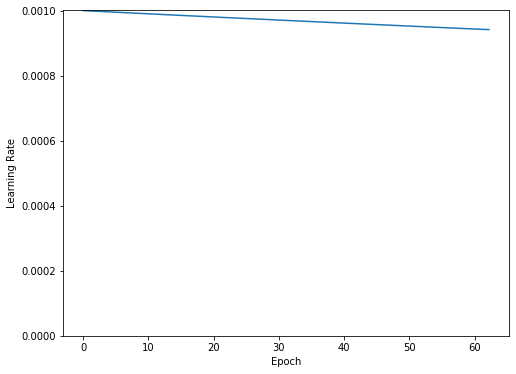

In [51]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [52]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [66]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000, verbose=0):
  if optimizer is None:
    optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

    model.summary()

    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=verbose)
    return history

### Tiny model

Start by training a model:

In [67]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [68]:
size_histories = {}

In [69]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                1584      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5185,  binary_crossentropy:1.5796,  loss:1.5796,  val_accuracy:0.5044,  val_binary_crossentropy:1.0292,  val_loss:1.0292,  
.........

KeyboardInterrupt: 

In [207]:
size_histories['Tiny'].history['binary_crossentropy']

[2.3771820068359375,
 0.8997141718864441,
 0.8829426169395447,
 0.8948631882667542,
 0.9026139974594116,
 0.8684822916984558,
 0.8804076313972473,
 0.8592902421951294,
 0.8631515502929688,
 0.8395841717720032]

Now check how the model did:

(0.5, 1)

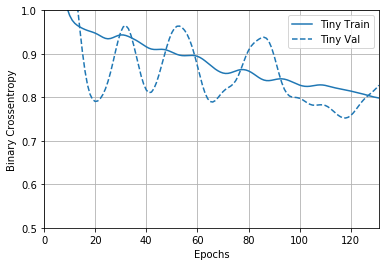

In [288]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 1])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [289]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [290]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 3,377
Trainable params: 3,377
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5017,  binary_crossentropy:3.0077,  loss:3.0077,  val_accuracy:0.4903,  val_binary_crossentropy:1.2180,  val_loss:1.2180,  
....................................................................................................
Epoch: 100, accuracy:0.4952,  binary_crossentropy:0.7250,  loss:0.7250,  val_accuracy:0.4727,  val_binary_crossentropy:0.7768,  val_lo

### Medium model

Now try 3 hidden layers with 64 units each:

In [291]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [292]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4975,  binary_crossentropy:3.1182,  loss:3.1182,  val_accuracy:0.4716,  val_binary_crossentropy:6.2460,  val_loss:6.2459,  
....................................................................................................


### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [293]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [294]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4933,  binary_crossentropy:5.5722,  loss:5.5722,  val_accuracy:0.4716,  val_binary_crossent

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

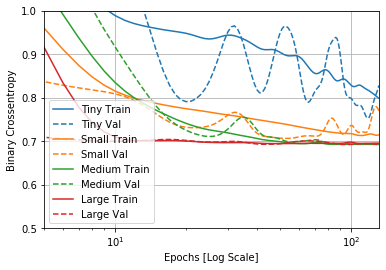

In [295]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

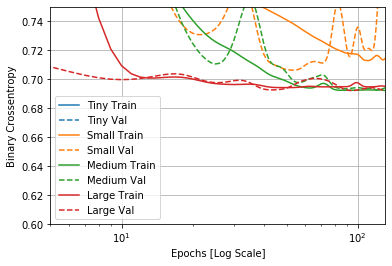

In [301]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 0.75])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

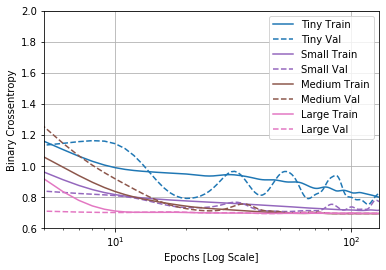

In [328]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 2])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

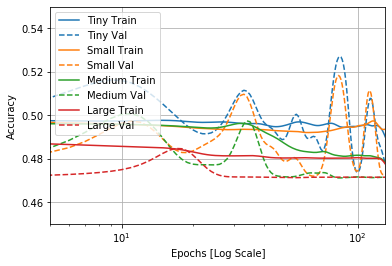

In [305]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.45, 0.55])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [306]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/fstri/AppData/Local/Temp/tmpcqha_tac/tensorboard_logs/regularizers/Tiny')

In [307]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [309]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4972,  binary_crossentropy:5.1431,  loss:6.4530,  val_accuracy:0.5274,  val_binary_crossent

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.45, 0.55)

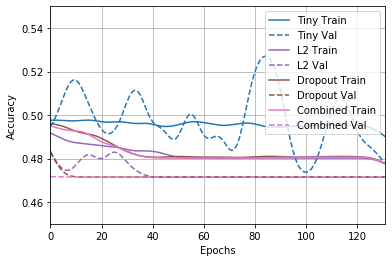

In [320]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [311]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [312]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)             

(0.45, 0.55)

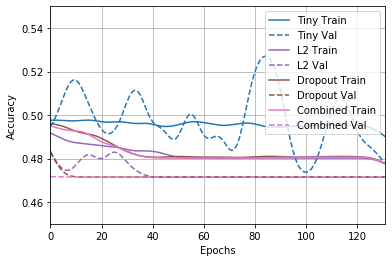

In [319]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [314]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)             

(0.45, 0.55)

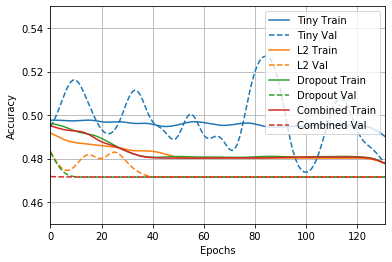

In [324]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

(0.6, 3)

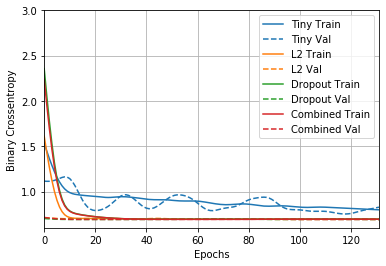

In [325]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 3])

(0.6, 0.95)

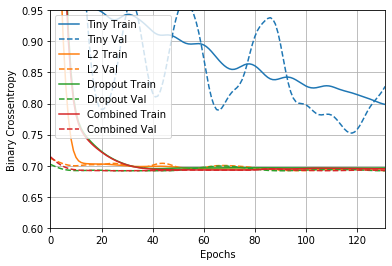

In [326]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 0.95])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.